# Loose ends in cancer genome structure

This notebook reproduces the figures from our paper.

# Dependencies

In [25]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(gGnome)
        library(gTrack)
        library(ggplot2)
        library(ggpubr)
        library(dplyr)
        library(ggalluvial)
        library(ComplexHeatmap)
        library(circlize)
        library(RColorBrewer)
        library(writexl)
        library(readxl)
    })
})

# Helper functions

In [175]:
easy.cut = function(x, start = 1e3, end = -start, step = 1e2)
{
    y = cut(x, 
            breaks = seq(start, end, by = step), 
            labels = seq(start + step / 2, end - step / 2, 
                         by = step))
}

In [176]:
dflm = function(x, last = FALSE, nm = '')
{
  if (is.null(x))
    out = data.frame(name = nm, method = as.character(NA), p = as.numeric(NA), estimate = as.numeric(NA), ci.lower = as.numeric(NA),  ci.upper = as.numeric(NA), effect = as.character(NA))
  else if (any(c('lm', 'betareg') %in% class(x)))
  {

    coef = as.data.frame(summary(x)$coefficients)
    colnames(coef) = c('estimate', 'se', 'stat', 'p')
    if (last)
      coef = coef[nrow(coef), ]
    coef$ci.lower = coef$estimate - 1.96*coef$se
    coef$ci.upper = coef$estimate + 1.96*coef$se
    if (!is.null(summary(x)$family))
    {
      fam = summary(x)$family$family
        if (summary(x)$family$link %in% c('log', 'logit'))
        {
          coef$estimate = exp(coef$estimate)
          coef$ci.upper= exp(coef$ci.upper)
          coef$ci.lower= exp(coef$ci.lower)
        }
    }
    else
      fam = 'Unknown'

    if (!last)
      nm = paste(nm, rownames(coef))
    out = data.frame(name = nm, method = fam, p = signif(coef$p, 3), estimate = coef$estimate, ci.lower = coef$ci.lower, ci.upper = coef$ci.upper, effect = paste(signif(coef$estimate, 3), ' [',  signif(coef$ci.lower,3),'-', signif(coef$ci.upper, 3), ']', sep = ''))
  }
  else if (class(x) == 'htest')
  {
    if (is.null(x$estimate))
      x$estimate = x$statistic
    if (is.null(x$conf.int))
      x$conf.int = c(NA, NA)
    out = data.table(name = nm, method = x$method, estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''), p = x$p.value)
  }
  else if (class(x) == 'polr')
  {
    coef = coef(summary(x)) %>% as.data.frame
    nm = paste(nm, rownames(coef))
    coef = as.data.table(coef)
    setnames(coef, c('estimate', 'se', 't'))
    out = data.table(name = nm) %>% cbind(coef)
    out$p =  pnorm(abs(out$t), lower.tail = FALSE) * 2
    out[, ci.lower := estimate-1.96*se]
    out[, ci.upper := estimate+1.96*se]
    out[, effect := paste(signif(estimate, 3), ' [',  signif(ci.lower,3),'-', signif(ci.upper, 3), ']', sep = '')]
  }
  else
  {
    out = data.frame(name = nm, method = x$method, p = signif(x$p.value, 3), estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''))
  }

  out$effect = as.character(out$effect)
  out$name = as.character(out$name)
  out$method = as.character(out$method)
  rownames(out) = NULL
  return(as.data.table(out))
}

# Figure 1
This figure gives an overview of benchmarking and a summary of junction and loose end counts in our pan-cancer cohort.

## Fig. 1b
Breakend call benchmarking in high-purity simulated genomes

In [43]:
mg.cncp.dt = readRDS("./data/benchmarking/cncp.rds")

precision.recall.cncp.dt = mg.cncp.dt[, .(median.precision = median(precision.cncp, na.rm = T),
                                          precision.lower = quantile(precision.cncp, na.rm = T, probs = 0.25),
                                          precision.upper = quantile(precision.cncp, na.rm = T, probs = 0.75),
                                          median.recall = median(recall.cncp, na.rm = T),
                                          recall.lower = quantile(recall.cncp, na.rm = T, probs = 0.25),
                                          recall.upper = quantile(recall.cncp, na.rm = T, probs = 0.75)),
                                      by = method]

precision.recall.cncp.dt[, method.level := ordered(method, c("JaBbA v1", 
                                                             "JaBbA v0", 
                                                             "ASCAT", 
                                                             "FACETS", 
                                                             "sequenza", 
                                                             "TITAN"))]

pt = ggplot(precision.recall.cncp.dt, aes(x = median.recall, y = median.precision)) +
    geom_point(size = 5, aes(color = method.level), alpha = 0.6) +
    geom_errorbar(mapping = aes(color = method.level, ymin = precision.lower,ymax = precision.upper),
                  width = 0.01) +
    geom_errorbarh(mapping = aes(xmin = recall.lower,xmax = recall.upper, color = method.level),
                  height = 0.01) +
    ylim(0, 1) +
    xlim(0, 1) +
    ggpubr::theme_pubr()

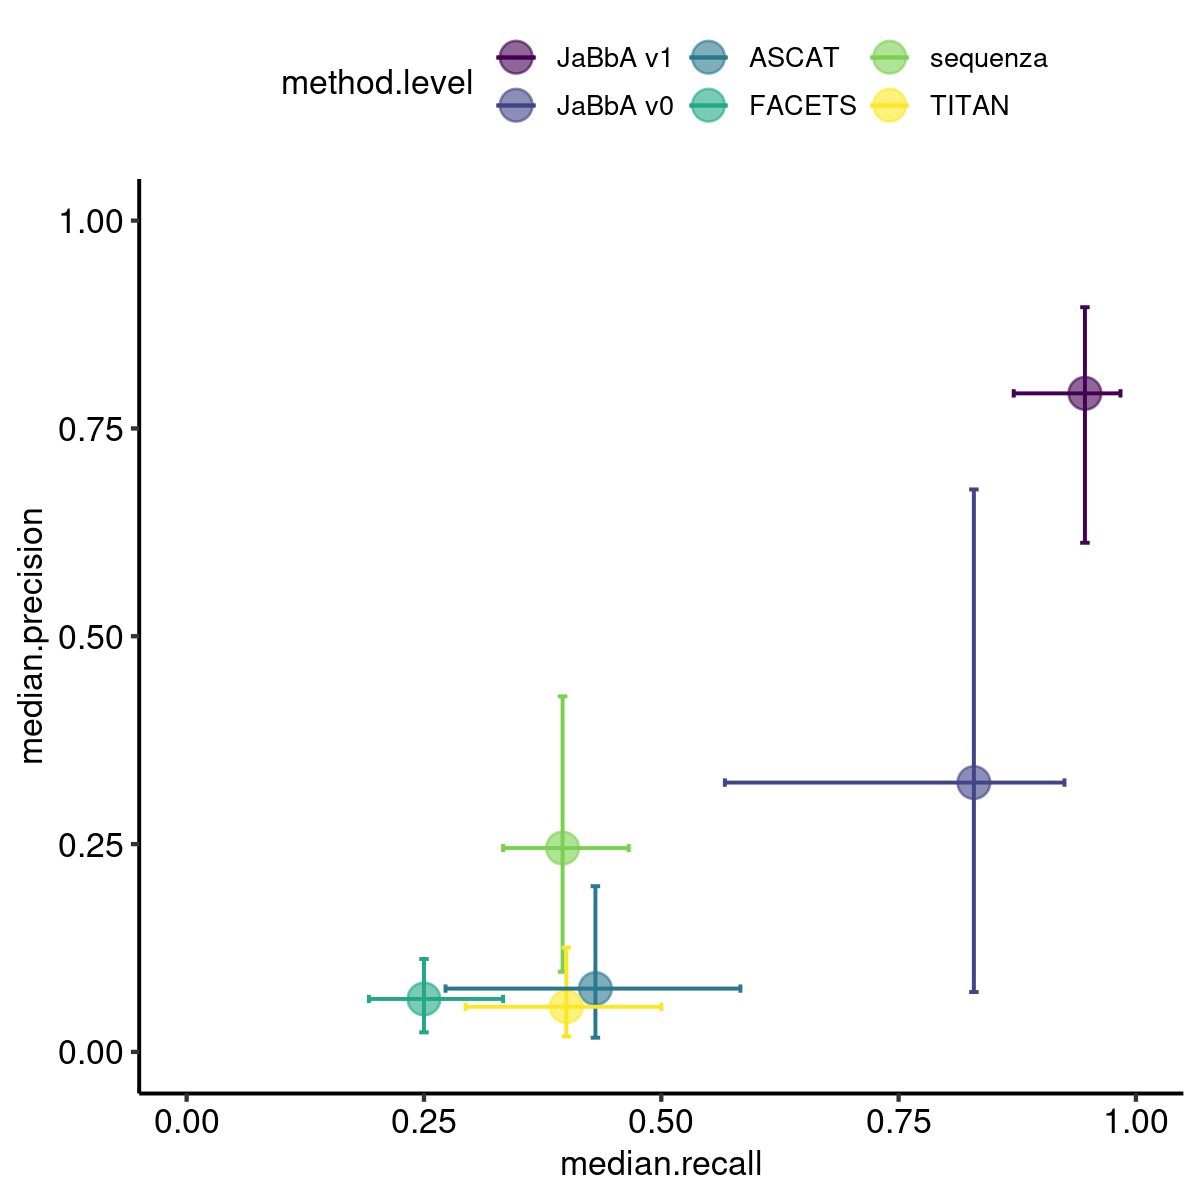

In [44]:
options(repr.plot.height = 6, repr.plot.width = 6, repr.plot.res = 200)
pt

In [45]:
fig.1b.dt = as.data.table(pt$data)
head(fig.1b.dt)

method   median.precision precision.lower precision.upper median.recall
1 sequenza 0.24521207       0.09639017      0.4277074       0.3960332    
2 ASCAT    0.07615894       0.01709402      0.1993355       0.4306050    
3 JaBbA v1 0.79217480       0.61245520      0.8957828       0.9462912    
4 TITAN    0.05429433       0.01867226      0.1254636       0.4000000    
5 FACETS   0.06369059       0.02356335      0.1118304       0.2500000    
6 JaBbA v0 0.32400319       0.07203457      0.6765586       0.8292880    
  recall.lower recall.upper method.level
1 0.3333333    0.4657415    sequenza    
2 0.2727273    0.5833333    ASCAT       
3 0.8712619    0.9837128    JaBbA v1    
4 0.2937590    0.5000000    TITAN       
5 0.1919906    0.3333333    FACETS      
6 0.5669913    0.9247235    JaBbA v0

### Fig. 1b from source data

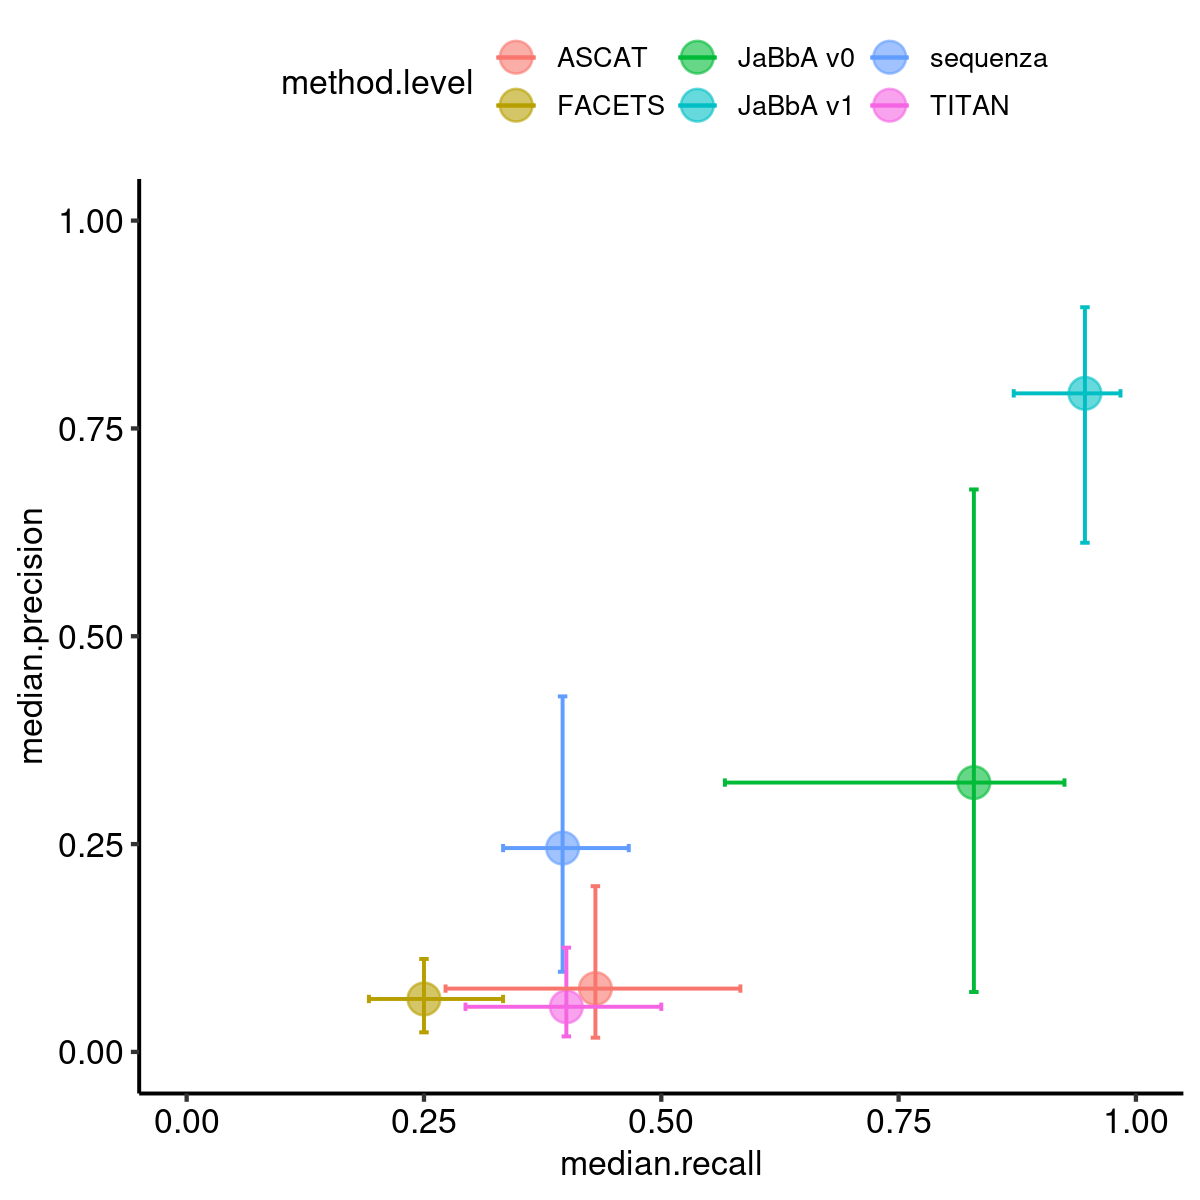

In [54]:
dat = readxl::read_xlsx("./source_data/figure_1.xlsx", sheet = "1B")

pt = ggplot(dat, aes(x = median.recall, y = median.precision)) +
    geom_point(size = 5, aes(color = method.level), alpha = 0.6) +
    geom_errorbar(mapping = aes(color = method.level, ymin = precision.lower,ymax = precision.upper),
                  width = 0.01) +
    geom_errorbarh(mapping = aes(xmin = recall.lower,xmax = recall.upper, color = method.level),
                  height = 0.01) +
    ylim(0, 1) +
    xlim(0, 1) +
    ggpubr::theme_pubr()

options(repr.plot.height = 6, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 1c
Correlation between loose end and junction breakend counts.

In [34]:
gg.pairs = readRDS("./data/sample.table.rds")

pt = ggplot(gg.pairs[(tn_cohort) & !is.na(final_njuncs) & !is.na(final_nsomatic), 
                     .(sample, final_njuncs, final_nsomatic)], 
            aes(x = final_njuncs * 2, y = final_nsomatic)) +
    geom_point(alpha = 0.5, size = 1) +
    geom_smooth(method = "lm", formula = y ~ x, mapping = aes(x = final_njuncs * 2, y = final_nsomatic)) +
    labs(x = "number of junction breakends", y = "number of loose ends") +
    geom_abline(slope = 1, intercept = 0) +
    scale_x_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    ggpubr::stat_cor(method = "pearson", label.x = 0.5, label.y = 5)

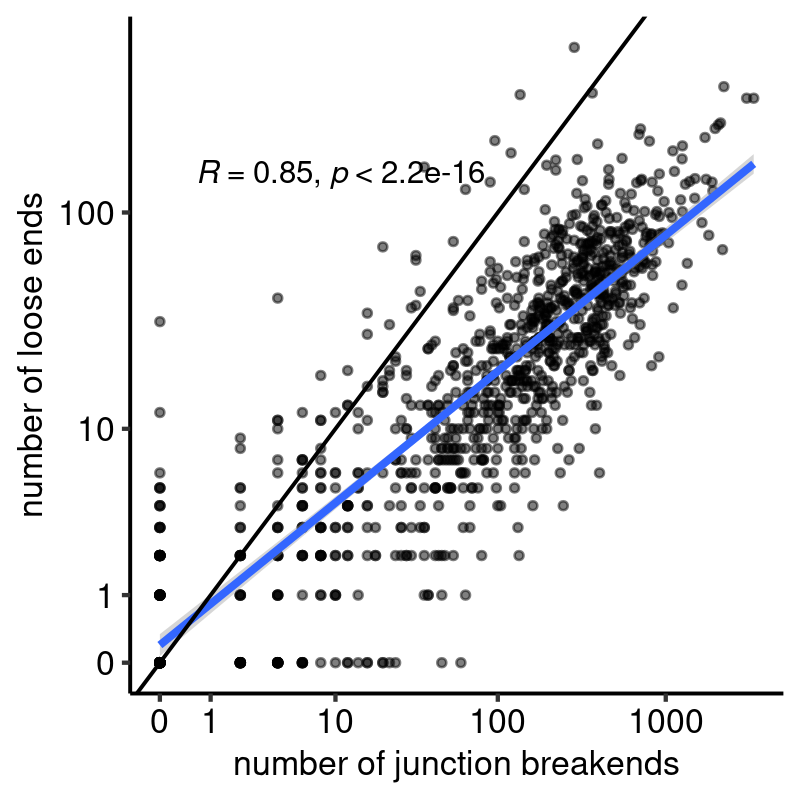

In [35]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [36]:
fig.1c.dt = as.data.table(pt$data)

### Fig. 1c from source data

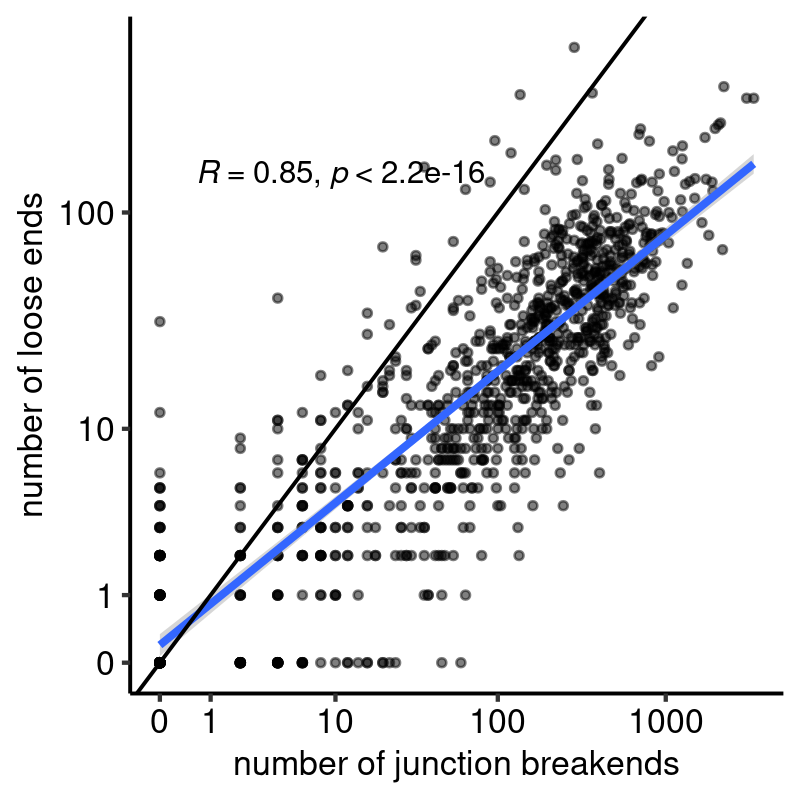

In [56]:
dat = readxl::read_xlsx("./source_data/figure_1.xlsx", sheet = "1C")

pt = ggplot(dat, aes(x = final_njuncs * 2, y = final_nsomatic)) +
    geom_point(alpha = 0.5, size = 1) +
    geom_smooth(method = "lm", formula = y ~ x, mapping = aes(x = final_njuncs * 2, y = final_nsomatic)) +
    labs(x = "number of junction breakends", y = "number of loose ends") +
    geom_abline(slope = 1, intercept = 0) +
    scale_x_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    ggpubr::stat_cor(method = "pearson", label.x = 0.5, label.y = 5)

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 1d
Junction counts versus loose end counts arranged by tumor type.

In [37]:
gg.pairs = readRDS("./data/sample.table.rds")

pt.dt = rbind(gg.pairs[(tn_cohort), .(pair, tumor_type_final, count = final_njuncs * 2, type = "junction")],
              gg.pairs[(tn_cohort), .(pair, tumor_type_final, count = final_nsomatic, type = "loose")])

pt.dt = pt.dt[!is.na(tumor_type_final)]

pt.dt[, sample := ordered(pair, levels = pt.dt[type == "junction"][order(count), pair])]
pt.dt[, label := ordered(tumor_type_final, levels = pt.dt[type == "junction"][, .(count = median(count)), by = tumor_type_final][order(count), tumor_type_final])]

pt = ggplot(pt.dt, aes(x = sample, y = count)) +
    facet_grid(rows = vars(type), cols = vars(label)) +
    geom_point(size = 0.01) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank()) +
    theme(strip.text.x = element_text(angle = 90))

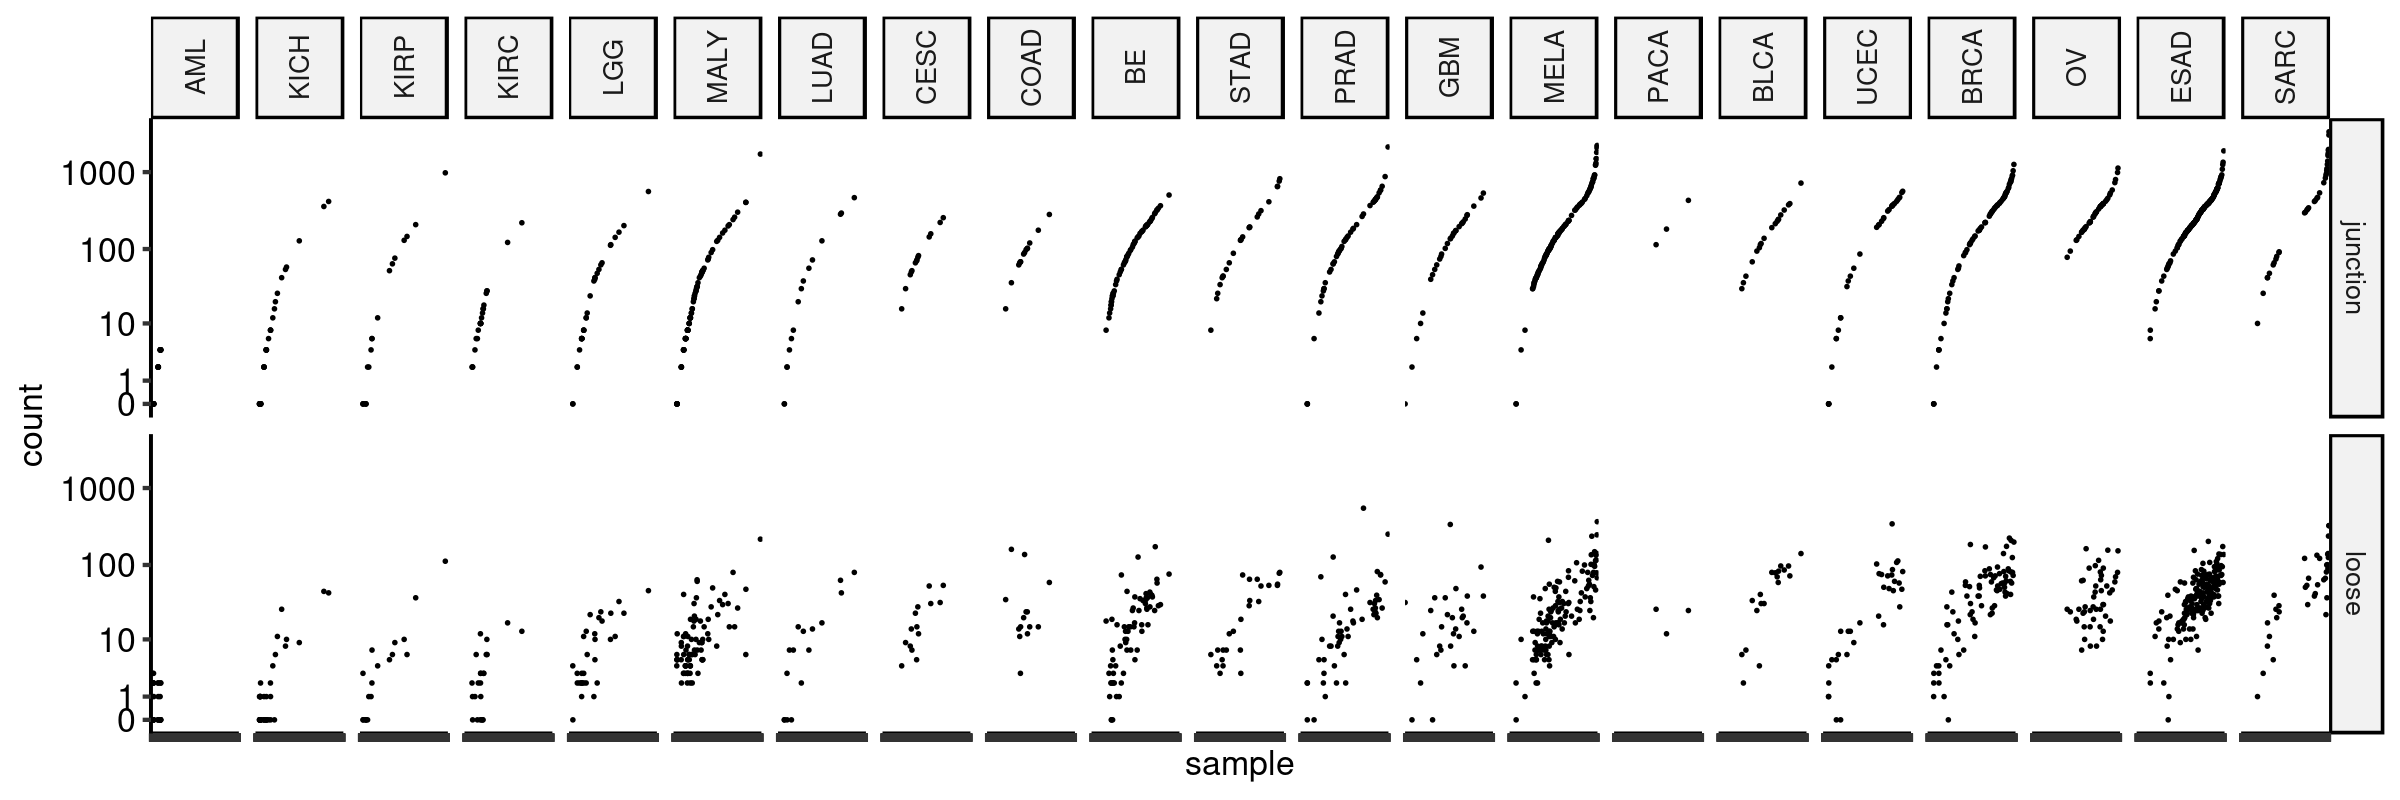

In [38]:
options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
pt

In [39]:
fig.1d.dt = as.data.table(pt$data)
head(fig.1d.dt)

pair tumor_type_final count type     sample label
1 0128 GBM                6   junction 0128   GBM  
2 0145 GBM               86   junction 0145   GBM  
3 0155 GBM               46   junction 0155   GBM  
4 0185 GBM               62   junction 0185   GBM  
5 0210 GBM              162   junction 0210   GBM  
6 0211 GBM              148   junction 0211   GBM

### Fig. 1d from source data

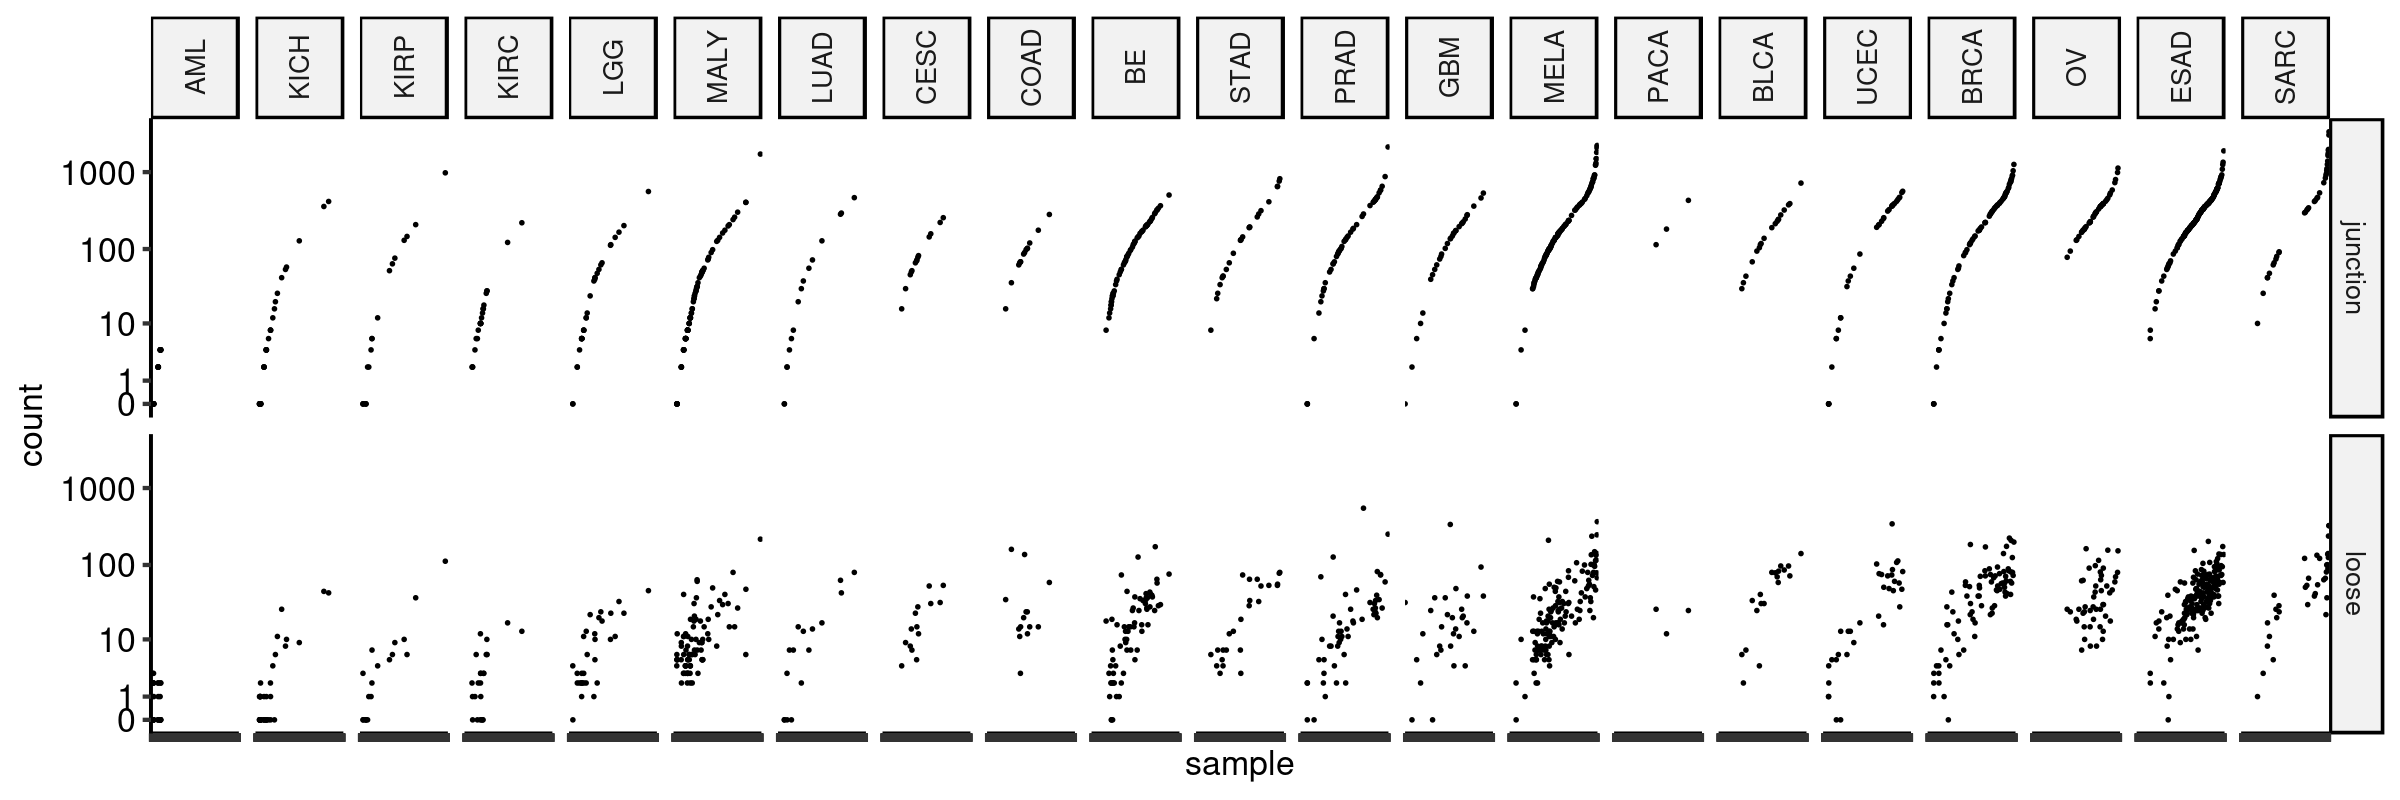

In [60]:
dat = readxl::read_xlsx("./source_data/figure_1.xlsx", sheet = "1D") %>% as.data.table

dat[, sample := ordered(pair, levels = dat[type == "junction"][order(count), pair])]
dat[, label := ordered(tumor_type_final, levels = dat[type == "junction"][, .(count = median(count)), by = tumor_type_final][order(count), tumor_type_final])]

pt = ggplot(dat, aes(x = sample, y = count)) +
    facet_grid(rows = vars(type), cols = vars(label)) +
    geom_point(size = 0.01) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank()) +
    theme(strip.text.x = element_text(angle = 90))

options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
pt

## Fig. 1e
Proportion of breakends corresponding to junctions versus loose ends, and whether they are associated with SCNAs or copy neutral

In [40]:
all.bps.dt = readRDS("./data/all.bps.dt.rds")

two.by.two.dt = all.bps.dt[(two.by.two),
                           .N, 
                           by = .(loose.or.junction, balanced)]

two.by.two.dt[, balanced := ifelse(balanced, "balanced", "unbalanced")]
two.by.two.dt[, label := paste(loose.or.junction, balanced)][, frac := N / sum(N)]

two.by.two.dt[, col := c("pink", "red", "cornflowerblue", "navy")]

pt = ggplot(two.by.two.dt, aes(x = 1, y = N, fill = label)) + 
    geom_bar(stat = "identity") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . / (two.by.two.dt[, sum(N)]), name = "frac")) +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

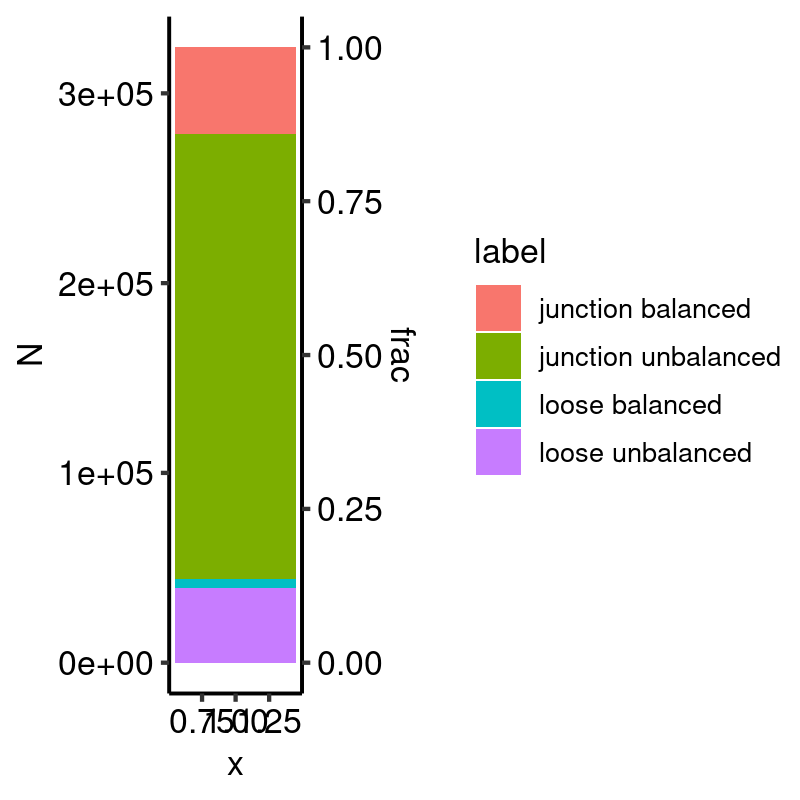

In [41]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [42]:
fig.1e.dt = as.data.table(pt$data)
head(fig.1e.dt)

loose.or.junction balanced   N      label               frac      
1 loose             unbalanced  39605 loose unbalanced    0.12215509
2 loose             balanced     4518 loose balanced      0.01393503
3 junction          unbalanced 234901 junction unbalanced 0.72451337
4 junction          balanced    45195 junction balanced   0.13939652
  col           
1 pink          
2 red           
3 cornflowerblue
4 navy

### Fig. 1e from source data

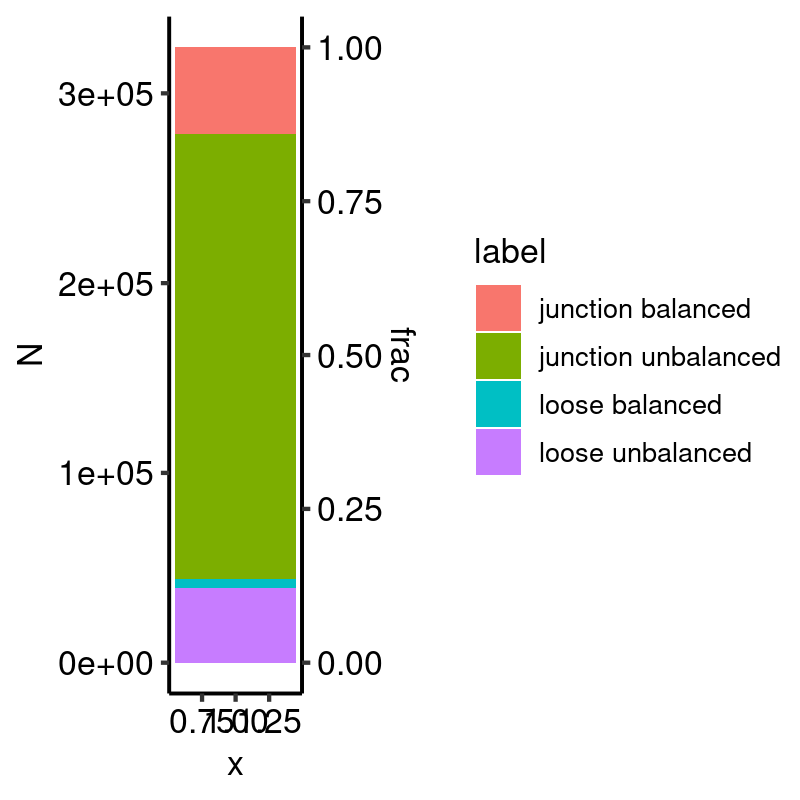

In [61]:
dat = readxl::read_xlsx("./source_data/figure_1.xlsx", sheet = "1E") %>% as.data.table

pt = ggplot(dat, aes(x = 1, y = N, fill = label)) + 
    geom_bar(stat = "identity") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . / (dat[, sum(N)]), name = "frac")) +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 1 source data

In [46]:
writexl::write_xlsx(x = list(`1B` = fig.1b.dt,
                             `1C` = fig.1c.dt,
                             `1D` = fig.1d.dt,
                             `1E` = fig.1e.dt),
                    path = "./source_data/figure_1.xlsx",
                    col_names = TRUE)

# Figure 2
Loose end mappability and comparison with long molecule profiling (Nanopore sequencing)

## Fig. 2b
Enrichment of repetitive sequences near to loose ends.

In [85]:
base.unmappable.tiles = readRDS("./data/genome_info/base.unmappable.tiles.gr.rds")
subject.dt = readRDS("./data/sequence_context/loose.ends.and.random.sites.rds")

base.unmappable.alift.gr = gUtils::anchorlift(query = base.unmappable.tiles,
                                              subject = dt2gr(subject.dt),
                                              include.values = TRUE,
                                              window = 1e5)

base.unmappable.alift.dt = as.data.table(base.unmappable.alift.gr)
base.unmappable.alift.dt[, bin := easy.cut((start + end) / 2, start = -1e5, end = 1e5, step = 1e3)]
base.unmappable.alift.dt[, bin := as.numeric(as.character(bin))]
pt.dt = base.unmappable.alift.dt[, .(count = .N), by = .(bin, type)]
pt.dt[, norm.factor := .SD[(bin < -5e3 & bin > -4e4), mean(count, na.rm = TRUE)], by = .(type)]
pt.dt[, norm.n := count / norm.factor]
pt.dt = pt.dt[abs(bin) < 25e3]
pt.dt[, x := - bin]

pt = ggplot(pt.dt[type == "loose" | type == "random"], aes(x = x / 1e3, y = norm.n, color = type)) +
    geom_line(position = "identity", stat = "identity", size = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "repetitive bases") + theme_bw() +
    ggpubr::theme_pubr() +
    ylim(0, 3) +
    xlim(-25, 25)

Computing overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 230 out-of-bound ranges located on sequences
  11, 12, 14, 17, 18, 19, 1, 22, 2, 5, 7, 8, X, 1_gl000192_random,
  19_gl000209_random, 20, 6, 4, Un_gl000221, 13, Un_gl000228,
  Un_gl000213, 16, 9_gl000198_random, 10, Un_gl000223, Un_gl000249,
  1_gl000191_random, 4_gl000193_random, Y, Un_gl000240, Un_gl000216,
  7_gl000195_random, 9_gl000199_random, Un_gl000220, Un_gl000219, 3,
  Un_gl000222, 21, Un_gl000227, 4_gl000194_random, Un_gl000218,
  17_gl000205_random, 8_gl000197_random, Un_gl000214, Un_gl000247, 15,
  Un_gl000236, Un_gl000244, 9_gl000200_random, Un_gl000215, Un_gl000225,
  Un_gl000217, 17_gl000203_random, 11_gl000202_random, Un_gl000237,
  17_gl000204_random, Un_gl000235, Un_gl000211, and 9. Note that ranges
  located on a sequence whose length is unknown (NA) or on a circular
  sequence are not considered out-of-bound (use seqlengths() and
  isCircular() to ge

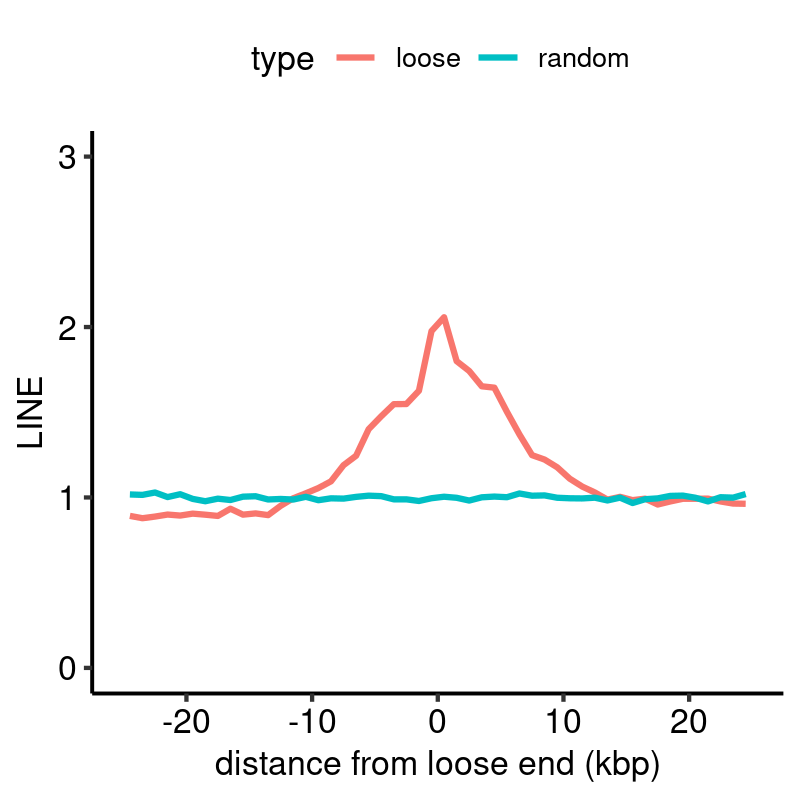

In [49]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [50]:
fig.2b.dt = as.data.table(pt$data)
head(fig.2b.dt)

bin    type   count norm.factor norm.n    x     
1 -19500 loose  3692  3720.886    0.9922369  19500
2  19500 random 3490  3519.543    0.9916061 -19500
3  10500 random 3533  3519.543    1.0038235 -10500
4 -18500 loose  3634  3720.886    0.9766492  18500
5  18500 random 3442  3519.543    0.9779679 -18500
6   9500 random 3463  3519.543    0.9839346  -9500

### Fig. 2b from source

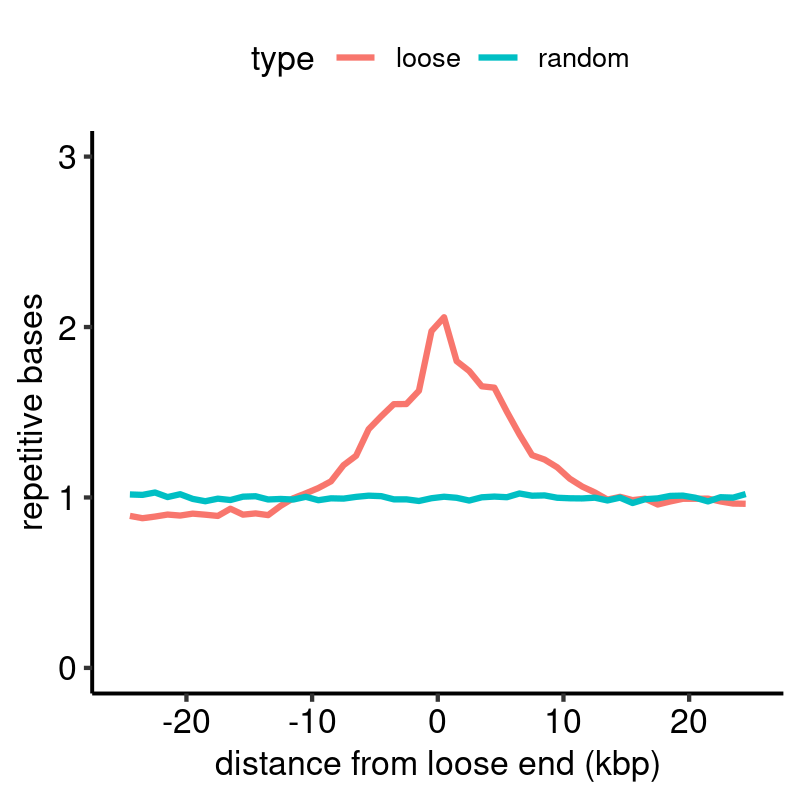

In [86]:
dat = readxl::read_xlsx("./source_data/figure_2.xlsx", sheet = "2B") %>% as.data.table

pt = ggplot(dat, aes(x = x / 1e3, y = norm.n, color = type)) +
    geom_line(position = "identity", stat = "identity", size = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "repetitive bases") + theme_bw() +
    ggpubr::theme_pubr() +
    ylim(0, 3) +
    xlim(-25, 25)

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 2c
Density of loose reads (uniquely mapping reads with ambiguously mapping mates) near loose ends

In [62]:
## The raw data (positional reads) for this plot is *huge* 
## Consequently I only saved the summarized count of loose reads by position
pt.dt = readRDS("./data/sequence_context/loose.reads.overall.rds")

pt = ggplot(pt.dt[somatic == "somatic"], aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(read.strand)) +
    labs(x = "distance from loose end (bp)", y = "loose read density") +
    ggpubr::theme_pubr()

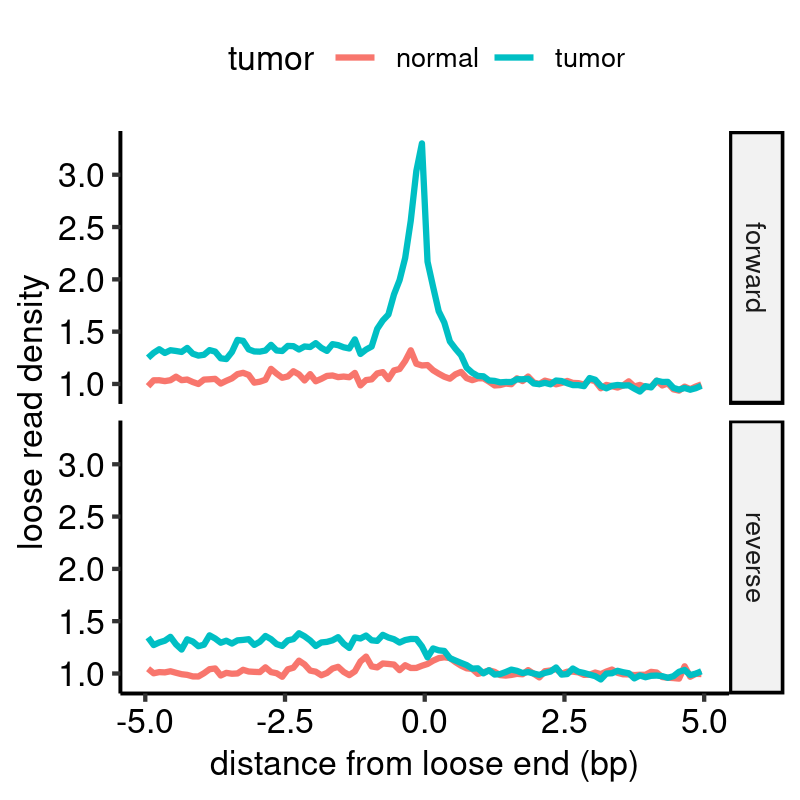

In [63]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [64]:
fig.2c.dt = as.data.table(pt$data)
head(fig.2c.dt)

read.strand somatic tumor bin   n     norm.factor norm.n    x   
1 forward     somatic tumor -4750 71485 75633.35    0.9451518 4.75
2 forward     somatic tumor -4650 72723 75633.35    0.9615203 4.65
3 reverse     somatic tumor -4650 77824 75292.93    1.0336164 4.65
4 forward     somatic tumor -4550 71557 75633.35    0.9461038 4.55
5 forward     somatic tumor -4450 72805 75633.35    0.9626045 4.45
6 forward     somatic tumor -4350 77115 75633.35    1.0195899 4.35

### Fig. 2c from source

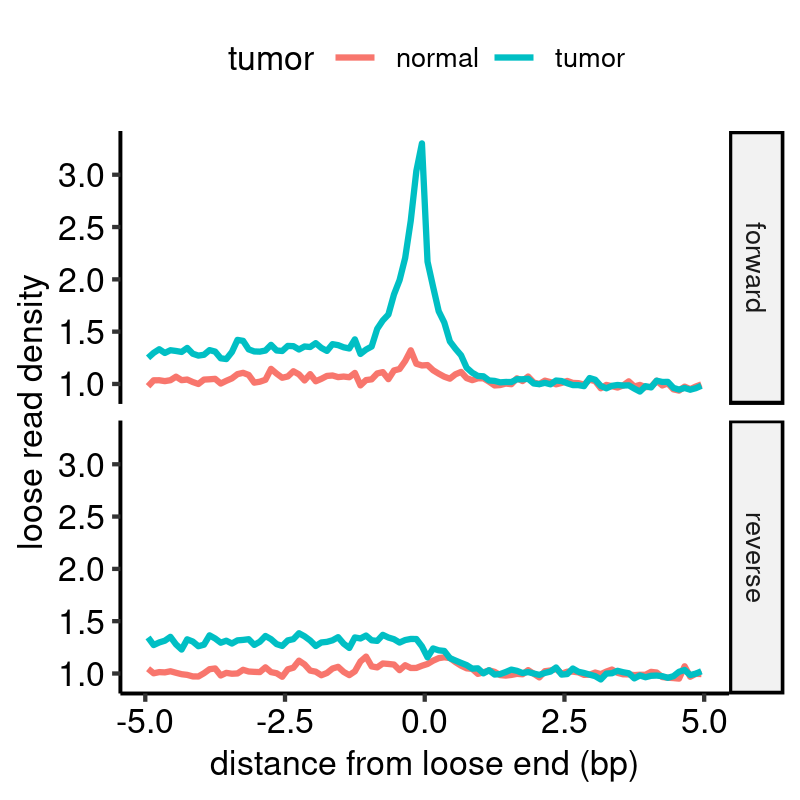

In [80]:
dat = readxl::read_xlsx("./source_data/figure_2.xlsx", sheet = "2C") %>% as.data.table

pt = ggplot(dat, aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(read.strand)) +
    labs(x = "distance from loose end (bp)", y = "loose read density") +
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 2e
Alluvial plot of loose ends as fully, ambiguously, and partially mapped.

In [65]:
alluv.dt = readRDS("~/projects/gGnome/files/zc_stash/fig2.alluv.dt.rds")
all.bps.dt = readRDS("./data/all.bps.dt.rds")

alluv.pt = ggplot(alluv.dt, aes(axis1 = annotation.levels, axis3 = proximal.levels, axis2 = distal.levels, y = overall.frac)) +
    ggalluvial::geom_alluvium(aes(fill = annotation.levels), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.4, reverse = FALSE, alpha = 0.5, color = "black") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (all.bps.dt[(gg.pairs[sample, tn_cohort]) & (loose.or.junction == "loose"),.N]), 
                                           name = "count")) +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "number of breakends") +
    coord_flip() +
    ggpubr::theme_pubr()

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”


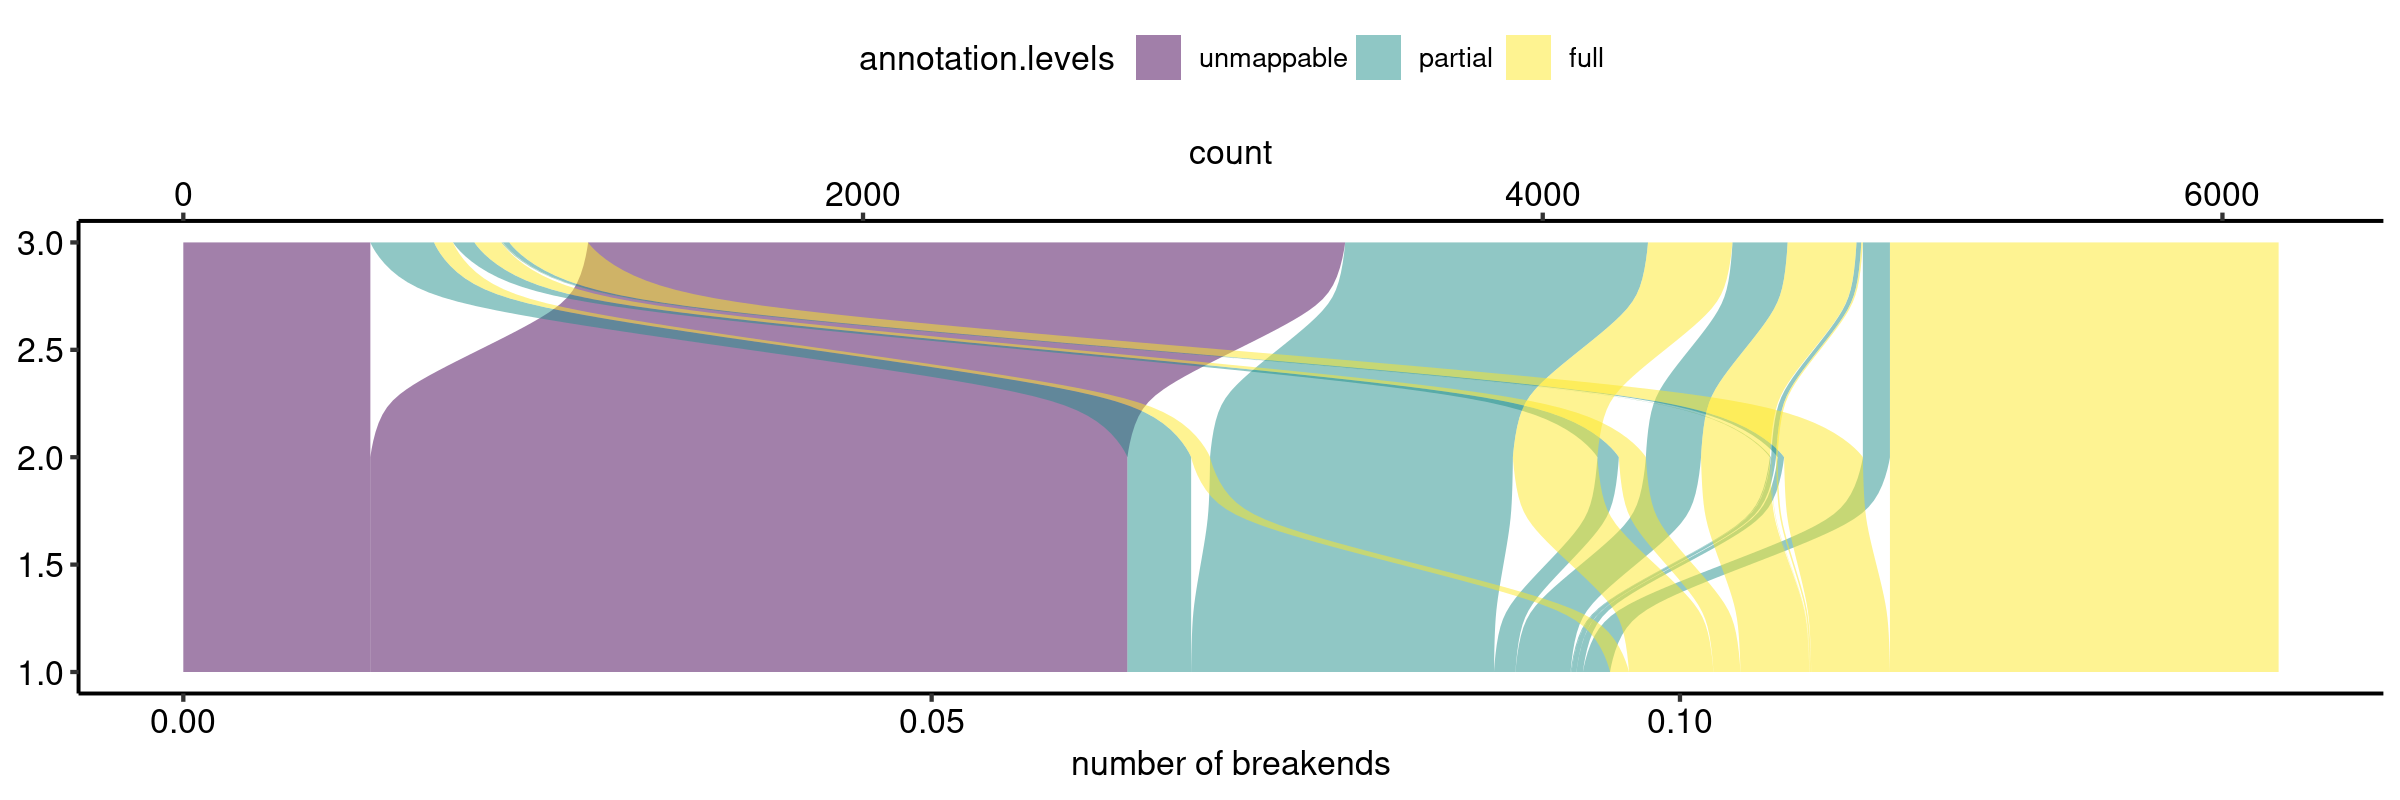

In [66]:
options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
alluv.pt

In [67]:
fig.2e.dt = as.data.table(alluv.pt$data)
head(fig.2e.dt)

proximal.tranch distal.tranch   annotation.label N     frac       
1 unique          no contigs      unmappable       21402 0.361312760
2 base unmappable unique          partial            185 0.003123206
3 unique          cn unmappable   full              2388 0.040314684
4 unique          unique          full             10988 0.185501570
5 unique          base unmappable partial           1559 0.026319344
6 unique          cn unmappable   partial           8561 0.144528480
  annotation.levels proximal.levels distal.levels   overall.frac
1 unmappable        unique          no contigs      0.0505837863
2 partial           base unmappable unique          0.0004372489
3 full              unique          cn unmappable   0.0056440558
4 full              unique          unique          0.0259702198
5 partial           unique          base unmappable 0.0036847081
6 partial           unique          cn unmappable   0.0202339872

### Fig. 2e from source

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”


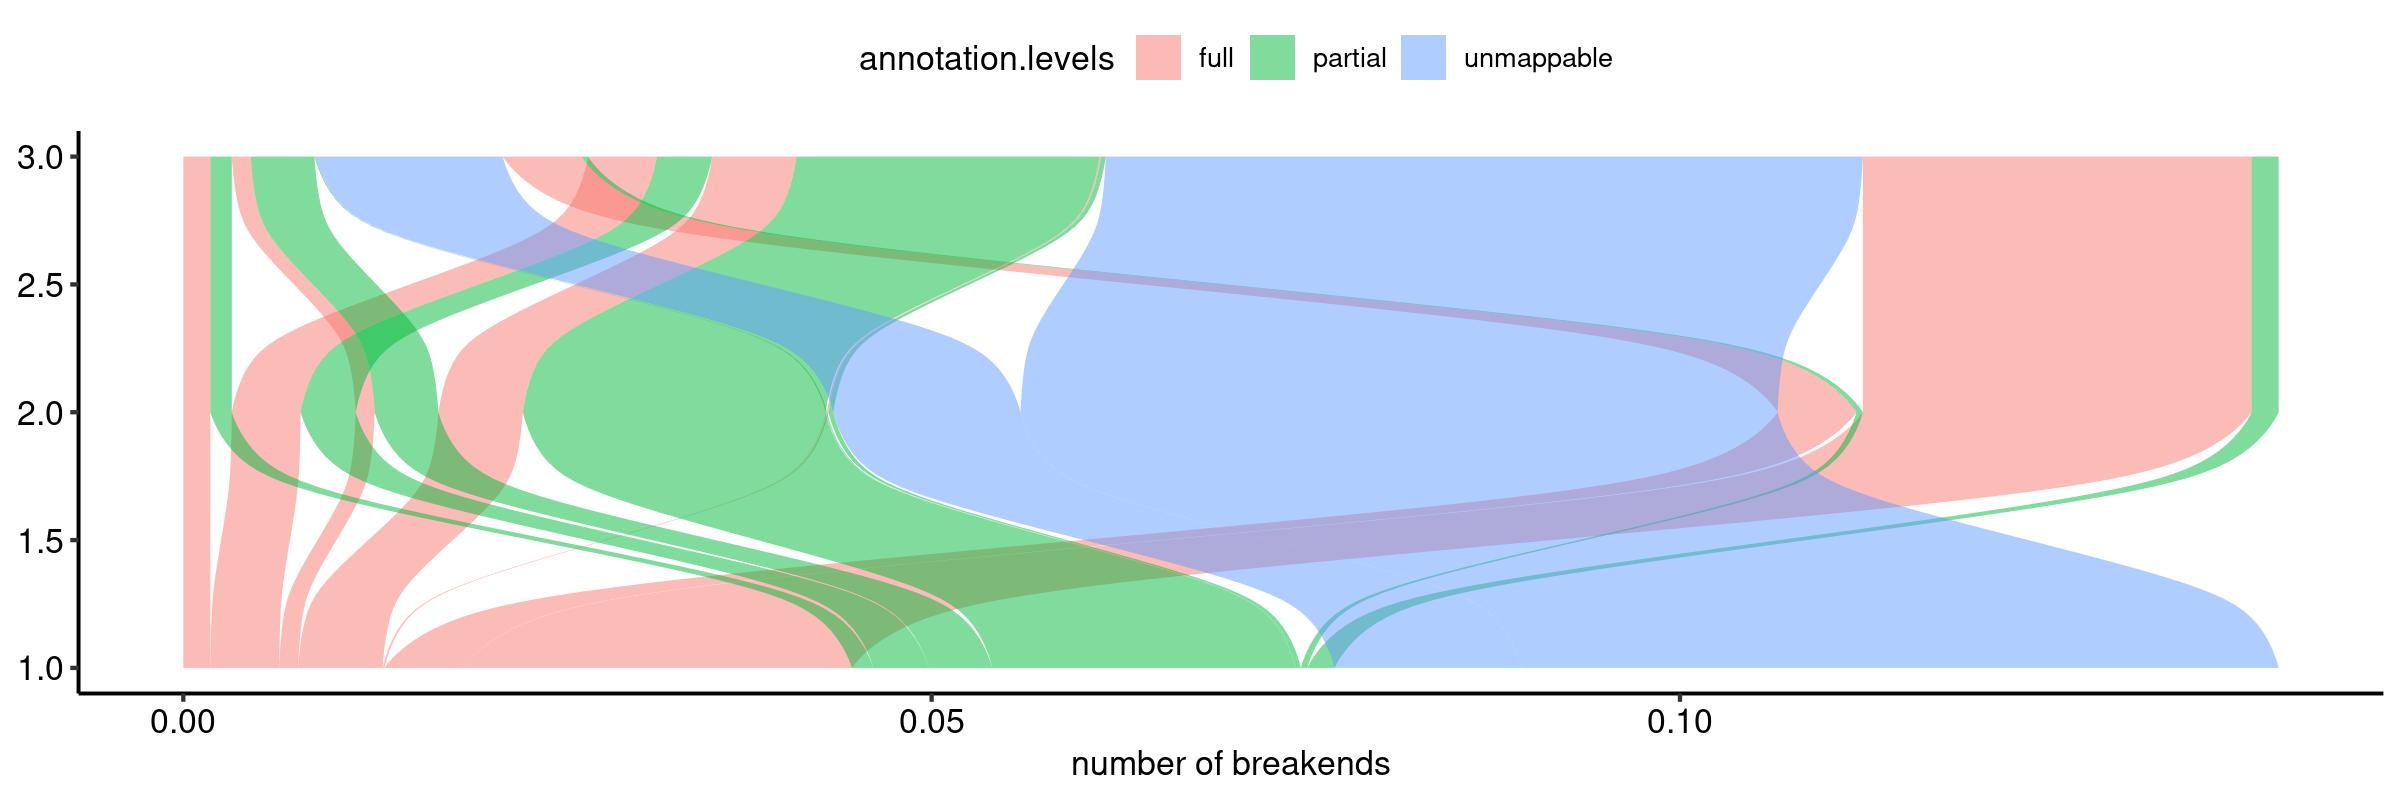

In [79]:
dat = readxl::read_xlsx("./source_data/figure_2.xlsx", sheet = "2E") %>% as.data.table

alluv.pt = ggplot(dat, aes(axis1 = annotation.levels, 
                           axis3 = proximal.levels, 
                           axis2 = distal.levels, 
                           y = overall.frac)) +
    ggalluvial::geom_alluvium(aes(fill = annotation.levels), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.4, reverse = FALSE, alpha = 0.5, color = "black") +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "number of breakends") +
    coord_flip() +
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
alluv.pt

## Fig. 2F
Comparison of breakends between short reads and nanopore sequencing, depending on whether a breakend has a reciprocal rearrangement.

In [68]:
## this file contains the raw data (breakend locations) for the alluvial plot
## however, reading it isn't necessary if you just want to produce the alluvial plot
ont.bps.dt = readRDS("./data/ont/ont.bps.dt.rds")

In [69]:
alluv.dt = readRDS("./data/ont/ont.alluv.dt.rds")

alluv.pt = ggplot(alluv.dt, aes(axis1 = intersection.label, axis2 = reciprocal.label, y = N)) +
    ggalluvial::geom_alluvium(aes(fill = intersection.label), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.1, reverse = FALSE, alpha = 1, color = "white", fill = "white") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . / (alluv.dt[, sum(N)]), name = "frac")) +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "count") +
    ggpubr::theme_pubr() +
    theme(legend.position = "none")

Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”


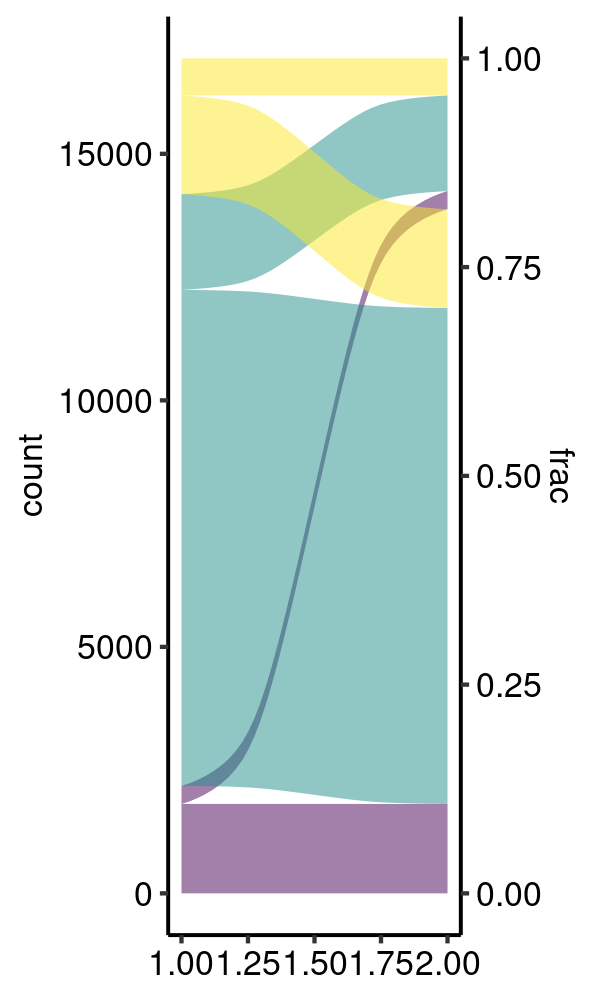

In [70]:
options(repr.plot.height = 5, repr.plot.width = 3, repr.plot.res = 200)
alluv.pt

In [71]:
fig.2f.dt = as.data.table(alluv.pt$data)
head(fig.2f.dt)

intersection.label reciprocal.label N    
1 ONT + SRS          non-reciprocal   10060
2 ONT                non-reciprocal    2002
3 ONT                reciprocal         753
4 ONT + SRS          reciprocal        1940
5 SRS                non-reciprocal    1814
6 SRS                reciprocal         368

### Fig. 2f from source

Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”


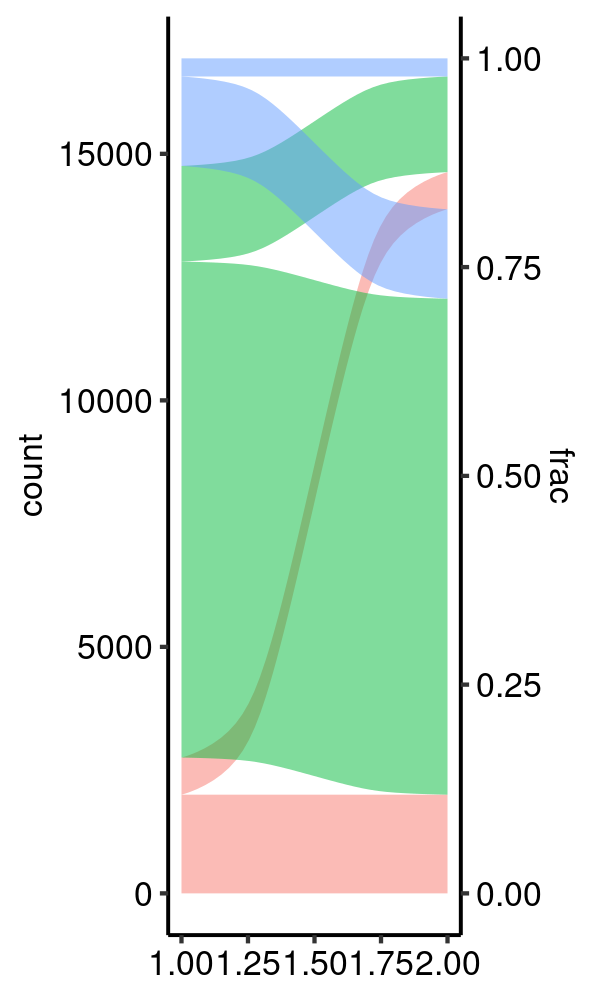

In [77]:
dat = readxl::read_xlsx("./source_data/figure_2.xlsx", sheet = "2F") %>% as.data.table

alluv.pt = ggplot(dat, aes(axis1 = intersection.label, axis2 = reciprocal.label, y = N)) +
    ggalluvial::geom_alluvium(aes(fill = intersection.label), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.1, reverse = FALSE, alpha = 1, color = "white", fill = "white") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . / (dat[, sum(N)]), name = "frac")) +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "count") +
    ggpubr::theme_pubr() +
    theme(legend.position = "none")

options(repr.plot.height = 5, repr.plot.width = 3, repr.plot.res = 200)
alluv.pt

## Fig. 2g
Comparison of complex event calls between short reads and ONT

In [72]:
## event calls
ont.rescue.events.dt = readRDS("./data/ont/ont.rescue.events.dt.rds")

## sample table
ont.pairs = readRDS("./data/ont/ont.sample.table.rds")

ont.rescue.events.dt = ont.rescue.events.dt[(ont.pairs[sample, (ont_cohort)]),]
valid.etypes = c("del", "dup", "inv", "tra", "invdup", "pyrgo", "rigma", "chromoplexy", "chromothripsis", "complex amplicon", "tic")
amplicon.etypes = c("bfb", "dm", "cpxdm", "tyfonas")
ont.rescue.per.event.dt = ont.rescue.events.dt[, .(old = old[1],
                                                   type = type[1],
                                                   fp = paste(paste0(seqnames, ":", start, "-", end,"+"),
                                                              collapse = ",")),
                                               by = .(ev.id, sample)]
ont.rescue.per.event.dt[, new.etype := ifelse(type %in% amplicon.etypes, "complex amplicon", type)]

ont.frac.event.dt = ont.rescue.per.event.dt[(new.etype %in% valid.etypes),]
ont.frac.event.dt[, new.label := ordered(ifelse(old, "SRS only", "LRS + SRS"), levels = c("SRS only", "LRS + SRS"))]
ont.frac.event.dt[, nice.labels := paste(new.etype, paste0("(", .N, ")")), by = new.etype]
label.order = ont.frac.event.dt[, .N, by = nice.labels][order(N), nice.labels]
ont.frac.event.dt[, label.levels := ordered(nice.labels, levels = label.order)]

## relevel...
ont.frac.event.dt[, complex := !(type %in% c("dup", "del", "inv", "tra", "invdup"))]
ont.frac.event.dt[, label.levels := ordered(nice.labels, 
                                            levels = ont.frac.event.dt[, .(complex = any(complex), 
                                                                           n = length(unique(paste(sample, ev.id)))), 
                                                                       by = nice.labels][order(n),][order(complex),][, nice.labels])]

bp = ggplot(ont.frac.event.dt, aes(x = label.levels, fill = new.label)) +
    geom_bar(stat = "count", position = "fill") +
    labs(x = "event type (n events)", y = "count") +
    ggpubr::theme_pubr() +
    coord_flip() +
    theme(legend.position = "right")


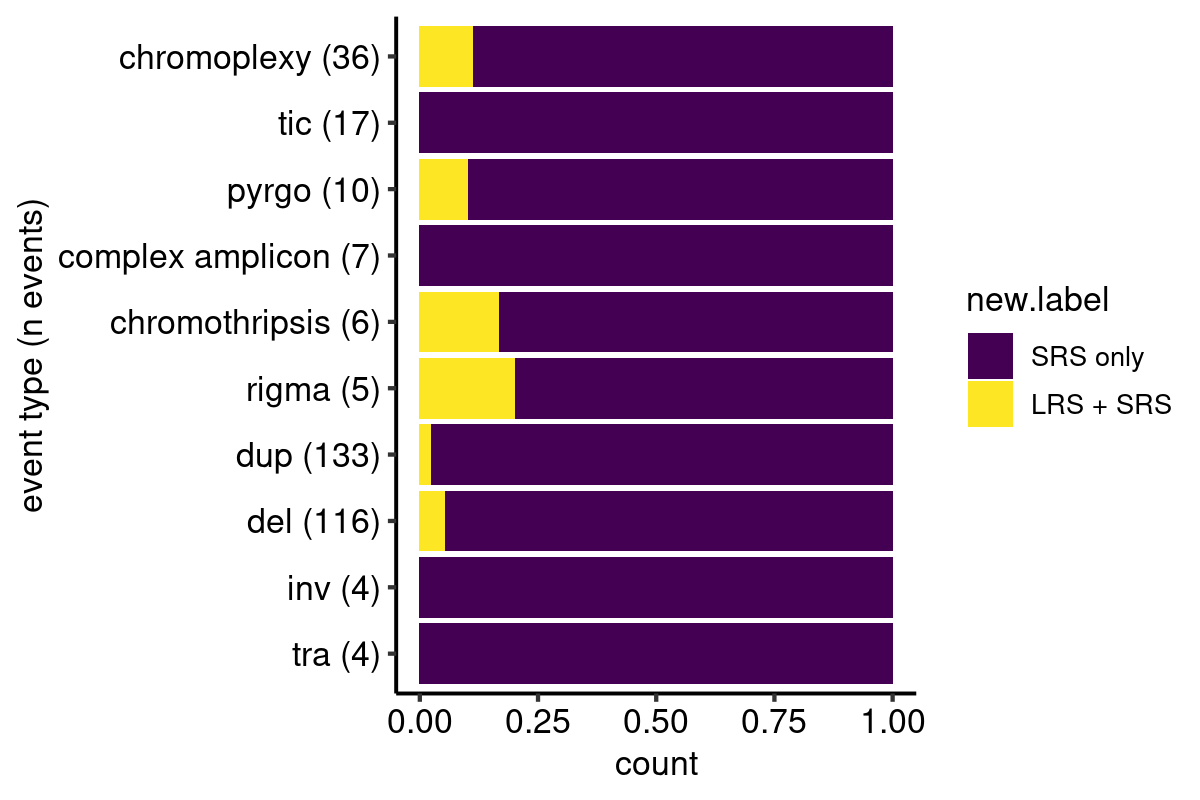

In [73]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
bp

In [74]:
fig.2g.dt = as.data.table(bp$data)
head(fig.2g.dt)

ev.id sample   old   type  fp                                       new.etype
1 1     JTS-1501  TRUE tra   16:56210449-56210449+,3:1504312-1504312+ tra      
2 2     JTS-1501  TRUE pyrgo 8:128035549-128965211+                   pyrgo    
3 3     JTS-1501 FALSE pyrgo 4:156338933-156898382+                   pyrgo    
4 4     JTS-1501  TRUE pyrgo 3:172148153-172414798+                   pyrgo    
5 5     JTS-1501  TRUE pyrgo 20:48577106-49009764+                    pyrgo    
6 6     JTS-1501  TRUE pyrgo 15:89455510-89730993+                    pyrgo    
  new.label nice.labels label.levels complex
1 SRS only  tra (4)     tra (4)      FALSE  
2 SRS only  pyrgo (10)  pyrgo (10)    TRUE  
3 LRS + SRS pyrgo (10)  pyrgo (10)    TRUE  
4 SRS only  pyrgo (10)  pyrgo (10)    TRUE  
5 SRS only  pyrgo (10)  pyrgo (10)    TRUE  
6 SRS only  pyrgo (10)  pyrgo (10)    TRUE

### Fig. 2g from source

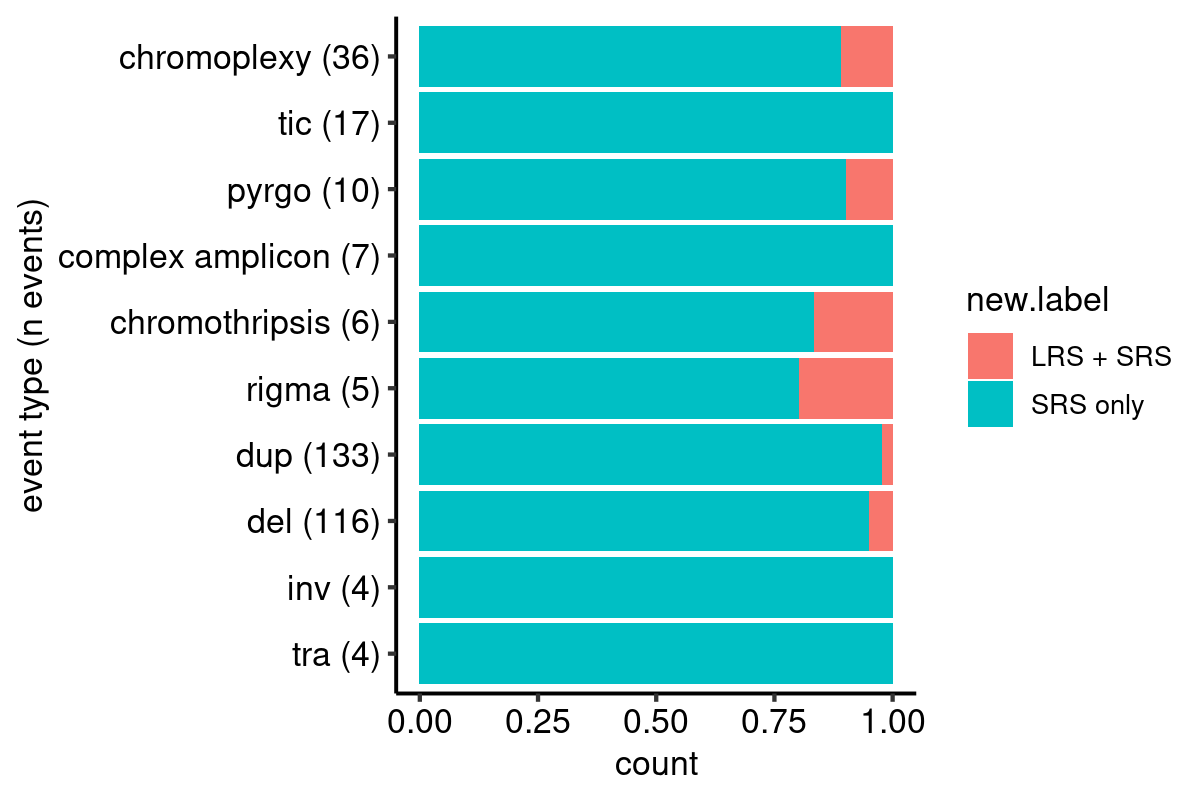

In [76]:
dat = readxl::read_xlsx("./source_data/figure_2.xlsx", sheet = "2G") %>% as.data.table

dat[, complex := !(type %in% c("dup", "del", "inv", "tra", "invdup"))]
dat[, label.levels := ordered(nice.labels,
                              levels = dat[, .(complex = any(complex),
                                               n = length(unique(paste(sample, ev.id)))),
                                           by = nice.labels][order(n),][order(complex),][, nice.labels])]


bp = ggplot(dat, aes(x = label.levels, fill = new.label)) +
    geom_bar(stat = "count", position = "fill") +
    labs(x = "event type (n events)", y = "count") +
    ggpubr::theme_pubr() +
    coord_flip() +
    theme(legend.position = "right")

options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
bp

In [83]:
writexl::write_xlsx(x = list(`2B` = fig.2b.dt,
                             `2C` = fig.2c.dt,
                             `2E` = fig.2e.dt,
                             `2F` = fig.2f.dt,
                             `2G` = fig.2g.dt),
                    path = "./source_data/figure_2.xlsx",
                    col_names = TRUE)

# Figure 3
Analysis of TR+ loose ends and neotelomeres

## Fig. 3a
Anchorlift of telomeric loose reads over to somatic loose ends

In [122]:
## again, raw data file is gigantic!!
## just the trace for the anchorlift is saved.
pt.dt = readRDS("./data/neotelomeres/tr.loose.reads.anchorlift.rds")

pt = ggplot(pt.dt[somatic == "somatic"], aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(forward)) +
    labs(x = "distance from loose end (Kbp)", y = "telomeric loose reads") +
    ggpubr::theme_pubr()

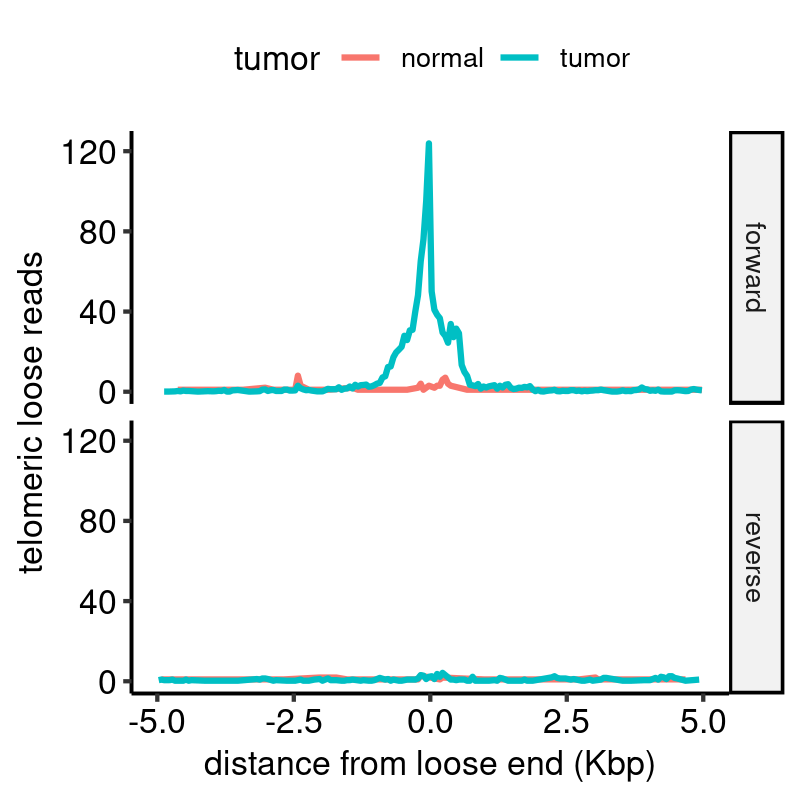

In [123]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [124]:
fig.3a.dt = as.data.table(pt$data)
head(fig.3a.dt)

forward somatic tumor  bin   n   norm.factor norm.n     x     
1 forward somatic tumor   -225 307 10.389610   29.5487500  0.225
2 forward somatic tumor   -375 351 10.389610   33.7837500  0.375
3 reverse somatic tumor  -2225   7  3.583333    1.9534884  2.225
4 forward somatic normal   725   1  1.000000    1.0000000 -0.725
5 reverse somatic tumor   -825   1  3.583333    0.2790698  0.825
6 forward somatic tumor   1175  37 10.389610    3.5612500 -1.175

### Fig. 3a from source

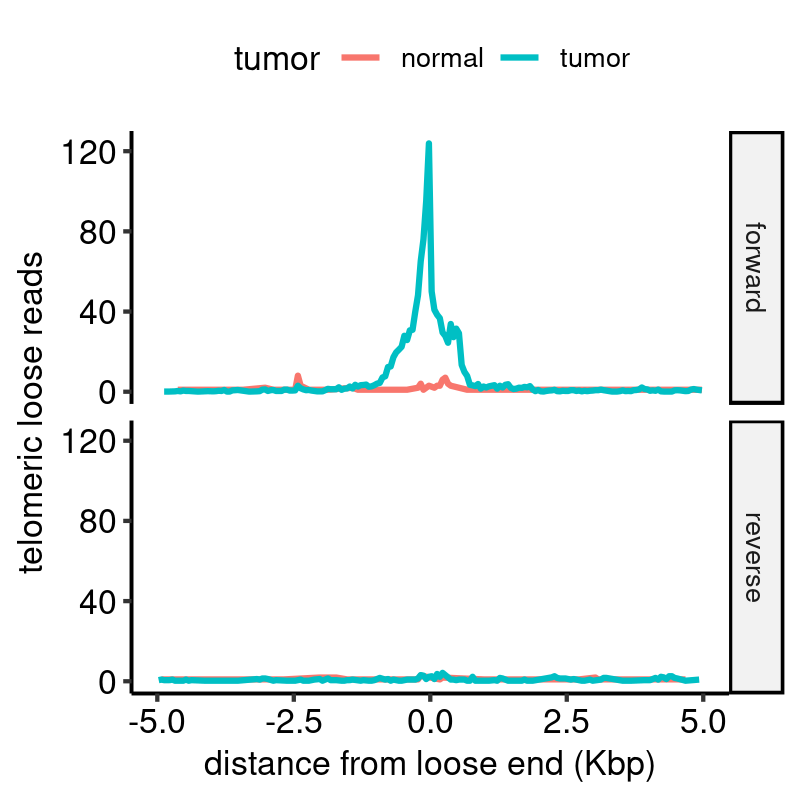

In [127]:
dat = readxl::read_xlsx("./source_data/figure_3.xlsx", sheet = "3A") %>% as.data.table

pt = ggplot(dat, aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(forward)) +
    labs(x = "distance from loose end (Kbp)", y = "telomeric loose reads") +
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 3c
CRTR+ and GRTR+ telomeric loose reads vs. CRTR+ and GRTR+ loose ends

In [129]:
pt.dt = readRDS("./data/neotelomeres/crtr.grtr.loose.reads.anchorlift.rds")

pt = ggplot(pt.dt[tumor == "tumor"], aes(x = bin, y = n, color = color.label)) + 
geom_line(size = 1, alpha = 0.5) + 
facet_grid(rows = vars(forward), cols = vars(rep)) + 
labs(x = "distance from loose end (bp)", y = "telomeric loose reads") + 
ggpubr::theme_pubr()

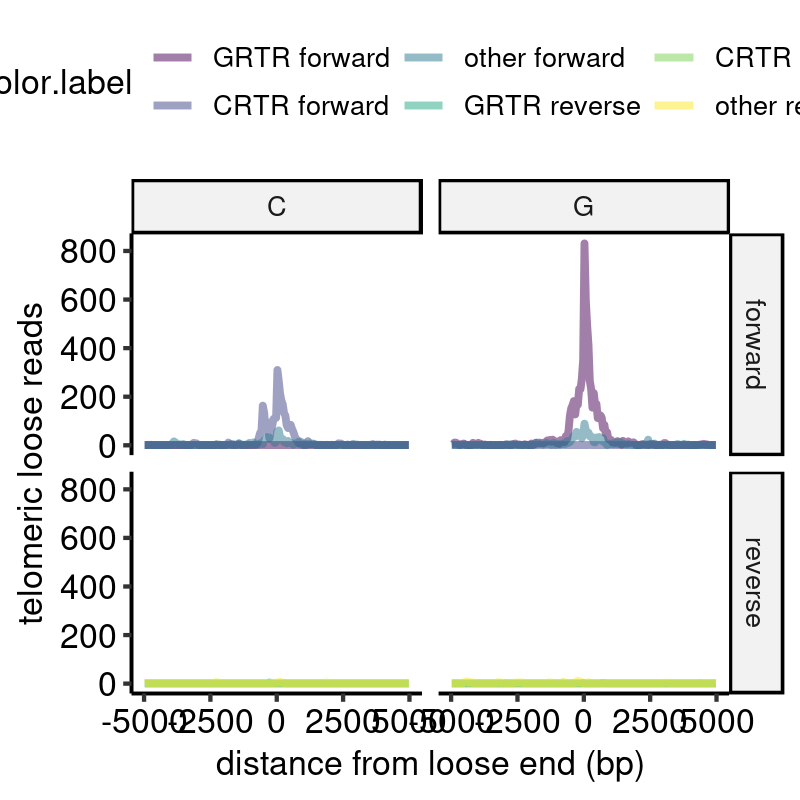

In [130]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [131]:
fig.3c.dt = as.data.table(pt$data)
head(fig.3c.dt)

forward tumor bin   label rep n norm.factor norm.n    color.label  
1 forward tumor -4975 CRTR  C   1  3.05       0.3278689 CRTR forward 
2 forward tumor -4975 CRTR  G   1  1.05       0.9523810 CRTR forward 
3 forward tumor -4975 GRTR  C   1  1.00       1.0000000 GRTR forward 
4 forward tumor -4975 GRTR  G   4 12.05       0.3319502 GRTR forward 
5 forward tumor -4975 other C   1  2.80       0.3571429 other forward
6 forward tumor -4975 other G   3  5.00       0.6000000 other forward

### Fig. 3c from source

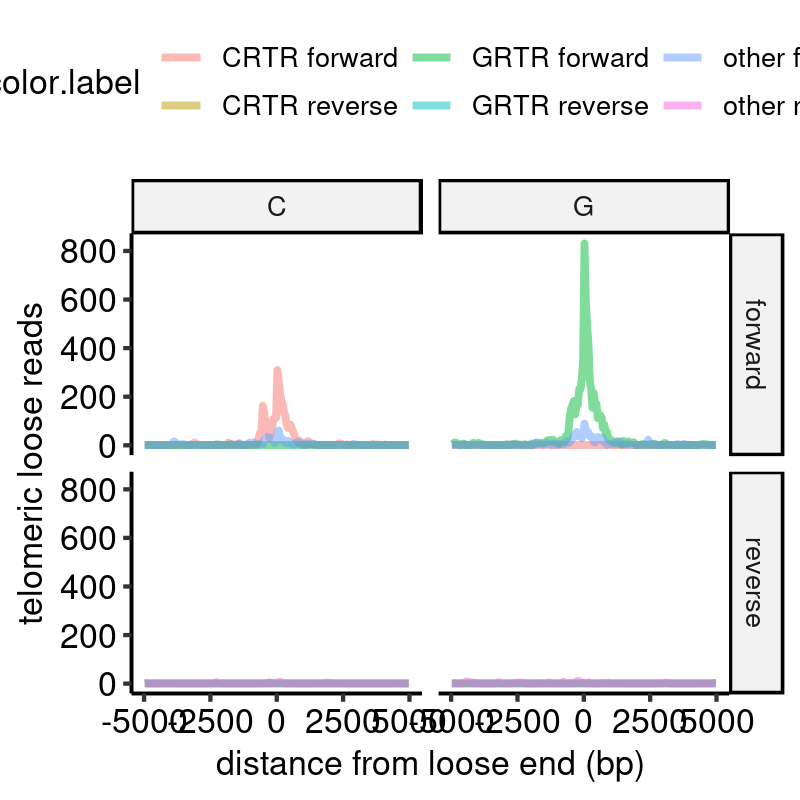

In [132]:
dat = readxl::read_xlsx("./source_data/figure_3.xlsx", sheet = "3C") %>% as.data.table

pt = ggplot(dat, aes(x = bin, y = n, color = color.label)) + 
geom_line(size = 1, alpha = 0.5) + 
facet_grid(rows = vars(forward), cols = vars(rep)) + 
labs(x = "distance from loose end (bp)", y = "telomeric loose reads") + 
ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 3d
Anchorlift telomeric bmates to loose ends in linked reads profiles (sLRS)

In [133]:
all.treads.dt = readRDS("./data/neotelomeres/lrs.all.telomeric.reads.for.anchorlift.dt.rds")
all.telo.bnds.dt = readRDS("./data/neotelomeres/lrs.all.telomeric.breakends.for.anchorlift.dt.rds")

## anchorlift anchorlift
telo.alift.dt = gUtils::anchorlift(query = dt2gr(all.treads.dt),
                                   subject = dt2gr(all.telo.bnds.dt) %>% gr.flipstrand,
                                   by = c("type", "sample"),
                                   window = 1e7) %>% as.data.table

## binning and normalization
telo.alift.dt[, bin := easy.cut(start, start = -5e5, step = 1e4)]
telo.alift.dt[, bin := as.numeric(as.character(bin))]
pt.dt = telo.alift.dt[!is.na(bin), .(n = .N), by = .(bin, type)][!is.na(bin)]
pt.dt[, norm.factor := .SD[(bin > 0 & bin < 5e4), mean(n, na.rm = TRUE)], by = type]
pt.dt[, norm.n := n / norm.factor]
pt.dt[, x := bin / 1e3]

pt = ggplot(pt.dt, aes(x = x, y = norm.n, color = type)) +
    geom_line(size = 1, alpha = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "normalized bmate count") +
    ggpubr::theme_pubr() +
    ylim(0, 25) +
    xlim(-250, 250) +
    theme(legend.position = "bottom")

Warning message in .normarg_strand(strand, seqnames):
“missing values in 'strand' converted to "*"”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 12123 out-of-bound ranges located on sequence
  *. Note that ranges located on a sequence whose length is unknown (NA)
  or on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Computing overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 43 out-of-bound ranges located on sequences 22,
  9, 12, 14, 18, 19, 1, 21, 4, X, 11, 13, 2, 3, 6, 7, 10, 15, 17, 20, 5,
  16, and 8. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular()

Warning message:
“Removed 63 rows containing missing values (`geom_line()`).”


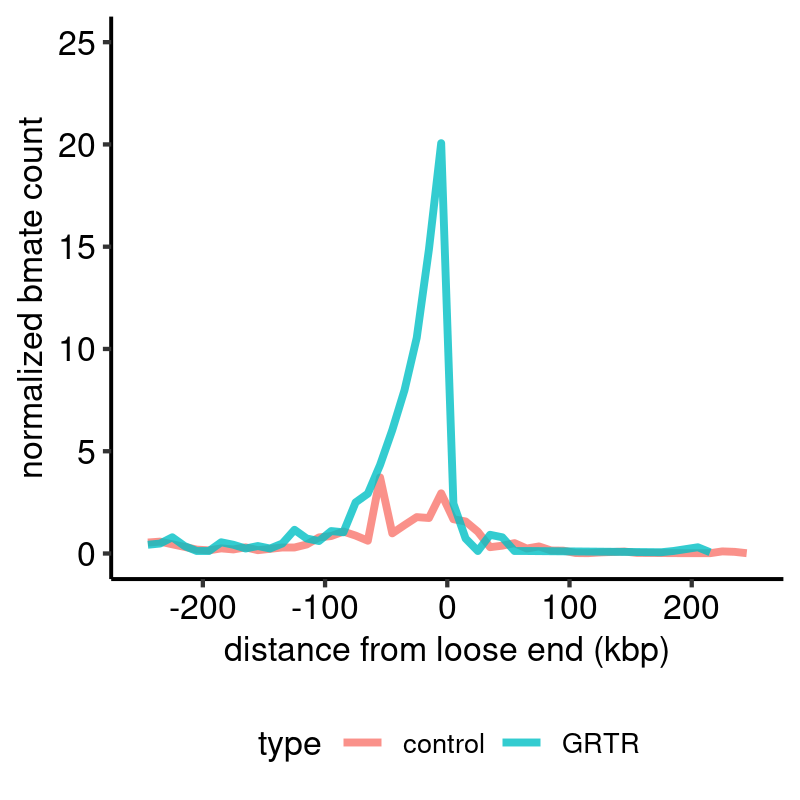

In [94]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [95]:
fig.3d.dt = as.data.table(pt$data)
head(fig.3d.dt)

bin    type    n   norm.factor norm.n      x  
1 475000 control   1 136         0.007352941 475
2 -35000 control 189 136         1.389705882 -35
3 -25000 control 242 136         1.779411765 -25
4 -15000 control 236 136         1.735294118 -15
5  -5000 control 400 136         2.941176471  -5
6   5000 control 228 136         1.676470588   5

### Fig. 3d from source

Warning message:
“Removed 63 rows containing missing values (`geom_line()`).”


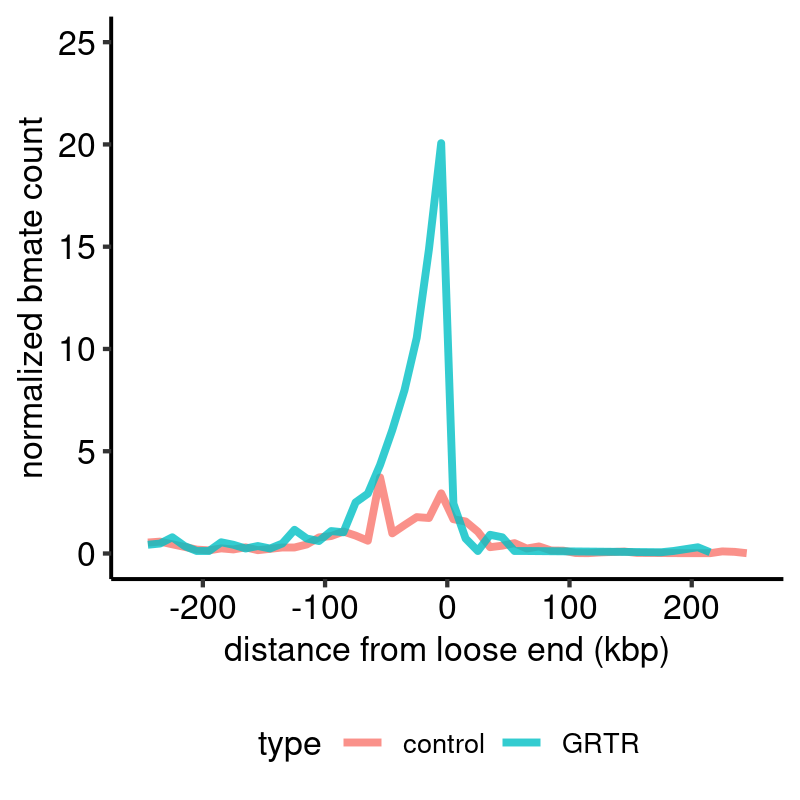

In [134]:
dat = readxl::read_xlsx("./source_data/figure_3.xlsx", sheet = "3D") %>% as.data.table

pt = ggplot(dat, aes(x = x, y = norm.n, color = type)) +
    geom_line(size = 1, alpha = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "normalized bmate count") +
    ggpubr::theme_pubr() +
    ylim(0, 25) +
    xlim(-250, 250) +
    theme(legend.position = "bottom")

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 3e
Distal fusion rate of GRTR+ versus CRTR+ loose ends in linked read profiles (sLRS)

In [99]:
lrs.calls.dt =  readRDS("./data/linked_reads/lrs.rescue.calls.dt.rds")
lrs.loose.dt = readRDS("./data/linked_reads/lrs.rescue.loose.dt.rds")

lrs.calls.dt[, new.annotation := ifelse(somatic == "somatic", annotation, "no contigs")]
lrs.calls.dt[, keep := lrs.loose.dt[lrs.calls.dt, keep]]
lrs.calls.dt[, lrs := lrs.loose.dt[lrs.calls.dt, linkedsv]]
lrs.calls.dt[, label := ifelse(g_telomeric, "GRTR", ifelse(c_telomeric, "CRTR", "other"))]
lrs.calls.dt[is.na(label), label := "other"]

bp.dt = lrs.calls.dt[, .(n.lrs = sum(lrs, na.rm = TRUE), 
                         n.samples = .N, frac = sum(lrs, na.rm = TRUE) / .N), 
                     by = label]
bp.dt[, ci.lower := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.lower}, n.lrs, n.samples))]
bp.dt[, ci.upper := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.upper}, n.lrs, n.samples))]

bp.dt[, paper.factors := ordered(label, levels = c("GRTR", "CRTR", "other"))]

bp = ggplot(bp.dt, aes(x = paper.factors, y = frac)) + 
geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), 
              width = 0.2, position = position_dodge(0.9)) + 
geom_bar(stat = "identity") + 
labs(x = "loose end type", y = "fraction rescued") + 
ggpubr::theme_pubr()




In [100]:
lrs.calls.dt[(label == "GRTR" | label == "CRTR"), 
             length(unique(sample))]

[1] 14

In [101]:
head(bp.dt)

label n.lrs n.samples frac       ci.lower     ci.upper   paper.factors
1 other 575   3416      0.16832553 0.1560107186 0.18139415 other        
2 GRTR    1     71      0.01408451 0.0007356522 0.08651859 GRTR         
3 CRTR   13     28      0.46428571 0.2801016666 0.65786850 CRTR

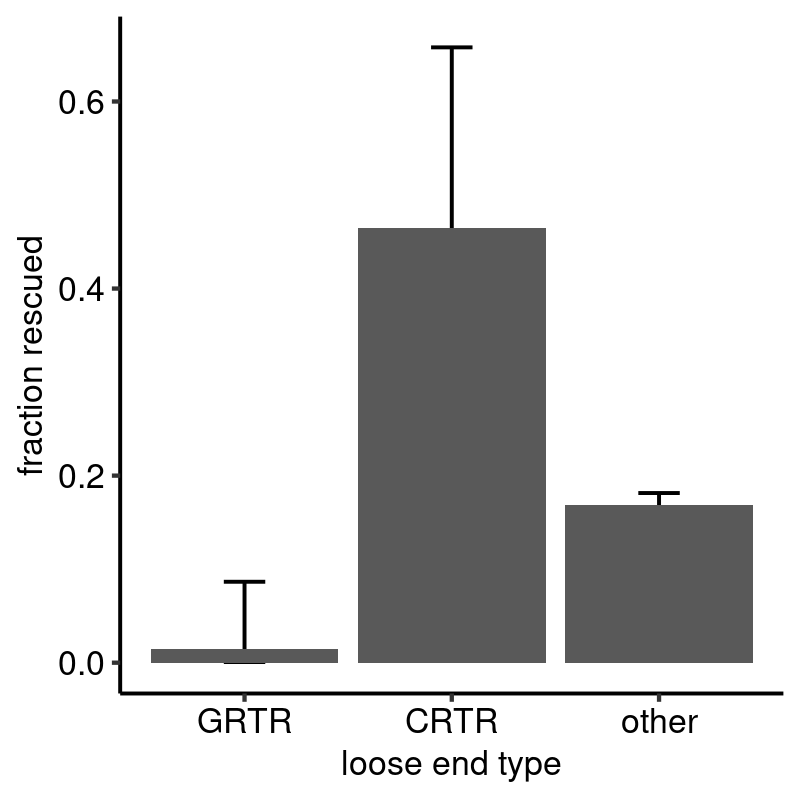

In [102]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
bp

In [103]:
fig.3e.dt = as.data.table(bp$data)
head(fig.3e.dt)

label n.lrs n.samples frac       ci.lower     ci.upper   paper.factors
1 other 575   3416      0.16832553 0.1560107186 0.18139415 other        
2 GRTR    1     71      0.01408451 0.0007356522 0.08651859 GRTR         
3 CRTR   13     28      0.46428571 0.2801016666 0.65786850 CRTR

### Fig. 3e from source

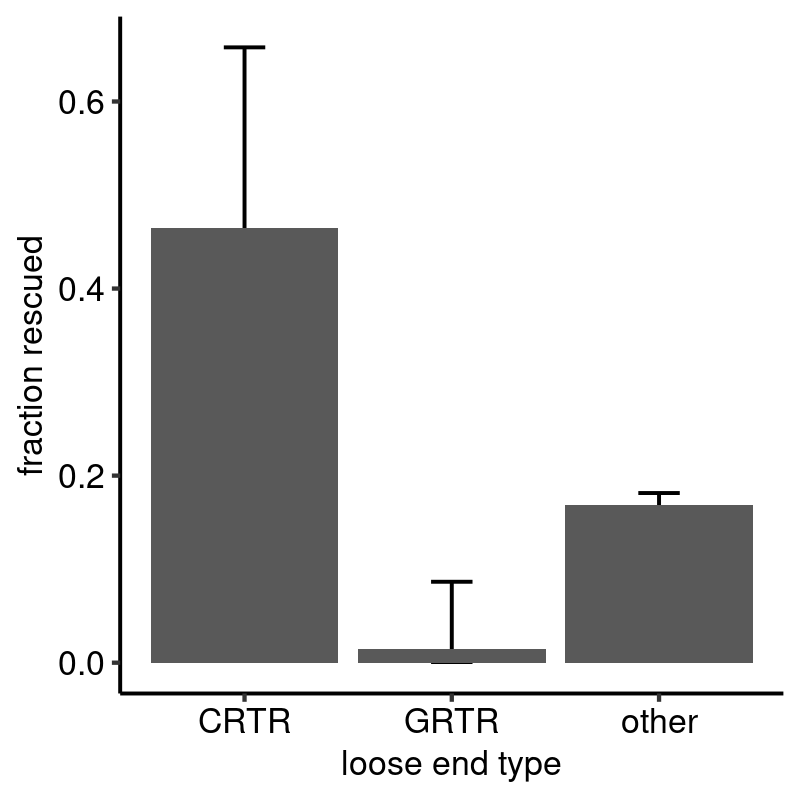

In [136]:
dat = readxl::read_xlsx("./source_data/figure_3.xlsx", sheet = "3E") %>% as.data.table

bp = ggplot(dat, aes(x = paper.factors, y = frac)) + 
geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), 
              width = 0.2, position = position_dodge(0.9)) + 
geom_bar(stat = "identity") + 
labs(x = "loose end type", y = "fraction rescued") + 
ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
bp

## Fig. 3f

In [104]:
telo.pt.dt = readRDS("./data/neotelomeres/neotelomeres.length.estimation.dt.rds")

pt = ggplot(telo.pt.dt[tlength < 1e5], aes(x = category, y = log10(tlength + 1))) +
    scale_y_continuous(breaks = c(0, 1, 2, 3, 4)) +
    geom_boxplot(width = 0.3, outlier.shape = NA) +
    labs(y = "telomere length - log(bp + 1)", x = "category") + 
    ggpubr::theme_pubr()

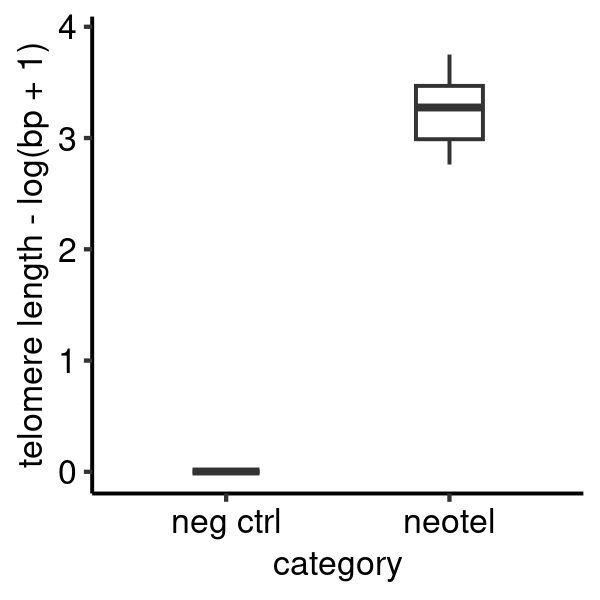

In [105]:
options(repr.plot.height = 3, repr.plot.width = 3, repr.plot.res = 200)
pt

In [106]:
fig.3f.dt = as.data.table(pt$data)
head(fig.3f.dt)

loose.end     sample          tlength  category
1 10:106362531+ G16385.NCI-H661    0.000 neg ctrl
2 10:38791006-  G16385.NCI-H661 1196.541 neg ctrl
3 10:68345007+  G16385.NCI-H661    0.000 neg ctrl
4 12:37913007+  G16385.NCI-H661    0.000 neg ctrl
5 13:52821499-  G16385.NCI-H661    0.000 neg ctrl
6 14:26225007+  G16385.NCI-H661    0.000 neg ctrl

### Fig. 3f from source

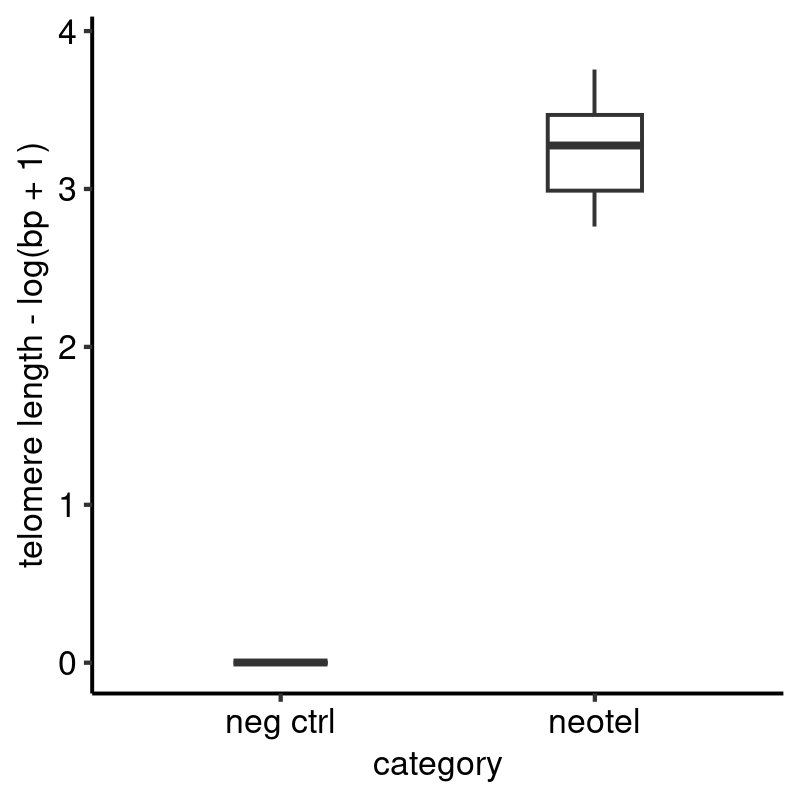

In [137]:
dat = readxl::read_xlsx("./source_data/figure_3.xlsx", sheet = "3F") %>% as.data.table

pt = ggplot(dat, aes(x = category, y = log10(tlength + 1))) +
    scale_y_continuous(breaks = c(0, 1, 2, 3, 4)) +
    geom_boxplot(width = 0.3, outlier.shape = NA) +
    labs(y = "telomere length - log(bp + 1)", x = "category") + 
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 3j
Association between presence of GRTR+ loose ends vs. mutation and expression of ATRX and TERT

In [107]:
bp.frac.dt = readRDS("./data/neotelomeres/figure.3g.atrx.telomerase.crtr.grtr.bp.dt.rds")
fisher.test.dt = readRDS("./data/neotelomeres/figure.3g.atrx.telomerase.crtr.grtr.fisher.test.rds")

pt = ggplot(bp.frac.dt, aes(x = x, y = frac, fill = x)) +
    geom_bar(stat = "identity") +
    facet_grid(cols = vars(column.name), rows = vars(row.name)) +
    geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    ggpubr::stat_pvalue_manual(data = fisher.test.dt, y.position = 0.75, label = "stars") +
    ggpubr::theme_pubr() +
    ylim(0, 1) +
    theme(legend.position = "none")

In [108]:
bp.frac.dt[row.name == "grtr_pos"]

column.name  row.name x     n.total n.pos frac       ci.lower   ci.upper 
1 atrx.lowexp  grtr_pos FALSE  508     57   0.11220472 0.08674483 0.1436924
2 atrx.lowexp  grtr_pos  TRUE   32     12   0.37500000 0.21664195 0.5625041
3 tert.lowexp  grtr_pos FALSE  465     41   0.08817204 0.06473268 0.1186381
4 tert.lowexp  grtr_pos  TRUE   75     28   0.37333333 0.26659412 0.4931479
5 atrx.mut     grtr_pos FALSE 1097    153   0.13947129 0.11979949 0.1617150
6 atrx.mut     grtr_pos  TRUE   72     26   0.36111111 0.25366382 0.4834845
7 tert.or.atrx grtr_pos FALSE  413     30   0.07263923 0.05034135 0.1031885
8 tert.or.atrx grtr_pos  TRUE  152     45   0.29605263 0.22624815 0.3763606

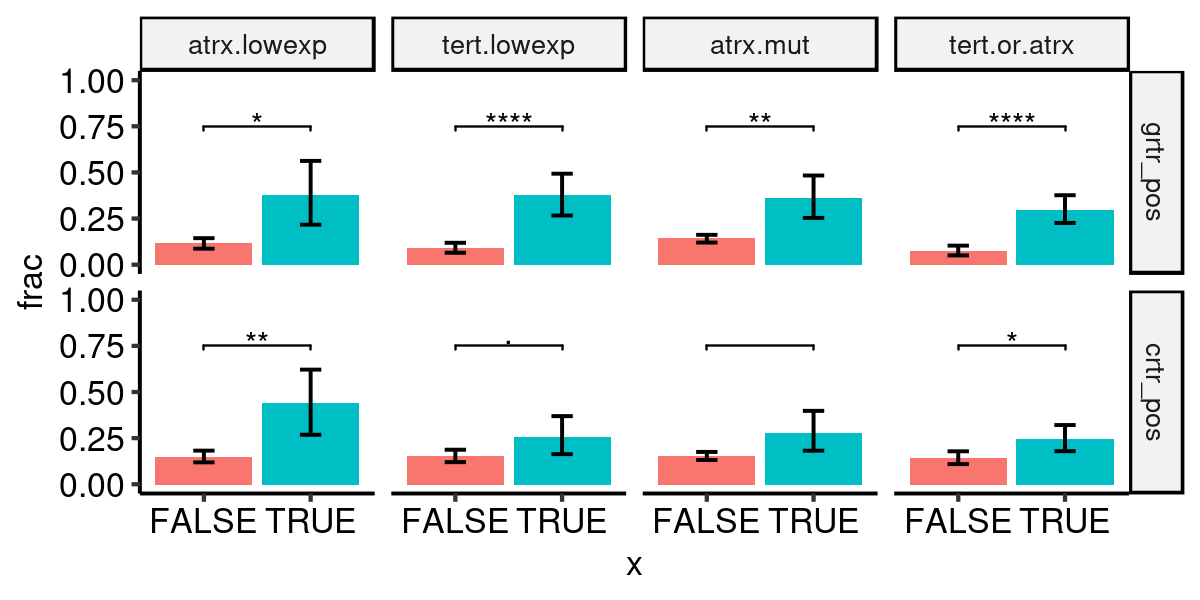

In [109]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

In [110]:
## the same plot but just with GRTR+ loose ends
## which is what's in the actual paper
pt = ggplot(bp.frac.dt[row.name == "grtr_pos"], aes(x = x, y = frac, fill = x)) +
    geom_bar(stat = "identity") +
    facet_grid(cols = vars(column.name)) +
    geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    ggpubr::stat_pvalue_manual(data = fisher.test.dt, y.position = 0.75, label = "stars") +
    ggpubr::theme_pubr() +
    ylim(0, 1) +
    theme(legend.position = "none")

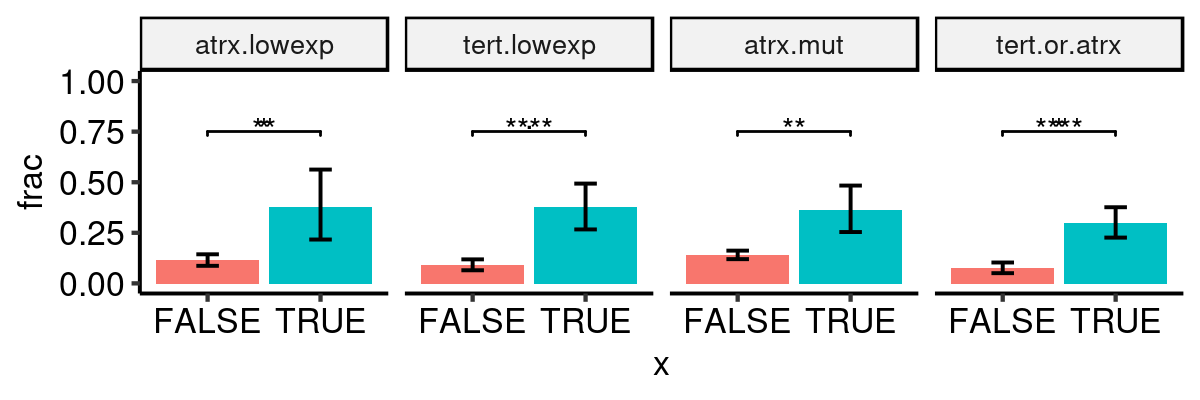

In [111]:
options(repr.plot.height = 2, repr.plot.width = 6, repr.plot.res = 200)
pt

In [112]:
fisher.test.dt[row.name == "grtr_pos"]

column.name  row.name p        group1 group2 y     y.position p.pretty stars
1 atrx.lowexp  grtr_pos 3.01e-02 TRUE   FALSE  FALSE 0.8        3.01e-02 *    
2 tert.lowexp  grtr_pos 2.93e-05 TRUE   FALSE  FALSE 0.8        2.93e-05 **** 
3 atrx.mut     grtr_pos 4.83e-03 TRUE   FALSE  FALSE 0.8        4.83e-03 **   
4 tert.or.atrx grtr_pos 8.25e-05 TRUE   FALSE  FALSE 0.8        8.25e-05 **** 
  x    
1 FALSE
2 FALSE
3 FALSE
4 FALSE

In [113]:
fig.3j.dt = as.data.table(pt$data)
head(fig.3j.dt)

column.name row.name x     n.total n.pos frac       ci.lower   ci.upper 
1 atrx.lowexp grtr_pos FALSE  508     57   0.11220472 0.08674483 0.1436924
2 atrx.lowexp grtr_pos  TRUE   32     12   0.37500000 0.21664195 0.5625041
3 tert.lowexp grtr_pos FALSE  465     41   0.08817204 0.06473268 0.1186381
4 tert.lowexp grtr_pos  TRUE   75     28   0.37333333 0.26659412 0.4931479
5 atrx.mut    grtr_pos FALSE 1097    153   0.13947129 0.11979949 0.1617150
6 atrx.mut    grtr_pos  TRUE   72     26   0.36111111 0.25366382 0.4834845

### Fig. 3j from source

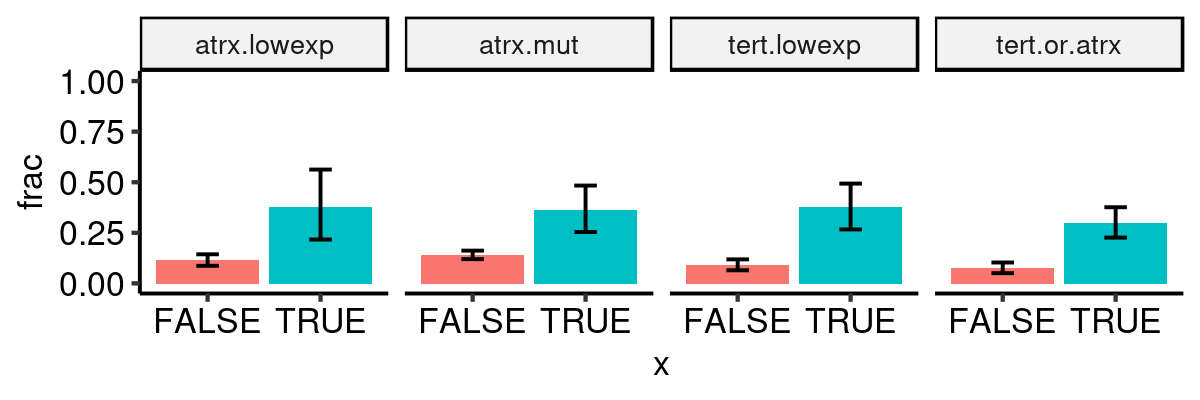

In [139]:
dat = readxl::read_xlsx("./source_data/figure_3.xlsx", sheet = "3J") %>% as.data.table

pt = ggplot(dat, aes(x = x, y = frac, fill = x)) +
    geom_bar(stat = "identity") +
    facet_grid(cols = vars(column.name)) +
    geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    ## ggpubr::stat_pvalue_manual(data = fisher.test.dt, y.position = 0.75, label = "stars") +
    ggpubr::theme_pubr() +
    ylim(0, 1) +
    theme(legend.position = "none")

options(repr.plot.height = 2, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 3k
Association between GRTR+ loose ends and tumor type

In [114]:
tr.tt.glm.dt = readRDS("./data/neotelomeres/tr.tumor.type.glm.dt.rds")

tr.tt.glm.dt[, p.adj := p.adjust(p, method = "bonferroni")]
tr.tt.glm.dt[, log.odds := log2(estimate)]
tr.tt.glm.dt[, log.p := -log10(p)]
tr.tt.glm.dt[, label := ifelse(abs(log.odds) > 1 & -log10(p.adj) > 1, tumor_type_final, "")]
tr.tt.glm.dt[, color := ifelse(abs(log.odds) > 1 & -log10(p.adj) > 1, "red", "gray")]

pt = ggplot(tr.tt.glm.dt, aes(x = log.odds, y = log.p)) +
    geom_point(size = 0.6, aes(color = color)) +
    ggrepel::geom_label_repel(aes(label = label), box.padding = 0.15, point.padding = 0.1, segment.color = 'grey50', max.overlaps = 10) +
    labs(x = "fold change", y = "-logp", title = "tumor type") +
    geom_vline(xintercept = 1, linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = -1, linetype = "dashed", size = 0.5) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    theme_bw() +
    xlim(-5, 5) + ylim(0, 10) +
    scale_color_identity() +
    facet_grid(cols = vars(type)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_label_repel()`).”


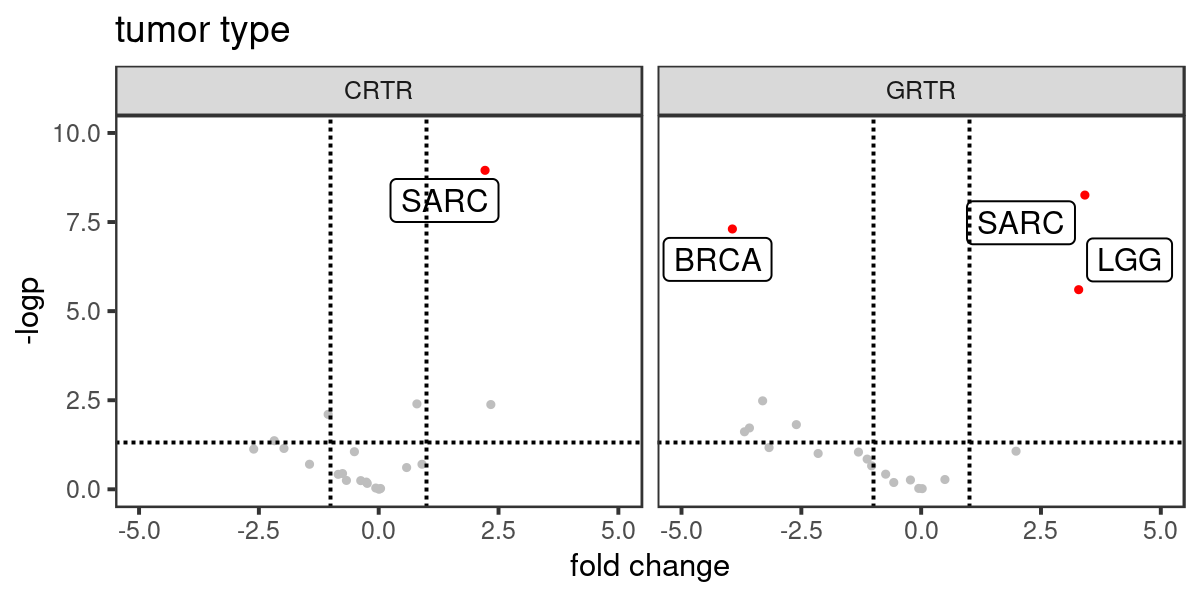

In [115]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

In [116]:
fig.3k.dt = as.data.table(pt$data)
head(fig.3k.dt)

name  method                    p      estimate  ci.lower   ci.upper
1  ESAD Negative Binomial(0.6416) 0.0881 0.7036923 0.46989220 1.053822
2  GBM  Negative Binomial(0.6414) 0.0745 0.1640571 0.02251240 1.195551
3  OV   Negative Binomial(0.6281) 0.6270 0.8357118 0.40551400 1.722294
4  LUSC Negative Binomial(0.6272) 0.5700 0.7713222 0.31479795 1.889904
5  LUAD Negative Binomial(0.6266) 0.9210 0.9584849 0.41371275 2.220607
6  COAD Negative Binomial(0.631)  0.0714 0.2540767 0.05730384 1.126538
  effect              tumor_type_final type p.adj log.odds    log.p      label
1 0.704 [0.47-1.05]   ESAD             CRTR 1     -0.50698343 1.05502409      
2 0.164 [0.0225-1.2]  GBM              CRTR 1     -2.60773014 1.12784373      
3 0.836 [0.406-1.72]  OV               CRTR 1     -0.25892252 0.20273246      
4 0.771 [0.315-1.89]  LUSC             CRTR 1     -0.37459444 0.24412514      
5 0.958 [0.414-2.22]  LUAD             CRTR 1     -0.06117244 0.03574037      
6 0.254 [0.0573-1.13] COAD             CRTR 1     -1.97666413 1.14630179      
  color
1 gray 
2 gray 
3 gray 
4 gray 
5 gray 
6 gray

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 38 rows containing missing values (`geom_label_repel()`).”


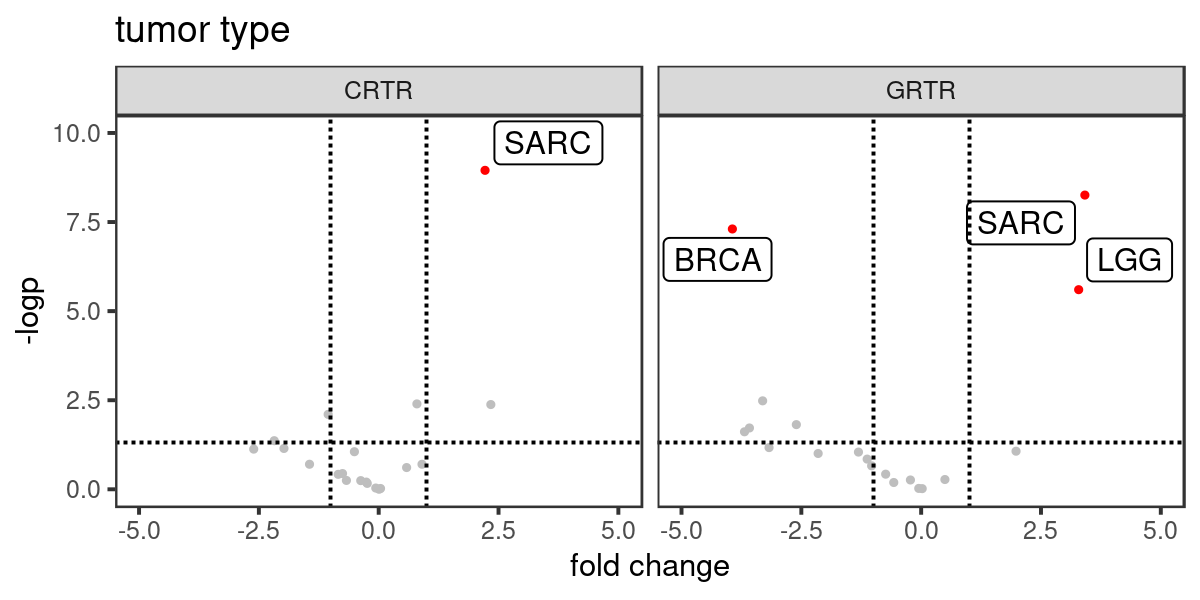

In [141]:
dat = readxl::read_xlsx(path = "./source_data/figure_3.xlsx", sheet = "3K") %>% as.data.table

pt = ggplot(dat, aes(x = log.odds, y = log.p)) +
    geom_point(size = 0.6, aes(color = color)) +
    ggrepel::geom_label_repel(aes(label = label), box.padding = 0.15, point.padding = 0.1, segment.color = 'grey50', max.overlaps = 10) +
    labs(x = "fold change", y = "-logp", title = "tumor type") +
    geom_vline(xintercept = 1, linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = -1, linetype = "dashed", size = 0.5) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    theme_bw() +
    xlim(-5, 5) + ylim(0, 10) +
    scale_color_identity() +
    facet_grid(cols = vars(type)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt


## Fig. 3l
Event type associations of CRTR+ and GRTR+ loose ends

In [117]:
tr.ev.glm.dt = readRDS("./data/neotelomeres/tr.events.glm.dt.co_occur.rds")

pt = ggplot(tr.ev.glm.dt, aes(x = log.odds, y = log.p)) +
    geom_point(size = 0.6, aes(color = color)) +
    ggrepel::geom_label_repel(aes(label = label), box.padding = 0.15, point.padding = 0.1, segment.color = 'grey50', max.overlaps = 10) +
    labs(x = "fold change", y = "-logp", title = "complex SV event type") +
    geom_vline(xintercept = 1, linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = -1, linetype = "dashed", size = 0.5) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    theme_bw() +
    xlim(-3, 3) + ylim(0, 12) +
    scale_color_identity() +
    facet_grid(cols = vars(type)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

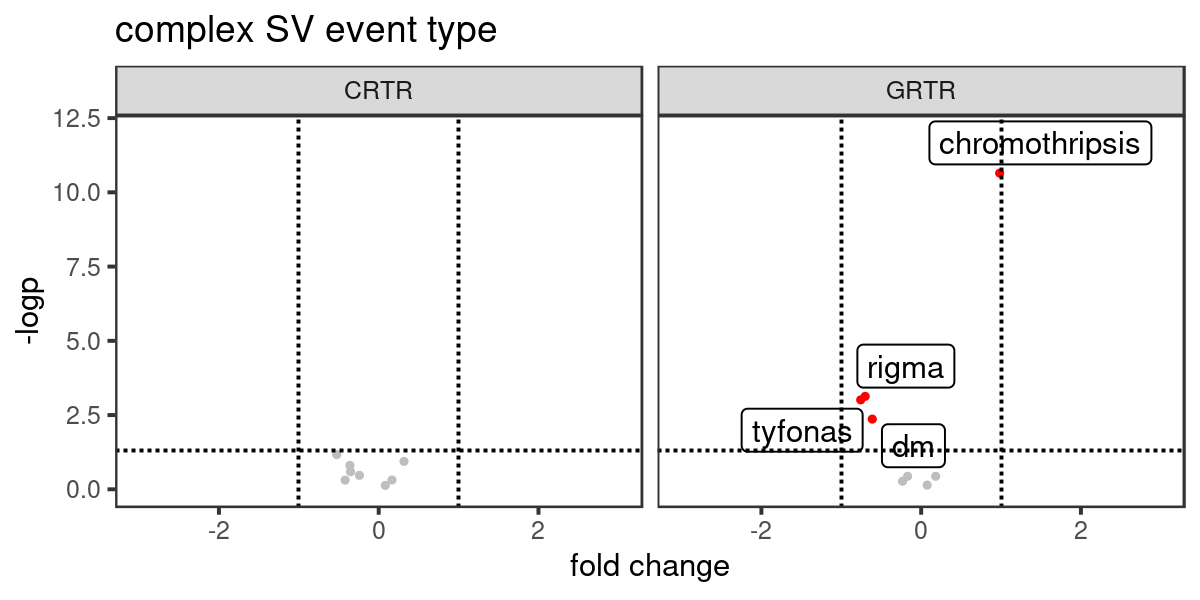

In [118]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

In [119]:
fig.3l.dt = as.data.table(pt$data)
head(fig.3l.dt)

name                method  p     estimate  ci.lower  ci.upper
1  bfbTRUE            poisson 0.339 0.8461350 0.6008569 1.191539
2  chromoplexyTRUE    poisson 0.485 1.1218020 0.8126955 1.548476
3  chromothripsisTRUE poisson 0.115 1.2451890 0.9479261 1.635672
4  cpxdmTRUE          poisson 0.490 0.7472273 0.3266590 1.709271
5  tyfonasTRUE        poisson 0.256 0.7831546 0.5135694 1.194252
6  dmTRUE             poisson 0.735 1.0593500 0.7581651 1.480182
  effect             event.type     type p.adj     log.odds    log.p     label
1 0.846 [0.601-1.19] bfb            CRTR 0.5309091 -0.24104028 0.4698003      
2 1.12 [0.813-1.55]  chromoplexy    CRTR 0.6030769  0.16581808 0.3142583      
3 1.25 [0.948-1.64]  chromothripsis CRTR 0.3066667  0.31636477 0.9393022      
4 0.747 [0.327-1.71] cpxdm          CRTR 0.6030769 -0.42038098 0.3098039      
5 0.783 [0.514-1.19] tyfonas        CRTR 0.5120000 -0.35263090 0.5917600      
6 1.06 [0.758-1.48]  dm             CRTR 0.7350000  0.08317932 0.1337127      
  color
1 gray 
2 gray 
3 gray 
4 gray 
5 gray 
6 gray

### Fig. 3L from source

Warning message:
“Removed 12 rows containing missing values (`geom_label_repel()`).”


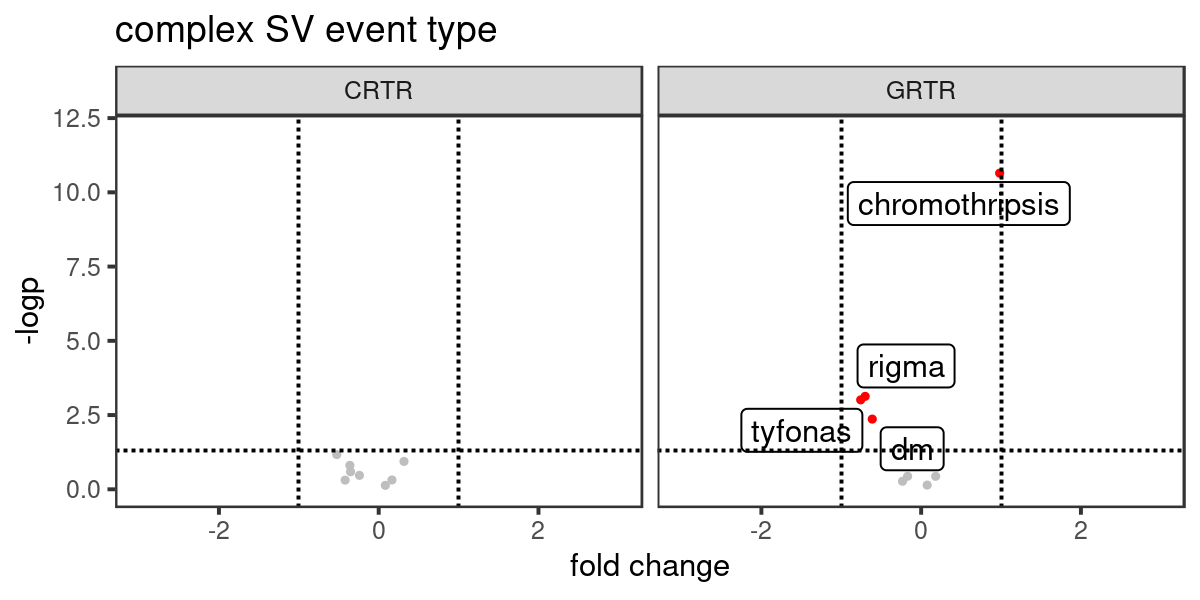

In [142]:
dat = readxl::read_xlsx(path = "./source_data/figure_3.xlsx", sheet = "3L") %>% as.data.table

pt = ggplot(dat, aes(x = log.odds, y = log.p)) +
    geom_point(size = 0.6, aes(color = color)) +
    ggrepel::geom_label_repel(aes(label = label), box.padding = 0.15, point.padding = 0.1, segment.color = 'grey50', max.overlaps = 10) +
    labs(x = "fold change", y = "-logp", title = "complex SV event type") +
    geom_vline(xintercept = 1, linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = -1, linetype = "dashed", size = 0.5) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    theme_bw() +
    xlim(-3, 3) + ylim(0, 12) +
    scale_color_identity() +
    facet_grid(cols = vars(type)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 3 source data

In [126]:
writexl::write_xlsx(x = list(`3A` = fig.3a.dt,
                             `3C` = fig.3c.dt,
                             `3D` = fig.3d.dt,
                             `3E` = fig.3e.dt,
                             `3F` = fig.3f.dt,
                             `3J` = fig.3j.dt,
                             `3K` = fig.3k.dt,
                             `3L` = fig.3l.dt),
                    path = "./source_data/figure_3.xlsx",
                    col_names = TRUE)

# Figure 4
Structural variants generated by aberrant homologous recombination repair.

## Fig. 4c
Segment width associated with copy neutral LOH due to mitotic recombination

In [144]:
cnloh.ranges = readRDS("./data/cnloh/cnloh.ranges.rds")
loh.ranges= readRDS("./data/cnloh/loh.ranges.rds")
fake.cnloh.ranges = readRDS("./data/cnloh/fake.cnloh.ranges.rds") ## this is just "segmental UPD"

## convert to Kbp
cnloh.width.per.segment = cnloh.ranges[, .(width.kbp = width / 1e3)]
loh.width.per.segment = loh.ranges[, .(width.kbp = width / 1e3)]
fake.cnloh.width.per.segment = fake.cnloh.ranges[, .(width.kbp = width / 1e3)]

## merge these by sample
pt.dt = rbind(cnloh.width.per.segment[, type := "cnloh"],
              fake.cnloh.width.per.segment[, type := "upd"],
              loh.width.per.segment[, type := "loh"],
              fill = TRUE)

pt.dt[, type.level := ordered(type, levels = c("cnloh", "upd", "loh"))]

vp = ggplot(pt.dt, aes(y = width.kbp, x = type.level, fill = type.level)) +
    geom_violin(trim = FALSE, scale = "width", color = "white", size = 0.1) +
    labs(x = "", y = "width (Mbp)", title = "CNLOH width per sample") +
    geom_boxplot(width = 0.1, outlier.shape = NA, size = 0.3, color = "white") +
    theme_bw() +
    scale_y_continuous(trans = "log1p", breaks = c(0, 100, 10000, 1000000)) + 
    ggpubr::theme_pubr()

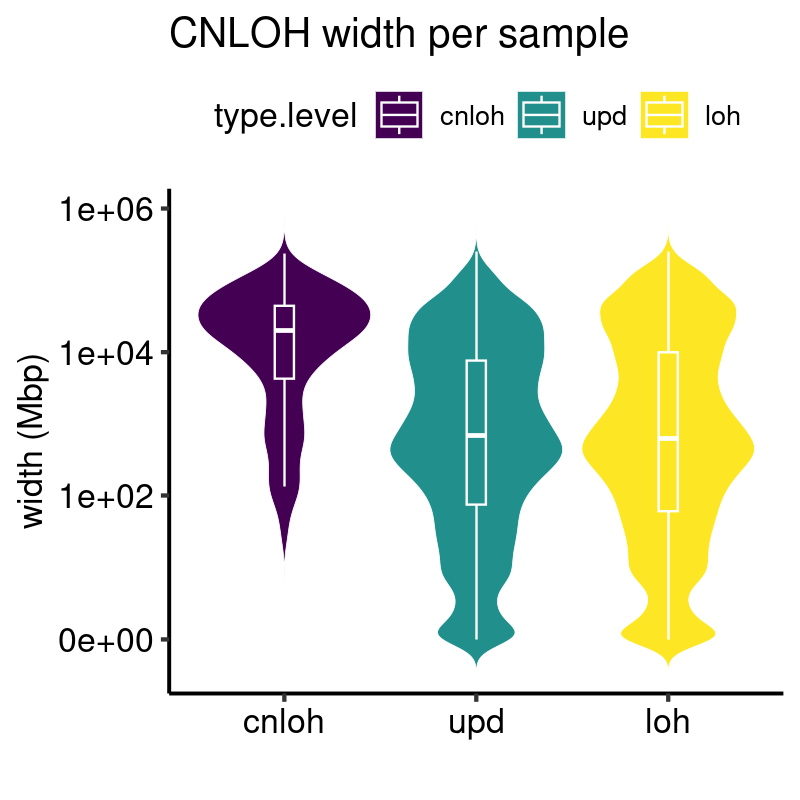

In [145]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
vp

In [146]:
fig.4c.dt = as.data.table(vp$data)
head(fig.4c.dt)

width.kbp type  type.level
1 21118.709 cnloh cnloh     
2   143.624 cnloh cnloh     
3 20230.525 cnloh cnloh     
4 39600.839 cnloh cnloh     
5  8105.346 cnloh cnloh     
6   117.134 cnloh cnloh

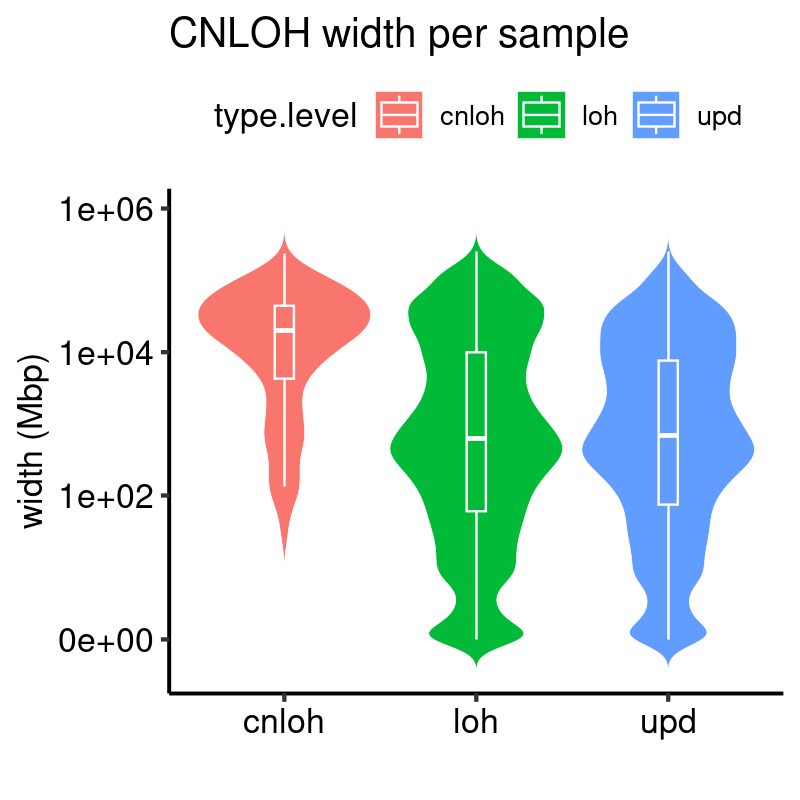

In [164]:
dat = readxl::read_xlsx("./source_data/figure_4.xlsx", sheet = "4C") %>% as.data.table

vp = ggplot(dat, aes(y = width.kbp, x = type.level, fill = type.level)) +
    geom_violin(trim = FALSE, scale = "width", color = "white", size = 0.1) +
    labs(x = "", y = "width (Mbp)", title = "CNLOH width per sample") +
    geom_boxplot(width = 0.1, outlier.shape = NA, size = 0.3, color = "white") +
    theme_bw() +
    scale_y_continuous(trans = "log1p", breaks = c(0, 100, 10000, 1000000)) + 
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
vp

## Fig. 4d
Fractional contribution of cnLOH, UPD, and other (not copy neutral LOH) to loss of heterozygosity

In [147]:
cnloh.ranges = readRDS("./data/cnloh/cnloh.ranges.rds")
loh.ranges = readRDS("./data/cnloh/loh.ranges.rds")
fake.cnloh.ranges = readRDS("./data/cnloh/fake.cnloh.ranges.rds")

## total number of events as a stacked barplot
loh.event.bp.dt = data.table(loh.type = ordered(c("loh", "upd", "mr"),
                                                levels = c("loh", "upd", "mr")),
                             segment.count = c(nrow(loh.ranges),
                                               nrow(fake.cnloh.ranges),
                                               nrow(cnloh.ranges)))

loh.event.bp = ggplot(loh.event.bp.dt, aes(x = 1, y = segment.count, fill = loh.type)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (loh.event.bp.dt[, sum(segment.count)]), name = "segment count")) +
    labs(x = "", y = "frac") +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank()) +
    theme(legend.position = "right")

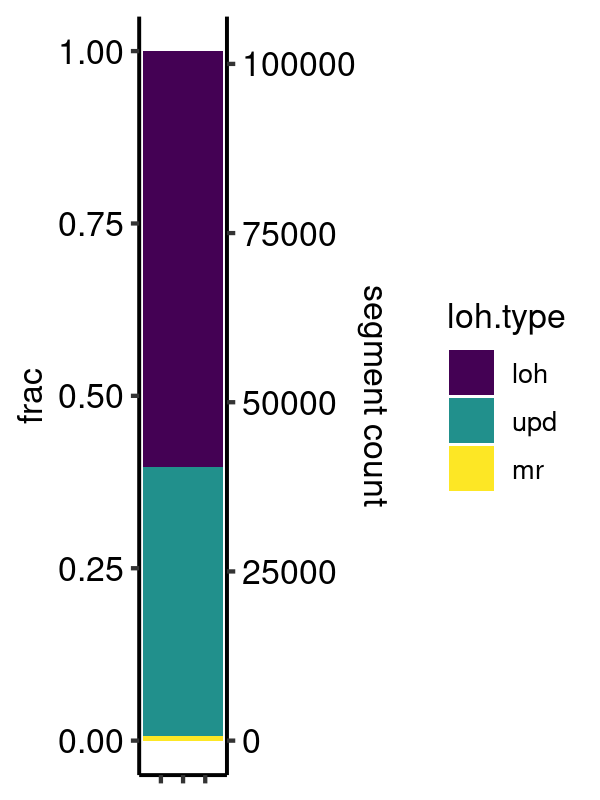

In [148]:
options(repr.plot.height = 4, repr.plot.width = 3, repr.plot.res = 200)
loh.event.bp

In [149]:
fig.4d_segments.dt = as.data.table(loh.event.bp$data)
head(fig.4d_segments.dt)

loh.type segment.count
1 loh      61469        
2 upd      39877        
3 mr         545

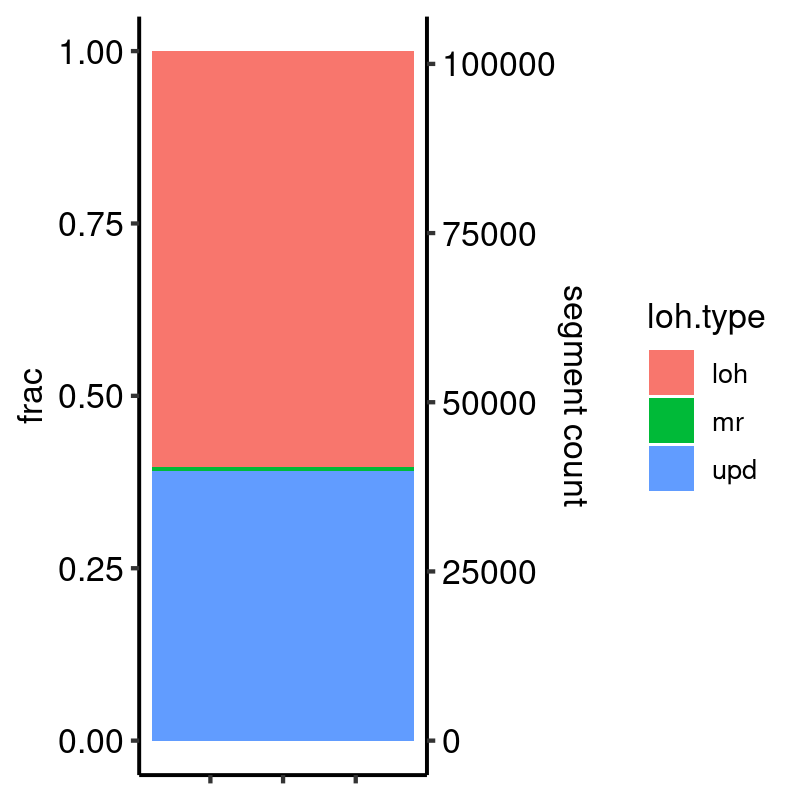

In [165]:
dat = readxl::read_xlsx("./source_data/figure_4.xlsx", sheet = "4D_segments") %>% as.data.table

loh.event.bp = ggplot(dat, aes(x = 1, y = segment.count, fill = loh.type)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (dat[, sum(segment.count)]), name = "segment count")) +
    labs(x = "", y = "frac") +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank()) +
    theme(legend.position = "right")

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
loh.event.bp

In [150]:
## total width of events as a stacked barplot
loh.width.bp.dt = data.table(loh.type = ordered(c("loh", "upd", "mr"),
                                                levels = c("loh", "upd", "mr")),
                             segment.width = c(sum(loh.ranges[, width / 1e9]),
                                               sum(fake.cnloh.ranges[, width / 1e9]),
                                               sum(cnloh.ranges[, width / 1e9])))

loh.event.bp = ggplot(loh.width.bp.dt, aes(x = 1, y = segment.width, fill = loh.type)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (loh.width.bp.dt[, sum(segment.width)]), name = "segment width (Gbp)")) +
    labs(x = "", y = "frac") +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank()) +
    theme(legend.position = "right")

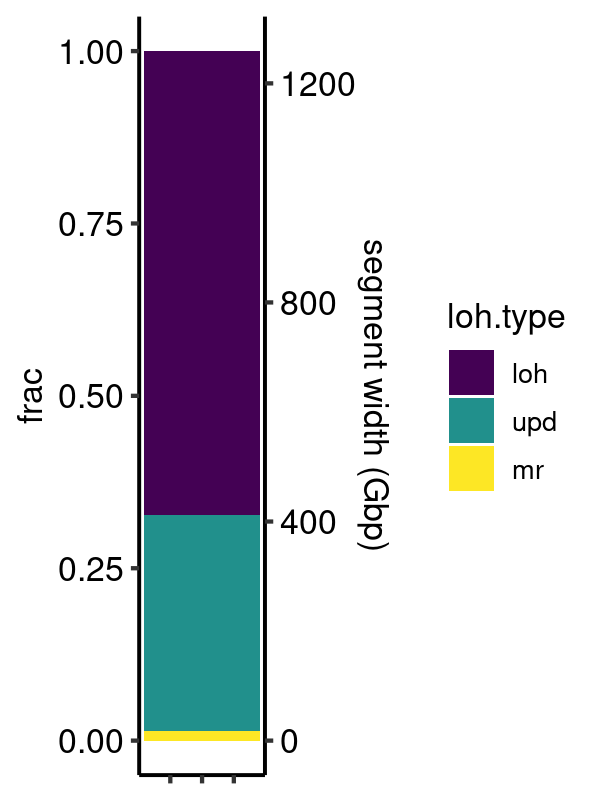

In [151]:
options(repr.plot.height = 4, repr.plot.width = 3, repr.plot.res = 200)
loh.event.bp

In [152]:
fig.4d_width.dt = as.data.table(loh.event.bp$data)
head(fig.4d_width.dt)

loh.type segment.width
1 loh      847.46326    
2 upd      394.27161    
3 mr        17.18276

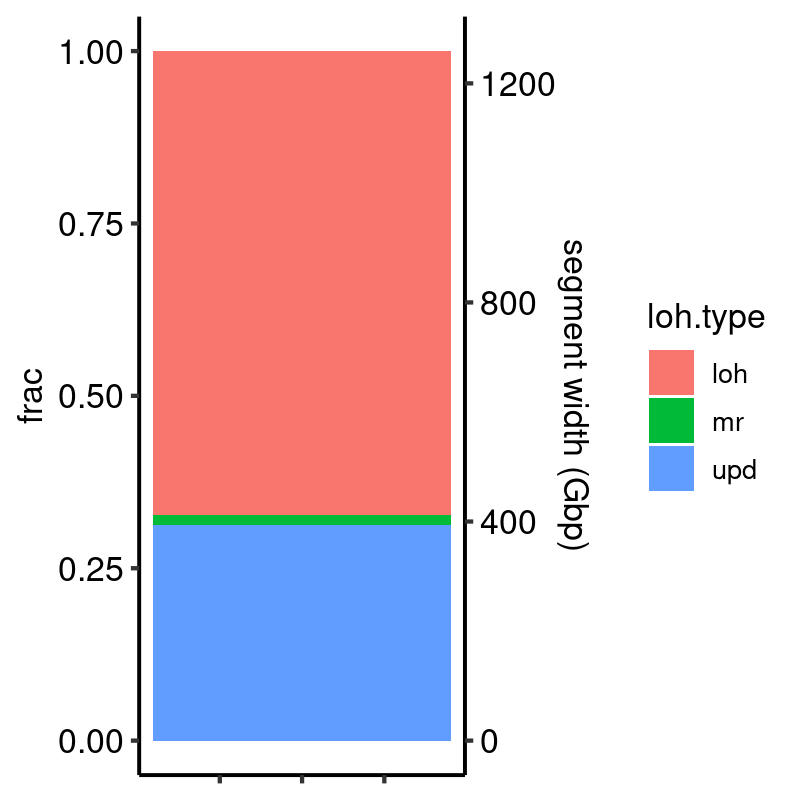

In [166]:
dat = readxl::read_xlsx("./source_data/figure_4.xlsx", sheet = "4D_width") %>% as.data.table

loh.event.bp = ggplot(dat, aes(x = 1, y = segment.width, fill = loh.type)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (dat[, sum(segment.width)]), name = "segment width (Gbp)")) +
    labs(x = "", y = "frac") +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank()) +
    theme(legend.position = "right")

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
loh.event.bp

## Fig. 4f
Benchmarking detection of NAHR-associated loose ends

In [153]:
lp.nahr.sv.dt = readRDS("./data/nahr/lp.nahr.sv.dt")
sim.dt = readRDS("./data/benchmarking/sim.samples.dt.rds")

lp.nahr.sv.dt[, purity := sim.dt[pair, purity]]

pt = ggplot(lp.nahr.sv.dt[purity > 0.5, ], aes(x = n.cncp.gs, y = n.cncp)) +
    geom_point(alpha = 0.5) +
    labs(x = "true number of NAHR breakends", y = "estimated number of NAHR breakends") +
    geom_smooth(method='lm', formula = y ~ x) +
    ggpubr::stat_cor(method = "pearson", label.x = 15, label.y = 10) +
    ggpubr::theme_pubr()

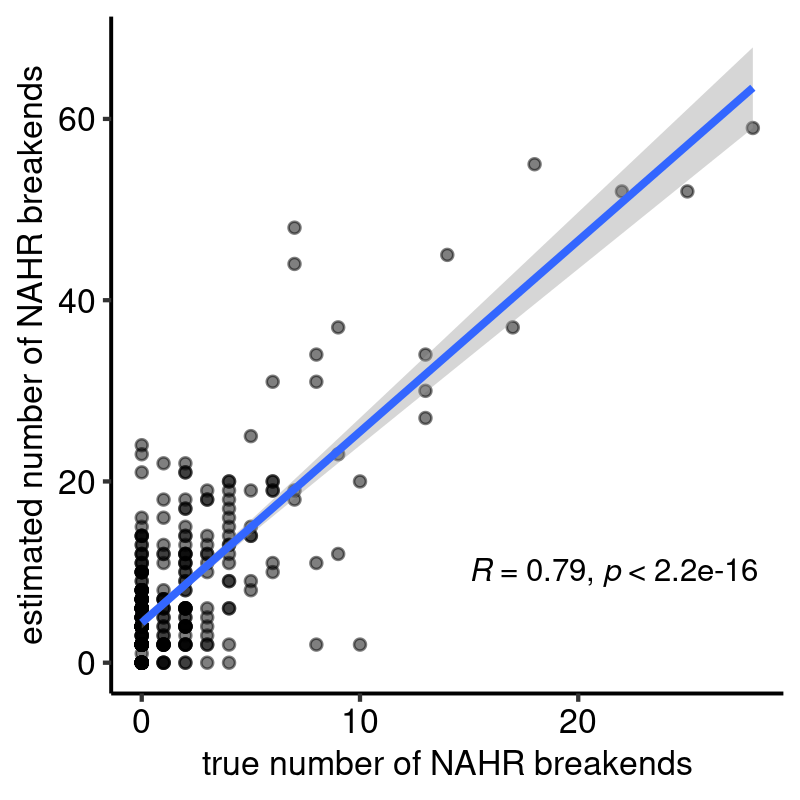

In [154]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [155]:
fig.4f.dt = as.data.table(pt$data)
head(fig.4f.dt)

n.cncp n.cncp.gs tp fp fn precision.cncp recall.cncp f1.cncp pair   
1  2     10        0   2 10 0              0           0       sim_1  
2 10      0        0  10  0 0              0           0       sim_10 
3  2      0        0   2  0 0              0           0       sim_100
4  4      1        0   4  1 0              0           0       sim_101
5  6      0        0   6  0 0              0           0       sim_102
6  6      1        0   6  1 0              0           0       sim_103
  purity   
1 1.0000000
2 0.6043236
3 0.8264763
4 0.8787977
5 0.6152818
6 0.9810101

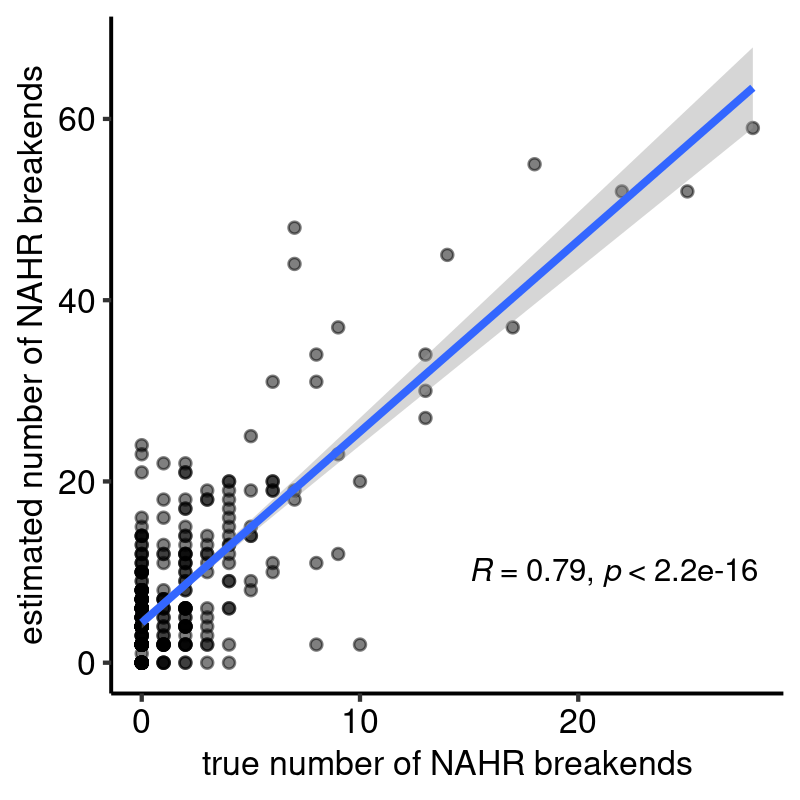

In [168]:
dat = readxl::read_xlsx("./source_data/figure_4.xlsx", sheet = "4F") %>% as.data.table

pt = ggplot(dat, aes(x = n.cncp.gs, y = n.cncp)) +
    geom_point(alpha = 0.5) +
    labs(x = "true number of NAHR breakends", y = "estimated number of NAHR breakends") +
    geom_smooth(method='lm', formula = y ~ x) +
    ggpubr::stat_cor(method = "pearson", label.x = 15, label.y = 10) +
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 4g
Comparison of putative NAHR rates among SRS junctions and loose ends

In [156]:
big.nahr.dt = readRDS("./data/nahr/lrs.srs.full.big.nahr.dt.rds")
big.nahr.pt.dt = readRDS("./data/nahr/lrs.srs.full.big.nahr.pt.dt.rds")

pt = ggplot(big.nahr.pt.dt, aes(x = germline.or.somatic, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    facet_grid(cols = vars(breakend.type)) +
    labs(x = "breakend type", y = "frac putative NAHR") +
    ylim(0, 1) +
    ggpubr::theme_pubr()


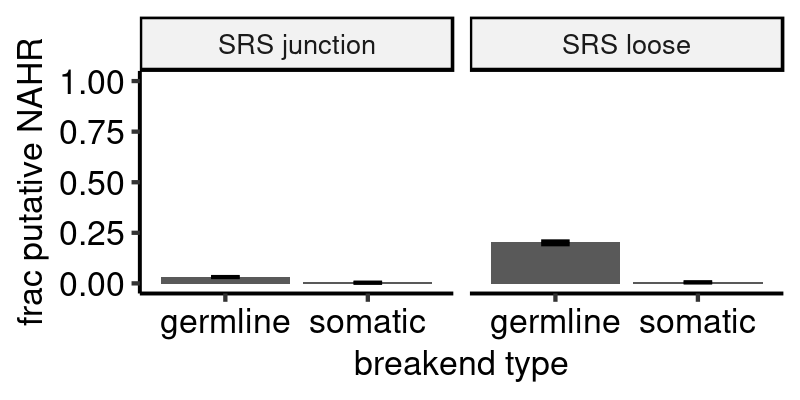

In [157]:
options(repr.plot.height = 2, repr.plot.width = 4, repr.plot.res = 200)
pt

In [158]:
fig.4g.dt = as.data.table(pt$data)
head(fig.4g.dt)

breakend.type germline.or.somatic tot    n.pos frac        ci.lower   
1 SRS loose     somatic              44609  218  0.004886906 0.004270566
2 SRS loose     germline             10965 2196  0.200273598 0.192843430
3 SRS junction  germline            264006 8252  0.031256865 0.030598010
4 SRS junction  somatic             263158  862  0.003275599 0.003062584
  ci.upper   
1 0.005589985
2 0.207914981
3 0.031929400
4 0.003503241

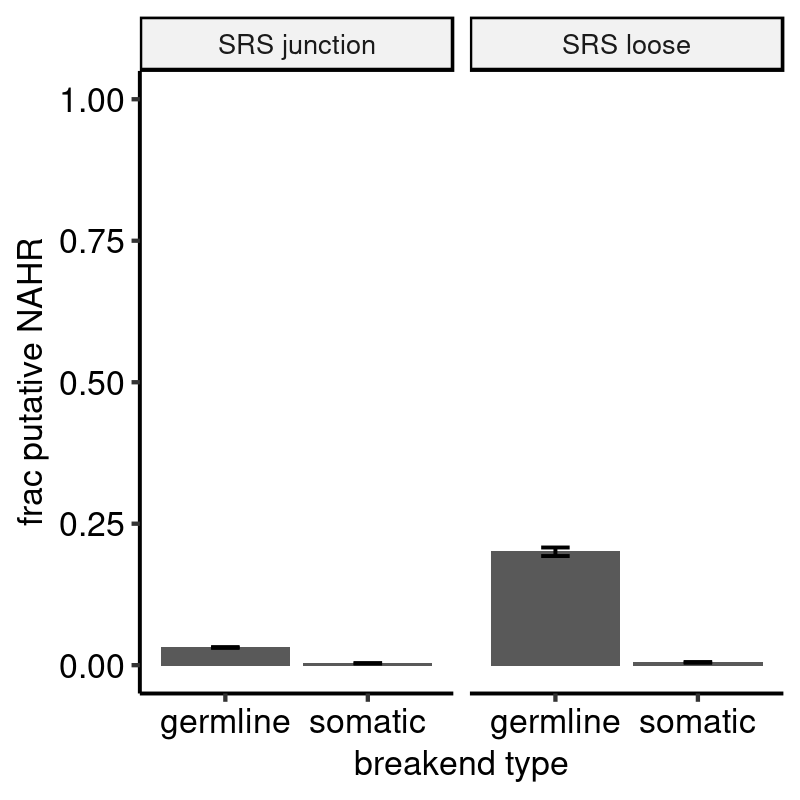

In [169]:
dat = readxl::read_xlsx("./source_data/figure_4.xlsx", sheet = "4G") %>% as.data.table

pt = ggplot(dat, aes(x = germline.or.somatic, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    facet_grid(cols = vars(breakend.type)) +
    labs(x = "breakend type", y = "frac putative NAHR") +
    ylim(0, 1) +
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 4h
Comparison of NAHR rates among nanopore (LRS) junctions, SRS junctions, and SRS loose ends in long read validation cohort.

In [159]:
pt.dt = readRDS("./data/nahr/ont.srs.full.nahr.dt.rds") ## all the breakends
nahr.pt.dt = readRDS("./data/nahr/ont.srs.nahr.pt.dt.rds")

pt = ggplot(nahr.pt.dt, aes(x = germline.or.somatic, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    facet_grid(cols = vars(platform)) +
    labs(x = "breakend type", y = "frac putative NAHR") +
    ylim(0, 1) +
    ggpubr::theme_pubr()

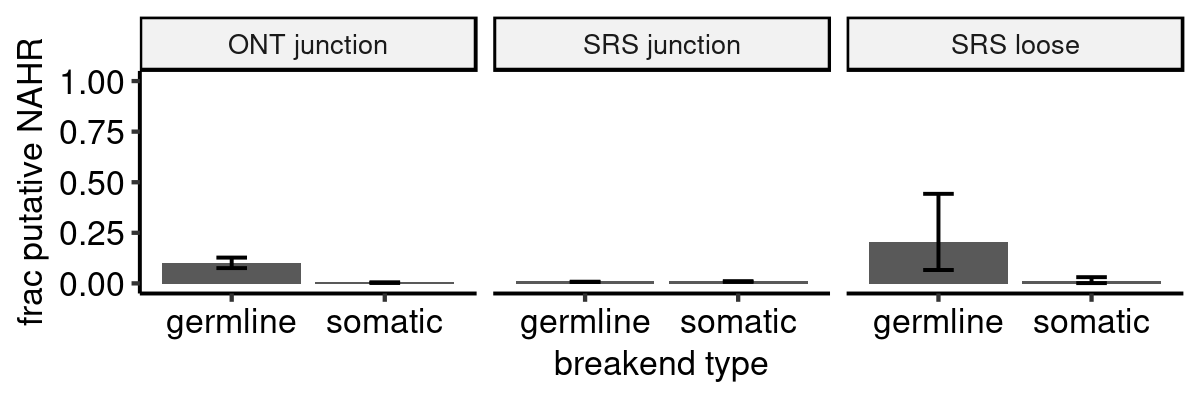

In [160]:
options(repr.plot.height = 2, repr.plot.width = 6, repr.plot.res = 200)
pt

In [161]:
fig.4h.dt = as.data.table(pt$data)
head(fig.4h.dt)

platform     germline.or.somatic n.nahr total frac        ci.lower   
1 ONT junction somatic              18     5544 0.003246753 0.001984961
2 ONT junction germline             54      548 0.098540146 0.075506837
3 SRS junction somatic             104    11626 0.008945467 0.007349824
4 SRS junction germline            584    78646 0.007425680 0.006843157
5 SRS loose    somatic               2      259 0.007722008 0.001338641
6 SRS loose    germline              4       20 0.200000000 0.066106231
  ci.upper   
1 0.005236842
2 0.127365092
3 0.010873624
4 0.008056829
5 0.030641781
6 0.442686245

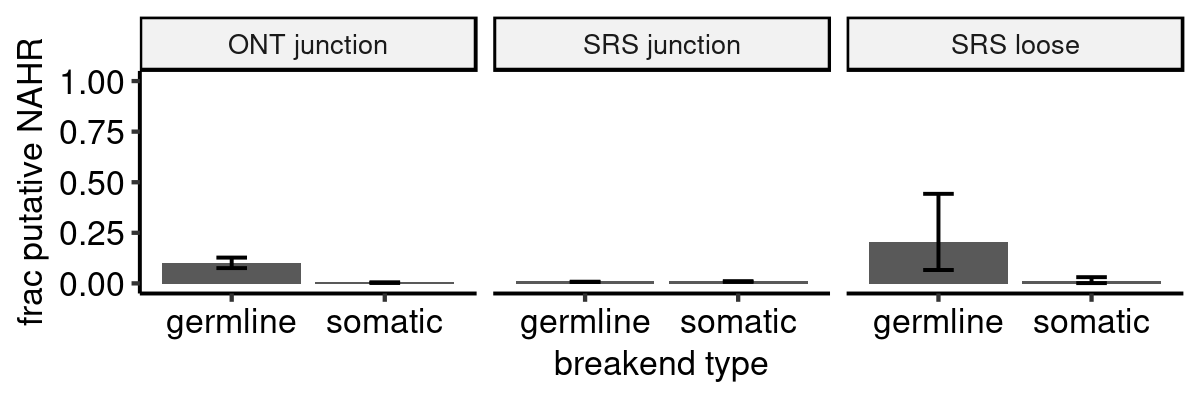

In [171]:
dat = readxl::read_xlsx("./source_data/figure_4.xlsx", sheet = "4H") %>% as.data.table

pt = ggplot(dat, aes(x = germline.or.somatic, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    facet_grid(cols = vars(platform)) +
    labs(x = "breakend type", y = "frac putative NAHR") +
    ylim(0, 1) +
    ggpubr::theme_pubr()

options(repr.plot.height = 2, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 4 source data

In [162]:
writexl::write_xlsx(x = list(`4C` = fig.4c.dt,
                             `4D_segments` = fig.4d_segments.dt,
                             `4D_width` = fig.4d_width.dt,
                             `4F` = fig.4f.dt,
                             `4G` = fig.4g.dt,
                             `4H` = fig.4h.dt),
                    path = "./source_data/figure_4.xlsx",
                    col_names = TRUE)

# Figure 5
T2T extrapolation

## Fig. 5b
Heatmap (zoomed out version of the whole genome, as well as CN-unmappable only zoomed in)

### Zoomed out genome-wide heatmap (left)

In [192]:
big.tiles = readRDS("./data/t2t/big.tiles.rds")
overall.pt.dt = readRDS("./data/t2t/heatmap.dt.10mbp.rds")

ht_opt$message = FALSE ## turn off warnings

smat = sparseMatrix(i = overall.pt.dt[, as.numeric(as.character(bin1))],
                    j = overall.pt.dt[, as.numeric(as.character(bin2))],
                    x = overall.pt.dt[, log10(count)],
                    dims = c(length(big.tiles), length(big.tiles)),
                    index1 = TRUE)

mat = as.matrix(smat)

pal1 = RColorBrewer::brewer.pal(11, "BrBG")
pal2 = colorRampPalette(pal1)(24)
names(pal2) = names(seqlengths(big.tiles))

ha = ComplexHeatmap::HeatmapAnnotation(
    chr = as.character(seqnames(big.tiles)),
    col = list(chr = pal2)
)

col_fun = colorRamp2(c(0,
                       quantile(overall.pt.dt[, log10(count)], 0.9),
                       quantile(overall.pt.dt[, log10(count)], 0.9),
                       quantile(overall.pt.dt[, log10(count)], 0.999)),
                     c("white", "white", "pink", "red"))

split = values(big.tiles)[, "cnu.frac"] >= 0.1

op = ComplexHeatmap::Heatmap(matrix = mat, cluster_columns = FALSE, cluster_rows = FALSE,
                             cluster_row_slices = FALSE, cluster_column_slices = FALSE,
                             column_split = split, row_split = split,
                             col = col_fun,
                             use_raster = TRUE,
                             top_annotation = ha)

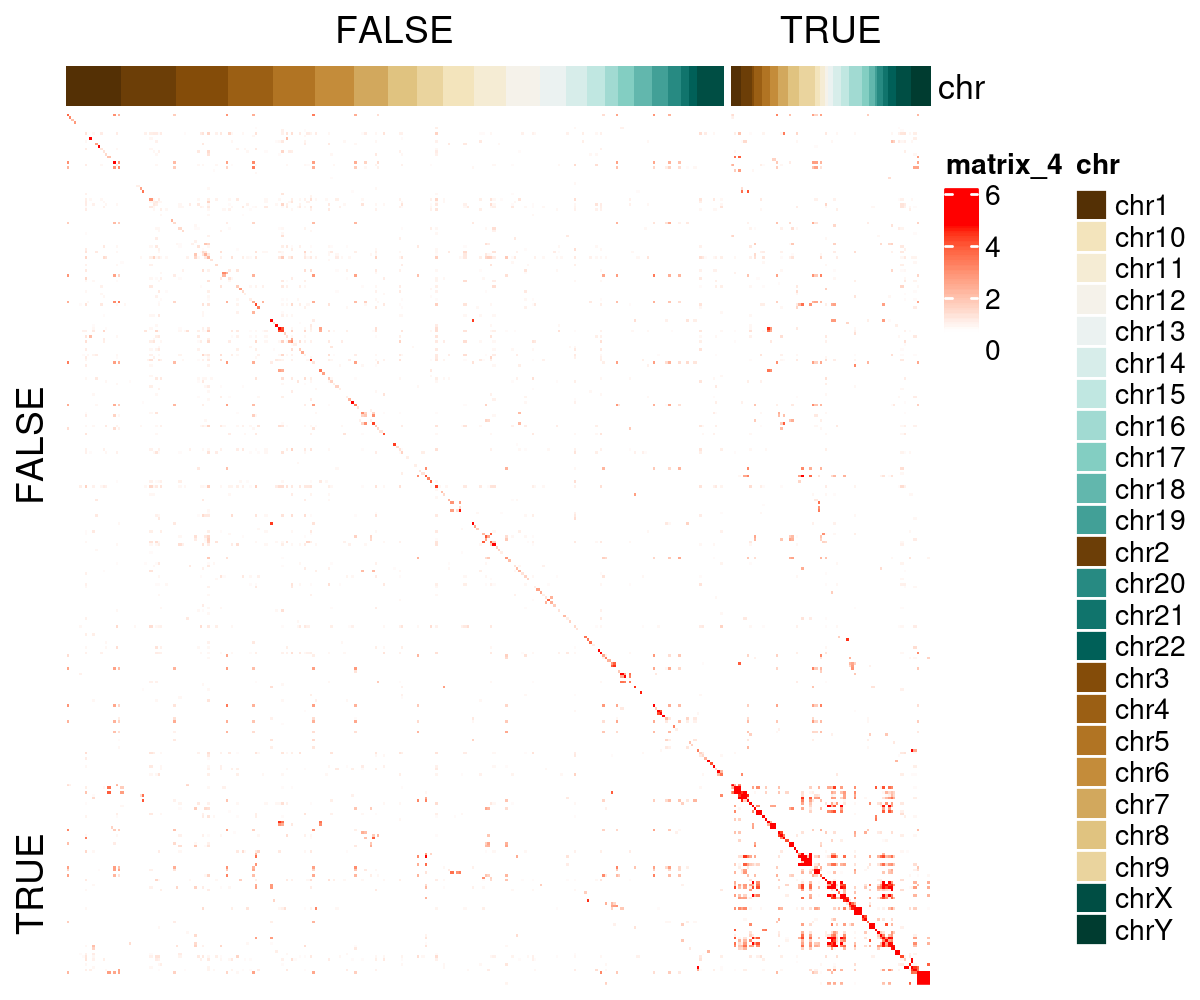

In [193]:
options(repr.plot.height = 5, repr.plot.width = 6, repr.plot.res = 200)
op

In [194]:
fig.5b.dt = mat
head(fig.5b.dt)

[,1]     [,2]     [,3]     [,4] [,5]     [,6] [,7] [,8] [,9] [,10]   [,11]
[1,] 3.690196 1.301030 0.000000 0    0.000000 0    0    0    0    0.00000 ⋯    
[2,] 1.301030 5.724263 0.903090 0    0.000000 0    0    0    0    0.00000 ⋯    
[3,] 0.000000 0.903090 3.062958 0    0.000000 0    0    0    0    0.00000 ⋯    
[4,] 0.000000 0.000000 0.000000 2    0.000000 0    0    0    0    0.00000 ⋯    
[5,] 0.000000 0.000000 0.000000 0    2.723456 0    0    0    0    0.30103 ⋯    
[6,] 0.000000 0.000000 0.000000 0    0.000000 0    0    0    0    0.00000 ⋯    
     [,12]   [,13]   [,14]   [,15] [,16]     [,17]   [,18] [,19] [,20] [,21]
[1,] 0.00000 0.00000 0.00000 0     0.0000000 2.10721 0     0     0     0    
[2,] 0.00000 0.00000 0.00000 0     0.0000000 0.00000 0     0     0     0    
[3,] 0.00000 0.00000 0.00000 0     0.0000000 0.00000 0     0     0     0    
[4,] 0.00000 0.30103 0.30103 0     0.4771213 0.00000 0     0     0     0    
[5,] 0.30103 0.00000 0.00000 0     0.0000000 0.00000 0     0     0     0    
[6,] 0.00000 0.00000 0.00000 0     0.0000000 0.00000 0     0     0     0

### Fig. 5b low res from source data

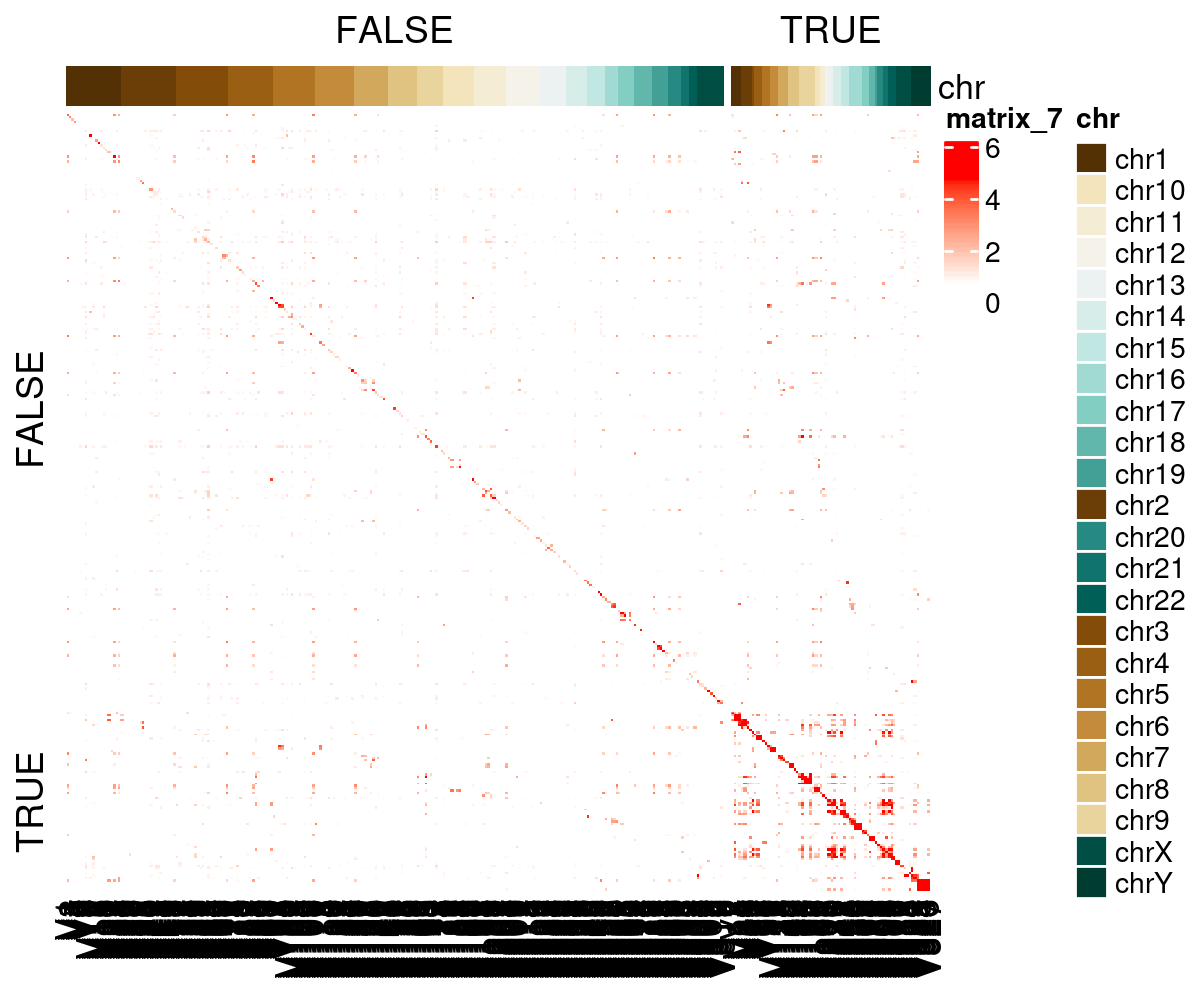

In [206]:
mat = as.matrix(as.data.table(readxl::read_xlsx("./source_data/figure_5.xlsx", sheet = "5B")))

col_fun = colorRamp2(c(0,
                       quantile(overall.pt.dt[, log10(count)], 0.9),
                       quantile(overall.pt.dt[, log10(count)], 0.9),
                       quantile(overall.pt.dt[, log10(count)], 0.999)),
                     c("white", "white", "pink", "red"))

big.tiles = readRDS("./data/t2t/big.tiles.rds")
overall.pt.dt = readRDS("./data/t2t/heatmap.dt.10mbp.rds")
split = values(big.tiles)[, "cnu.frac"] >= 0.1

ha = ComplexHeatmap::HeatmapAnnotation(
    chr = as.character(seqnames(big.tiles)),
    col = list(chr = pal2)
)

op = ComplexHeatmap::Heatmap(matrix = mat, cluster_columns = FALSE, cluster_rows = FALSE,
                             cluster_row_slices = FALSE, cluster_column_slices = FALSE,
                             column_split = split, row_split = split,
                             col = col_fun,
                             use_raster = TRUE,
                             top_annotation = ha)

options(repr.plot.height = 5, repr.plot.width = 6, repr.plot.res = 200)
op

### Zoomed-in CN-unmappable heatmap (right)

In [195]:
unmappable.tiles = readRDS("./data/t2t/unmappable.tiles.rds")
overall.pt.dt = readRDS("./data/t2t/heatmap.dt.1mbp.rds")

ht_opt$message = FALSE ## turn off warnings

smat = sparseMatrix(i = overall.pt.dt[, bin1.remapped],
                    j = overall.pt.dt[, bin2.remapped],
                    x = overall.pt.dt[, log10(count)],
                    dims = c(length(unmappable.tiles), length(unmappable.tiles)),
                    index1 = TRUE)

mat = as.matrix(smat)

pal1 = RColorBrewer::brewer.pal(11, "BrBG")
pal2 = colorRampPalette(pal1)(24)
names(pal2) = names(seqlengths(unmappable.tiles))

ha = HeatmapAnnotation(
    chr = as.character(seqnames(unmappable.tiles)),
    col = list(chr = pal2)
)

op = ComplexHeatmap::Heatmap(matrix = mat, cluster_columns = FALSE, cluster_rows = FALSE,
                             cluster_row_slices = FALSE, cluster_column_slices = FALSE,
                             column_split = NULL, row_split = NULL,
                             col = col_fun,
                             use_raster = TRUE,
                             top_annotation = ha)

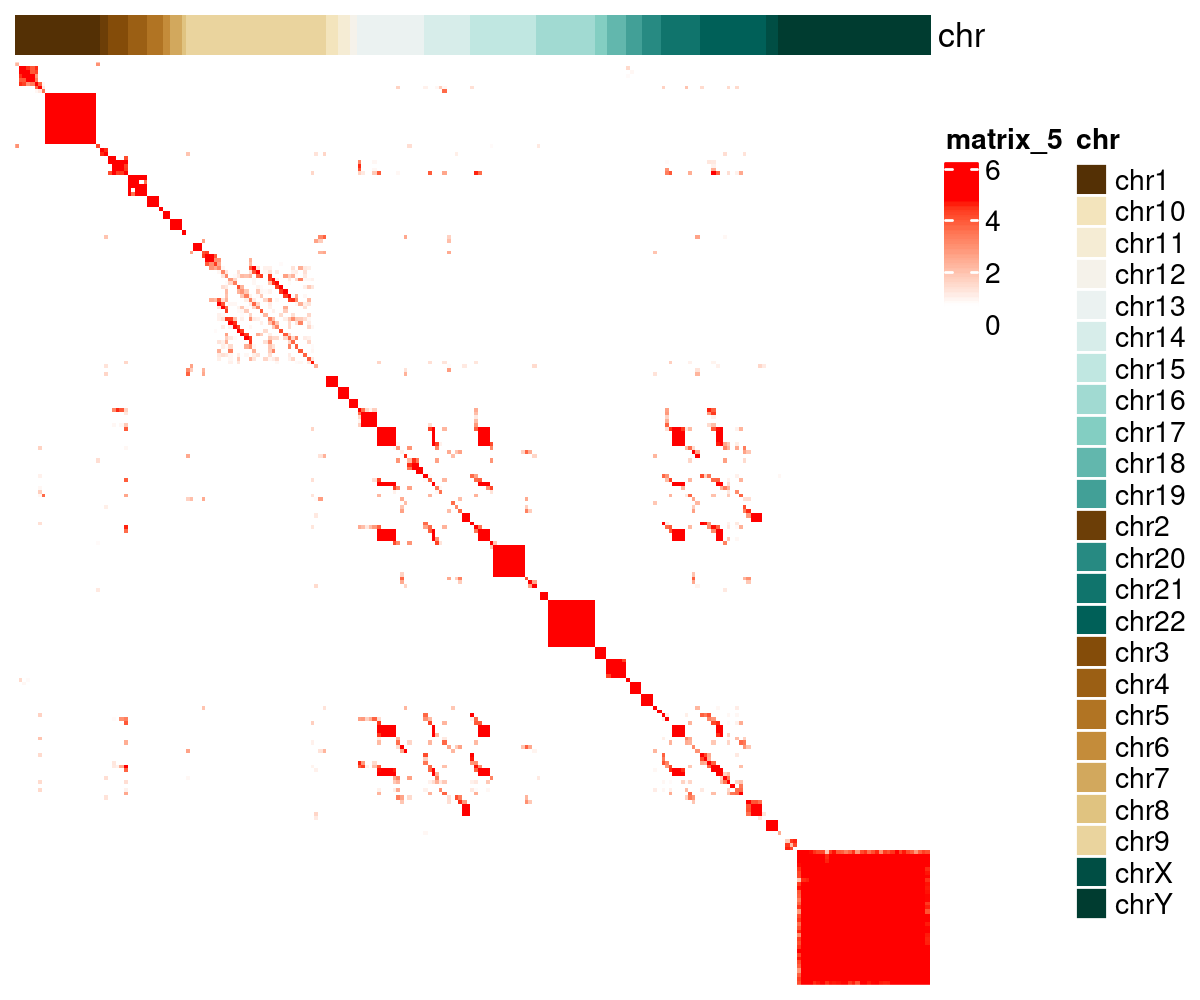

In [196]:
options(repr.plot.height = 5, repr.plot.width = 6, repr.plot.res = 200)
op

In [197]:
fig.5b_zoom.dt = mat
head(fig.5b_zoom.dt)

[,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]     
[1,] 2.158362 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.0000000
[2,] 0.000000 7.054744 6.622992 4.413635 3.887730 4.447840 0.000000 0.0000000
[3,] 0.000000 6.622992 7.010571 4.972998 3.911690 4.201970 0.000000 0.0000000
[4,] 0.000000 4.413635 4.972998 6.698166 6.803906 2.810233 0.000000 0.0000000
[5,] 0.000000 3.887730 3.911690 6.803906 6.940233 3.306211 0.000000 0.0000000
[6,] 0.000000 4.447840 4.201970 2.810233 3.306211 6.614564 3.721811 0.7781513
     [,9] [,10] [,11] [,12] [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20]
[1,] 0    0     ⋯     0     0     0     0     0     0     0     0     0    
[2,] 0    0     ⋯     0     0     0     0     0     0     0     0     0    
[3,] 0    0     ⋯     0     0     0     0     0     0     0     0     0    
[4,] 0    0     ⋯     0     0     0     0     0     0     0     0     0    
[5,] 0    0     ⋯     0     0     0     0     0     0     0     0     0    
[6,] 0    0     ⋯     0     0     0     0     0     0     0     0     0    
     [,21]
[1,] 0    
[2,] 0    
[3,] 0    
[4,] 0    
[5,] 0    
[6,] 0

### Fig. 5b zoom from source

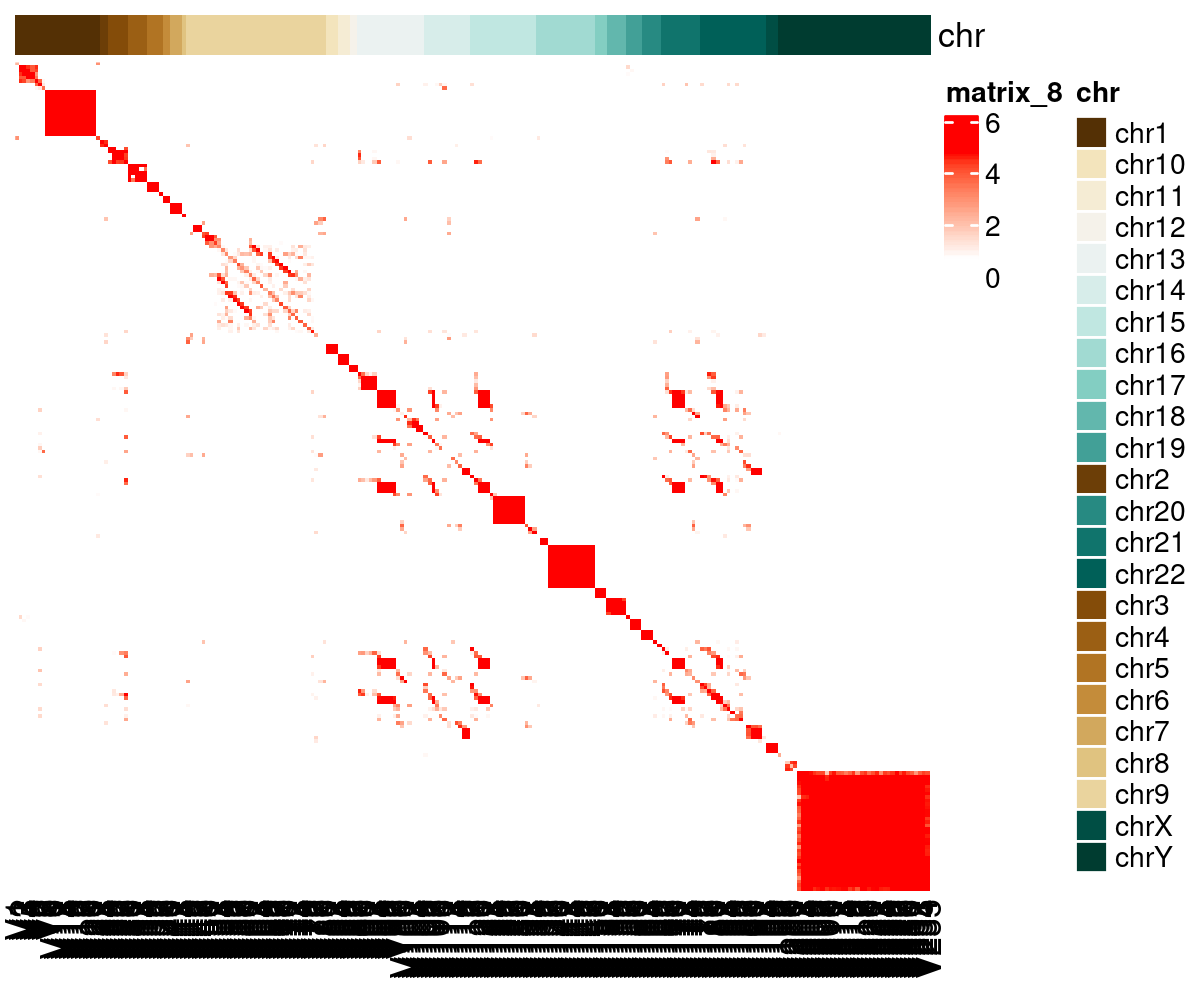

In [207]:
mat = as.matrix(as.data.table(readxl::read_xlsx("./source_data/figure_5.xlsx", sheet = "5B_zoom")))

unmappable.tiles = readRDS("./data/t2t/unmappable.tiles.rds")
overall.pt.dt = readRDS("./data/t2t/heatmap.dt.1mbp.rds")

ha = HeatmapAnnotation(
    chr = as.character(seqnames(unmappable.tiles)),
    col = list(chr = pal2)
)

op = ComplexHeatmap::Heatmap(matrix = mat, cluster_columns = FALSE, cluster_rows = FALSE,
                             cluster_row_slices = FALSE, cluster_column_slices = FALSE,
                             column_split = NULL, row_split = NULL,
                             col = col_fun,
                             use_raster = TRUE,
                             top_annotation = ha)

options(repr.plot.height = 5, repr.plot.width = 6, repr.plot.res = 200)
op

## Fig. 5c
Bar plot of eligible NAHR sites between CN mappable (CNM) and CN unmappable (CNU)

In [188]:
bp.dt = readRDS("./data/t2t/small.bins.bp.dt.for.barplot.rds")
bp.dt[, ":="(label = ifelse(bin1.mappable, 
                            ifelse(bin2.mappable, "CNUxCNU", "CNUxCNM"), 
                            ifelse(bin2.mappable, "CNUxCNM", "CNMxCNM")))]

bp = ggplot(bp.dt, aes(x = 1, y = V1, fill = label)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(y = "fraction of homologous sites") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

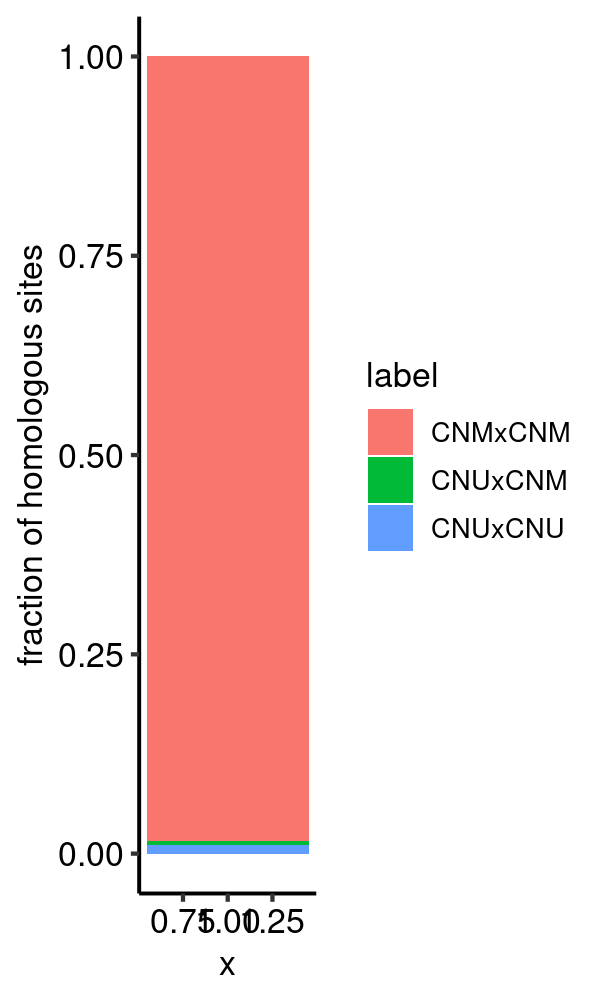

In [189]:
options(repr.plot.height = 5, repr.plot.width = 3, repr.plot.res = 200)
bp

In [198]:
fig.5c.dt = bp$data
head(fig.5c.dt)

bin1.mappable bin2.mappable V1      label  
1 FALSE         FALSE         8830830 CNMxCNM
2 FALSE          TRUE           25135 CNUxCNM
3  TRUE          TRUE           90766 CNUxCNU
4  TRUE         FALSE           25135 CNUxCNM

### Fig. 5c from source

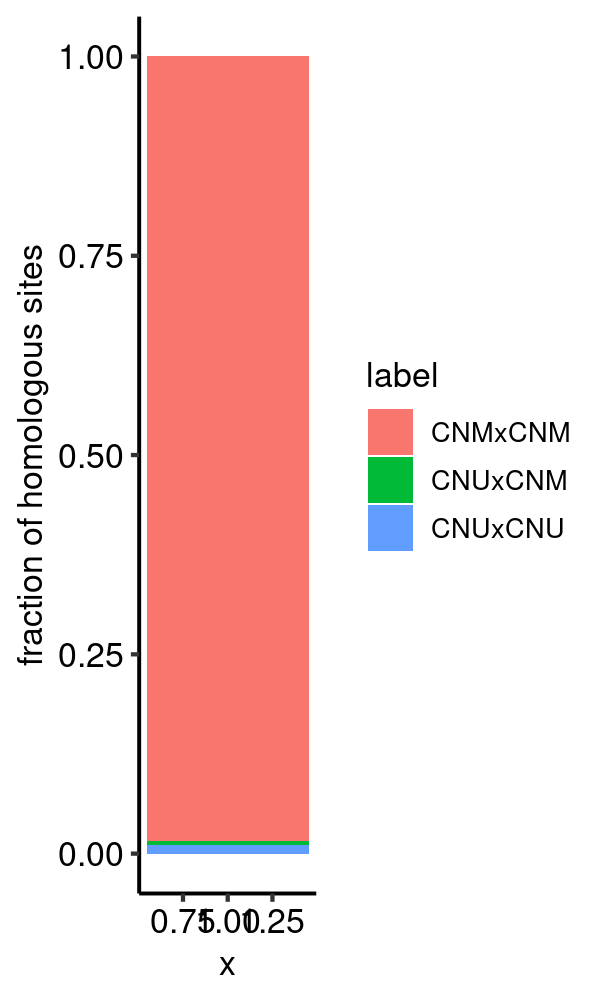

In [208]:
dat = readxl::read_xlsx(path = "./source_data/figure_5.xlsx", sheet = "5C")

bp = ggplot(dat, aes(x = 1, y = V1, fill = label)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(y = "fraction of homologous sites") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

options(repr.plot.height = 5, repr.plot.width = 3, repr.plot.res = 200)
bp

## Fig. 5d
Final alluvial plot where we estimate the number of missing SRS rearrangements.

In [200]:
bs.alluvial.dt = fread("./data/t2t/5c.alluvial.txt", sep = ",", header = FALSE, skip = 1)
setnames(bs.alluvial.dt, c("location", "homology", "detected", "mappable", "fraction"))

## set colors
bs.alluvial.dt[, color.level := ordered(paste(ifelse(mappable == "no", "unmappable", "mappable"), 
                                              ifelse(homology == "no", "non-NAHR", "NAHR")), 
                                        levels = c("unmappable NAHR", 
                                                   "unmappable non-NAHR", 
                                                   "mappable NAHR", 
                                                   "mappable non-NAHR"))]

## levels
bs.alluvial.dt[, location.level := factor(location, c("CNU", "CNM"))]
bs.alluvial.dt[, homology.level := factor(ifelse(homology == "yes", "putative HR/MR", "non-nahr"), c("putative HR/MR", "non-nahr"))]
bs.alluvial.dt[, detected.level := factor(detected, c("no", "yes"))]
bs.alluvial.dt[, mapped.level := factor(mappable, c("no", "yes"))]

alluv.pt = ggplot(bs.alluvial.dt[order(mapped.level)][order(detected.level)][order(homology.level)][order(location.level)], aes(axis1 = location.level, axis2 = homology.level, axis3 = detected.level,y = fraction)) +
    ggalluvial::geom_alluvium(aes(fill = color.level), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.4, reverse = FALSE, alpha = 0.5, color = "black") +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "estimated fraction of breakends") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")


Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”


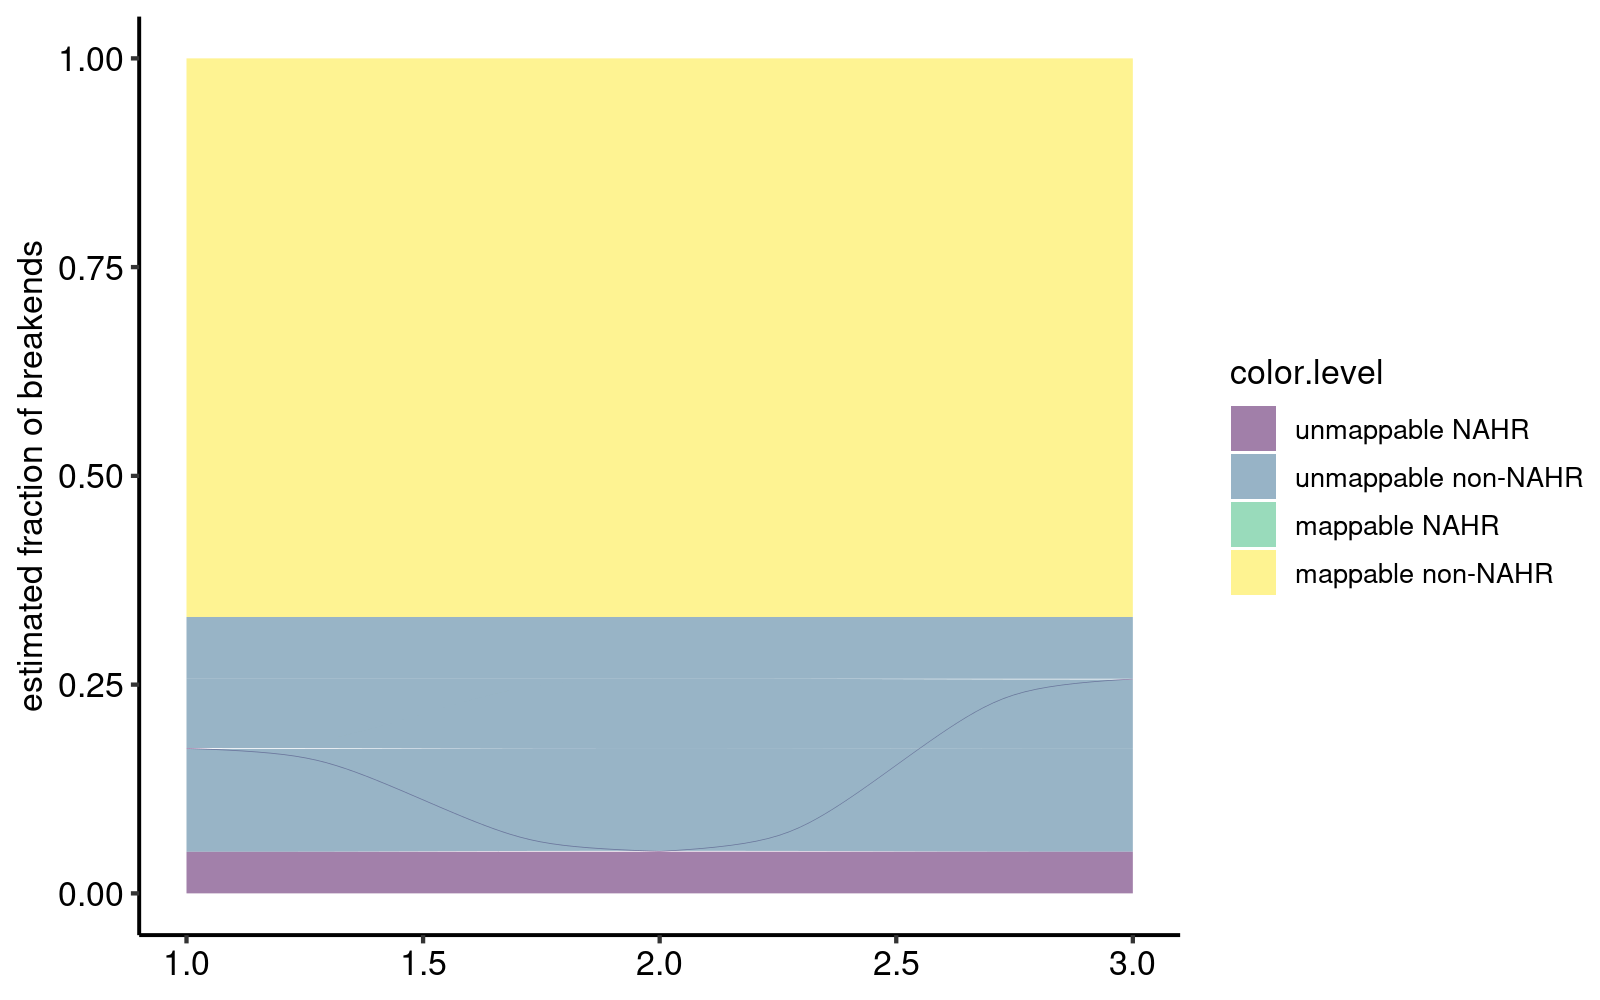

In [201]:
options(repr.plot.height = 5, repr.plot.width = 8, repr.plot.res = 200)
alluv.pt

In [202]:
fig.5d.dt = alluv.pt$data
head(fig.5d.dt)

location homology detected mappable fraction color.level        
1 CNU      yes      no       no       0.0499   unmappable NAHR    
2 CNU      yes      no       yes      0.0000   mappable NAHR      
3 CNU      yes      yes      no       0.0000   unmappable NAHR    
4 CNU      yes      yes      yes      0.0000   mappable NAHR      
5 CNU      no       no       no       0.1231   unmappable non-NAHR
6 CNU      no       no       yes      0.0000   mappable non-NAHR  
  location.level homology.level detected.level mapped.level
1 CNU            putative HR/MR no             no          
2 CNU            putative HR/MR no             yes         
3 CNU            putative HR/MR yes            no          
4 CNU            putative HR/MR yes            yes         
5 CNU            non-nahr       no             no          
6 CNU            non-nahr       no             yes

### Fig. 5d from source

Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”
Warning message:
“Computation failed in `stat_stratum()`
Caused by error in `default_missing()`:
! could not find function "default_missing"”


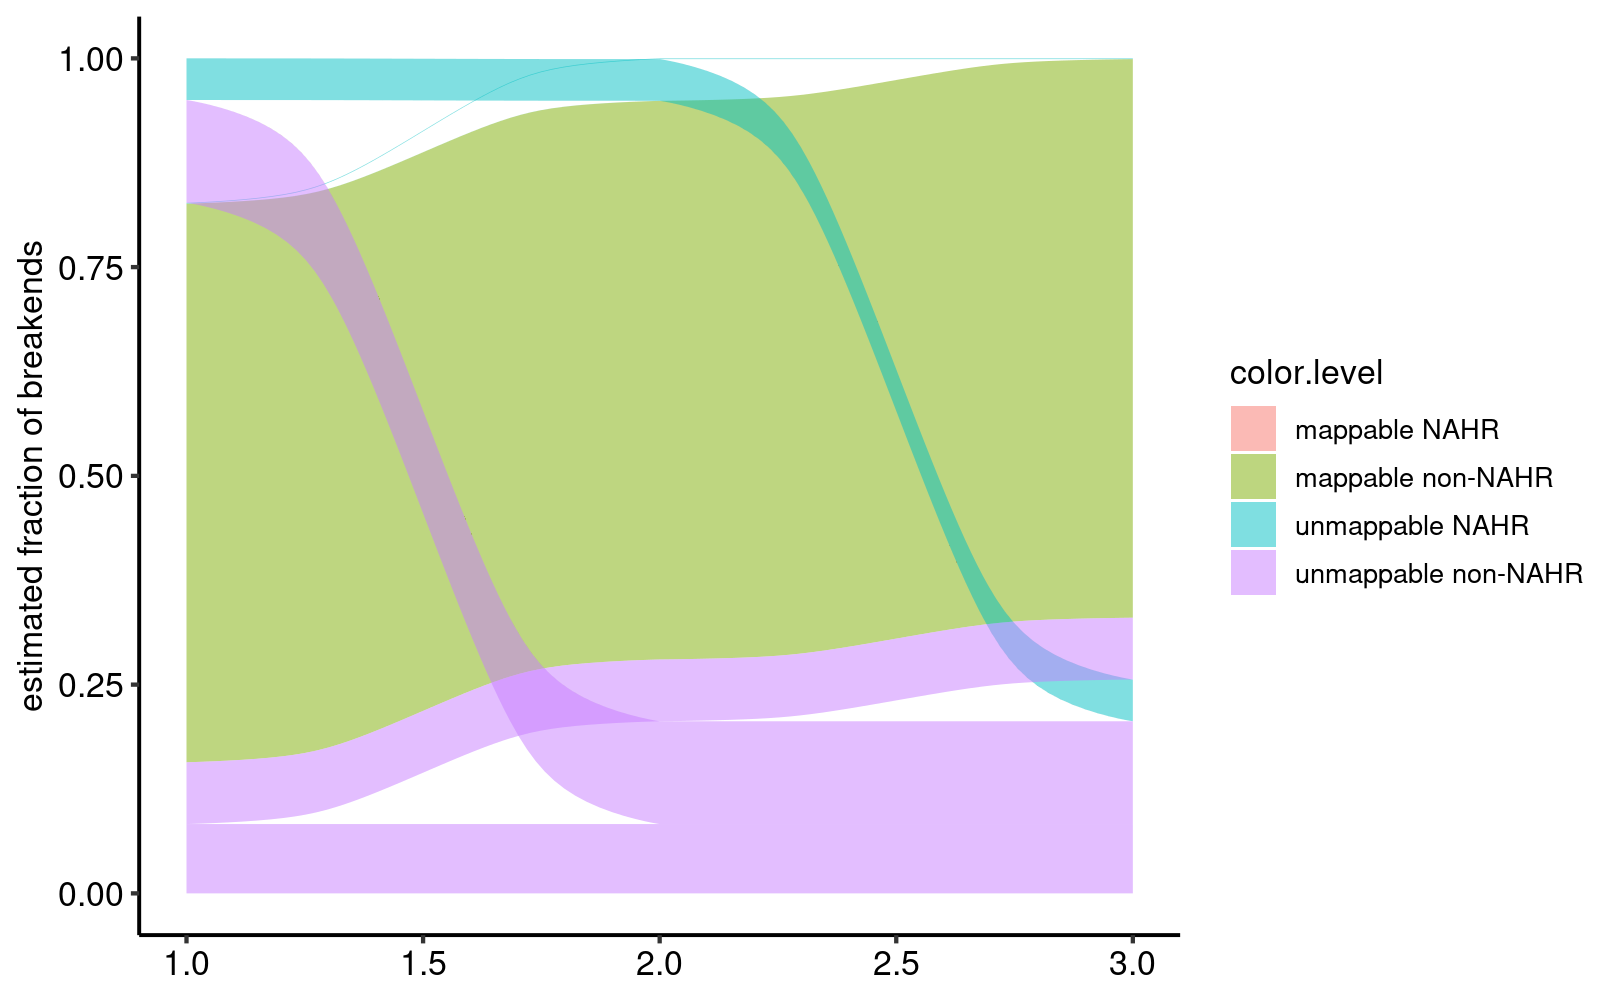

In [209]:
dat = readxl::read_xlsx(path = "./source_data/figure_5.xlsx", sheet = "5D")

alluv.pt = ggplot(dat,
                  aes(axis1 = location.level, axis2 = homology.level, axis3 = detected.level,y = fraction)) +
    ggalluvial::geom_alluvium(aes(fill = color.level), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.4, reverse = FALSE, alpha = 0.5, color = "black") +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "estimated fraction of breakends") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

options(repr.plot.height = 5, repr.plot.width = 8, repr.plot.res = 200)
alluv.pt

## Fig. 5 source data

In [204]:
writexl::write_xlsx(x = list(`5B` = as.data.table(fig.5b.dt),
                             `5B_zoom` = as.data.table(fig.5b_zoom.dt),
                             `5C` = fig.5c.dt,
                             `5D` = fig.5d.dt),
                    path = "./source_data/figure_5.xlsx",
                    col_names = TRUE)

# Extended Data Figure 1
Benchmarking total and allelic copy number and breakend detection in cancer genomes.

## EDF1e
Loose end-specific precision and recall.

In [199]:
summary.loose.cncp.dt = readRDS("./data/benchmarking/1c.summary.loose.cncp.dt.rds")

summary.loose.cncp.dt[, color.levels := ordered(paste(method, purity.class),
                                                levels = c("JaBbA v1 high purity",
                                                           "JaBbA v1 low purity",
                                                           "JaBbA v0 high purity",
                                                           "JaBbA v0 low purity"))]
                                                           

pt = ggplot(summary.loose.cncp.dt[type == "CN mappable"], aes(x = median.recall, y = median.precision)) +
    geom_point(size = 8, aes(color = color.levels), alpha = 0.6) +
    geom_errorbar(mapping = aes(color = color.levels, ymin = precision.lower,ymax = precision.upper),
                  width = 0.01) +
    geom_errorbarh(mapping = aes(xmin = recall.lower,xmax = recall.upper, color = color.levels),
                  height = 0.01) +
    facet_grid(cols = vars(type)) +
    labs(x = "recall", y = "precision") +
    ylim(0, 1) +
    xlim(0, 1) +
    theme_bw() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          legend.position = "right")

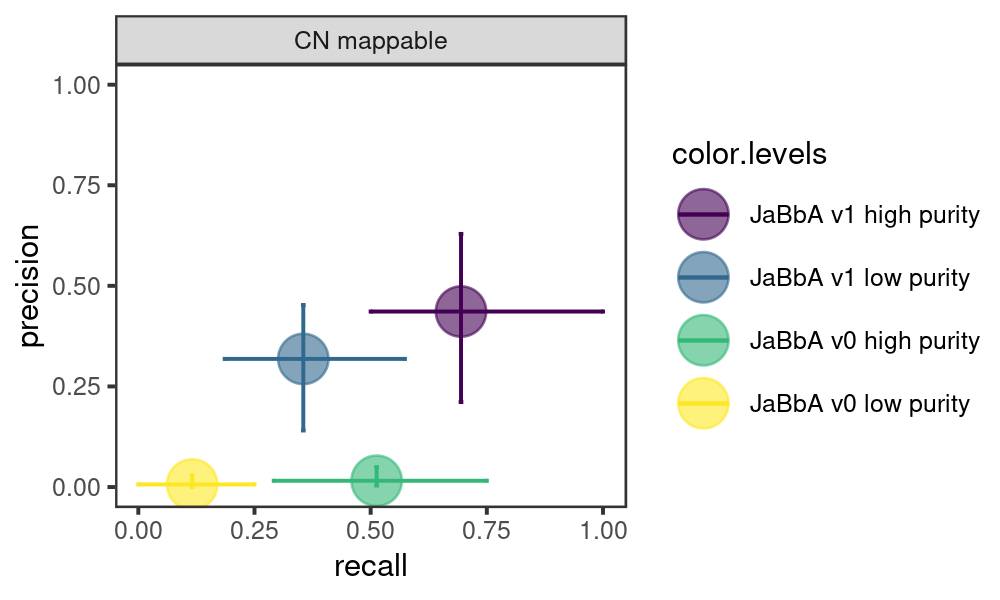

In [200]:
options(repr.plot.height = 3, repr.plot.width = 5, repr.plot.res = 200)
pt

## EDF1f
Precision and recall of breakend detection in general (not just in high-purity tumors)

In [205]:
mg.cncp.dt = readRDS("./data/benchmarking/cncp.rds")

precision.recall.cncp.dt = mg.cncp.dt[,
                                      .(median.precision = median(precision.cncp, na.rm = T),
                                        precision.lower = quantile(precision.cncp, na.rm = T, probs = 0.25),
                                        precision.upper = quantile(precision.cncp, na.rm = T, probs = 0.75),
                                        median.recall = median(recall.cncp, na.rm = T),
                                        recall.lower = quantile(recall.cncp, na.rm = T, probs = 0.25),
                                        recall.upper = quantile(recall.cncp, na.rm = T, probs = 0.75)),
                                      by = method]

## set the method level
precision.recall.cncp.dt[, method.level := ordered(method, c("JaBbA v1", "JaBbA v0", "ASCAT", "FACETS", "sequenza", "TITAN"))]

pt = ggplot(precision.recall.cncp.dt, aes(x = median.recall, y = median.precision)) +
    geom_point(size = 5, aes(color = method.level), alpha = 0.6) +
    geom_errorbar(mapping = aes(color = method.level, ymin = precision.lower,ymax = precision.upper),
                  width = 0.01) +
    geom_errorbarh(mapping = aes(xmin = recall.lower,xmax = recall.upper, color = method.level),
                  height = 0.01) +
    ylim(0, 1) +
    xlim(0, 1) +
    ggpubr::theme_pubr()


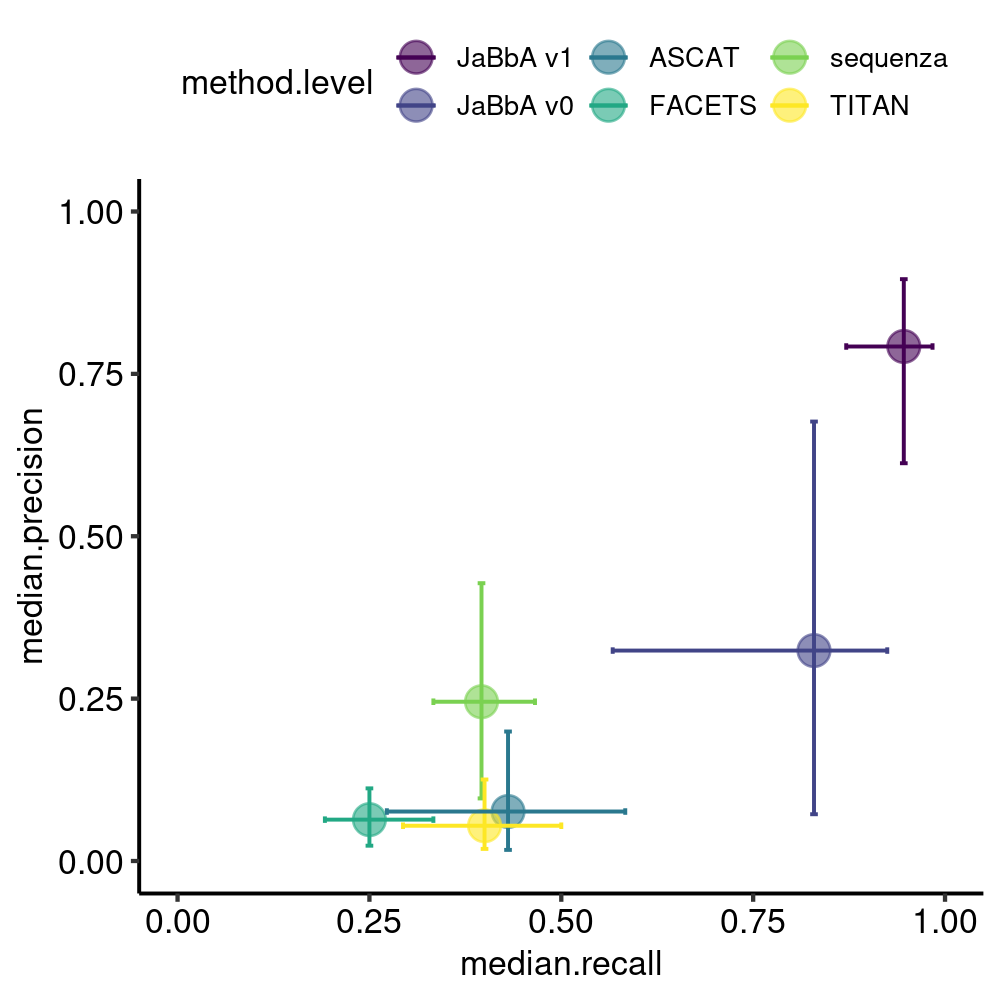

In [206]:
options(repr.plot.height = 5, repr.plot.width = 5, repr.plot.res = 200)
pt

## EDF1g
Total and allelic copy number

In [209]:
mg.cn.dt = readRDS("./data/benchmarking/new.cn.rds")

pt = ggplot(mg.cn.dt, aes(y = rmse, x = method, fill = method)) +
    geom_violin(trim = FALSE) +
    geom_boxplot(width = 0.1, outlier.shape = NA) + 
    ## ggforce::geom_sina(shape=16, alpha = 0.2, size = 0.05, color = "cornflower blue") +
    labs(x = "method", y = "RMSE (log1p)", title = "CN estimation") +
    ylim(0, 20) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10)) +
    viridis::scale_colour_viridis() +
    ggpubr::theme_pubr()


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


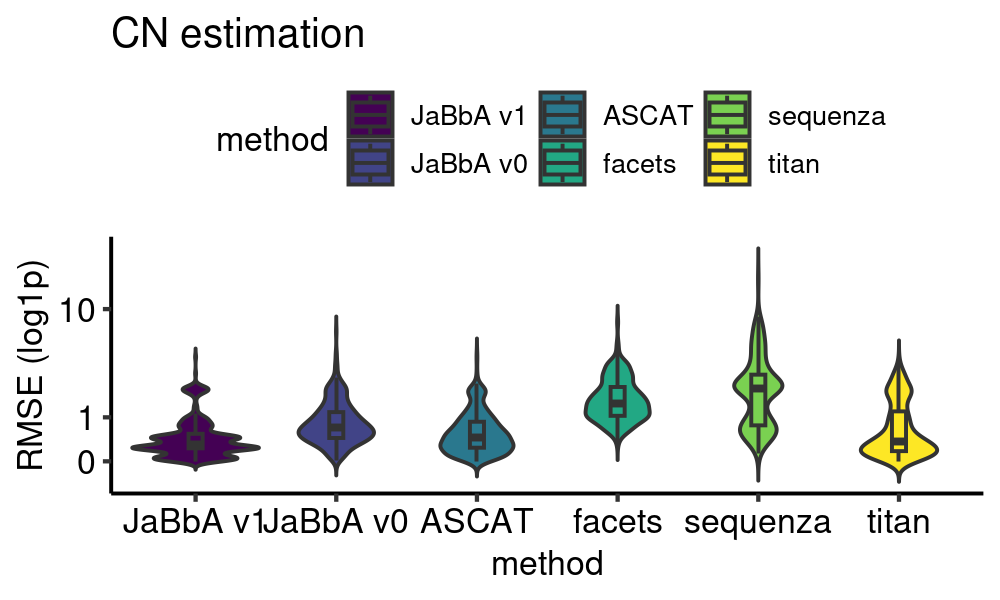

In [210]:
options(repr.plot.height = 3, repr.plot.width = 5, repr.plot.res = 200)
pt

In [393]:
mg.acn.dt = readRDS("./data/benchmarking/new.allelic.cn.rds")

pt = ggplot(mg.acn.dt, aes(y = rmse, x = method, fill = method)) +
    geom_violin(trim = FALSE) +
    geom_boxplot(width = 0.1, outlier.shape = NA) + 
    ## ggforce::geom_sina(shape=16, alpha = 0.2, size = 0.05, color = "cornflower blue") +
    labs(x = "method", y = "RMSE (log1p)", title = "allelic CN estimation") +
    ylim(0, 20) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10)) +
    ggpubr::theme_pubr()


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


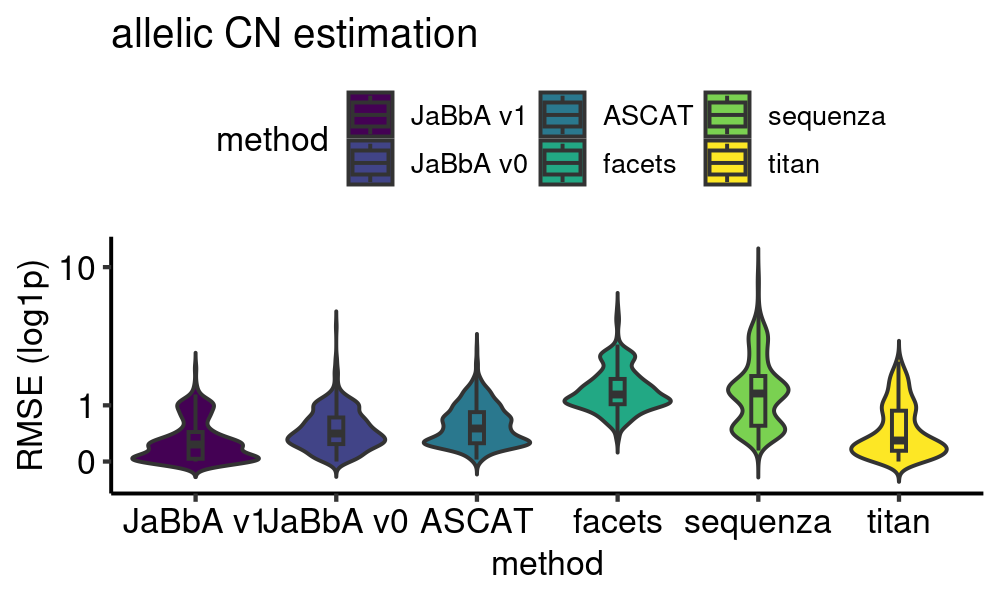

In [215]:
options(repr.plot.height = 3, repr.plot.width = 5, repr.plot.res = 200)
pt

# Extended Data Figure 3

Defining the CN mappable genome.

## EDF3b
Alluvial plot of genome mappability tiers

In [225]:
## all.segs.dt = readRDS("~/projects/gGnome/files/zc_stash/alluvial.segs.dt.rds")
## coarse.alluv.dt = all.segs.dt[, .(width = sum(width / 1e6)), by = .(repmasker.coarse, mappable, cn.unmappable)]
coarse.alluv.dt = readRDS("./data/genome_info/coarse.alluv.dt.rds")

order.alluv.dt = coarse.alluv.dt[, .(total.width = sum(width)), by = repmasker.coarse][order(total.width)]
coarse.alluv.dt[, repmasker.coarse := ordered(repmasker.coarse, levels = order.alluv.dt$repmasker.coarse)]
coarse.alluv.dt[, mappable.coarse := ordered(ifelse(mappable == "unassembled", "unmappable", mappable), levels = c("unmappable", "mappable"))]
coarse.alluv.dt[, cn.unmappable := ordered(cn.unmappable, levels = c("unmappable", "mappable"))]
coarse.alluv.dt[, frac := width / sum(width)]

alluv.pt = ggplot(coarse.alluv.dt, aes(axis1 = repmasker.coarse, axis2 = mappable.coarse, axis3 = cn.unmappable, y = frac)) + 
    ggalluvial::geom_alluvium(width = 0, knot.pos = 0.3,  reverse = FALSE, aes(fill = repmasker.coarse)) + 
    scale_y_continuous(breaks = c(1:10 * 0.1))+
    guides(scale = 'none') +
    ggalluvial::geom_stratum(width = 0.3, reverse = FALSE, alpha = 0.3, color = "black") + 
    ggrepel::geom_label_repel(stat = 'stratum',aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1,size = 4, segment.color = "black", min.segment.length = 0.1, point.padding = 0.1, label.padding = 0.2, direction = "both") +
    labs(y = "Fraction of genome", x = "Category") +
    coord_flip() +
    ggpubr::theme_pubr() +
    scale_color_gradientn(colors = grDevices::rainbow(7))



Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


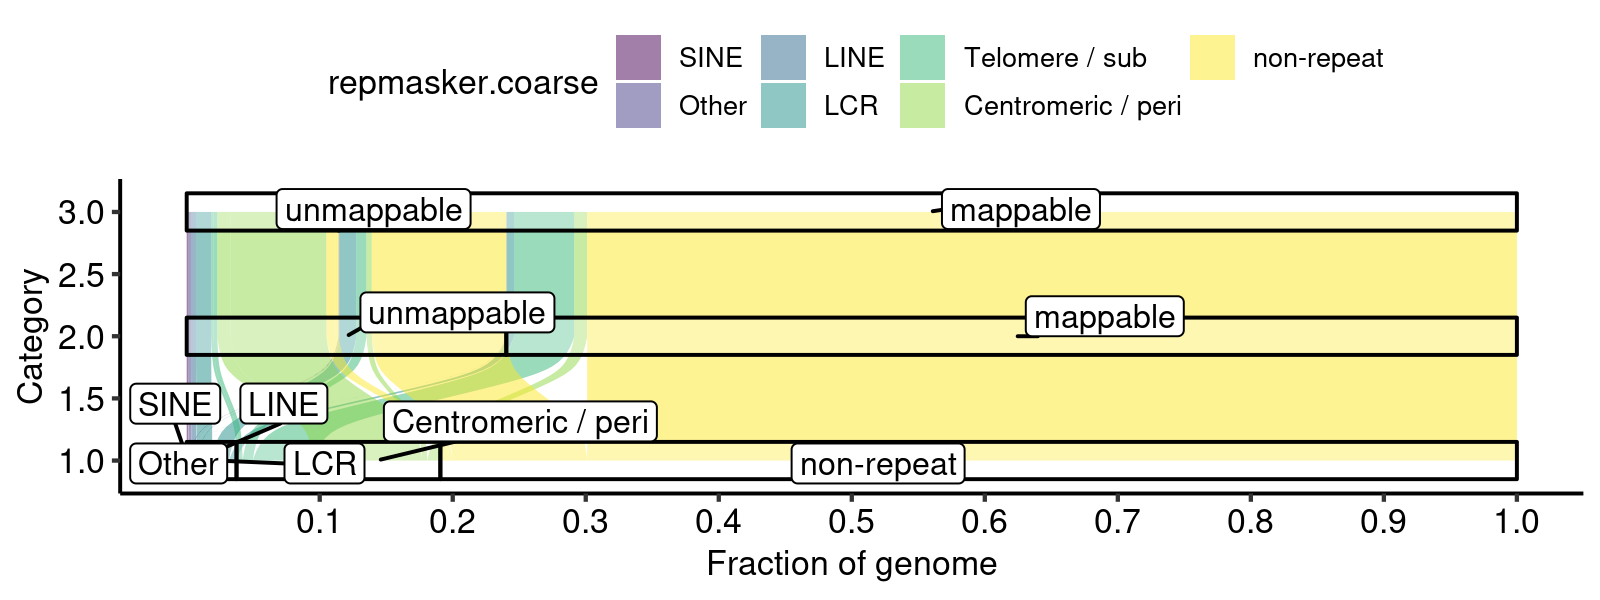

In [226]:
options(repr.plot.height = 3, repr.plot.width = 8, repr.plot.res = 200)
alluv.pt

In [396]:
mappability.cov.dt = readRDS("./data/genome_info/mappability.coverage.std.dt.rds")

vp = ggplot(mappability.cov.dt[std > 0], aes(y = std, x = label)) +
    geom_violin(trim = FALSE) +
    geom_boxplot(width = 0.05, outlier.shape = NA) +
    ## ggforce::geom_sina(shape=16, alpha = 0.2, size = 0.05, color = "cornflower blue") +
    labs(x = "SRS mappability", y = "read depth std (log)") +
    scale_y_continuous(trans = "log", breaks = c(0.01,0.1,1,10,100,1000)) + 
    ggpubr::theme_pubr()


In [401]:
mappability.cov.dt[, length(unique(sample))]

[1] 100

In [399]:
mappability.cov.dt[, .N, by = label]

label               N   
1 CN unmappable        924
2 mappable             883
3 junction unmappable 1000

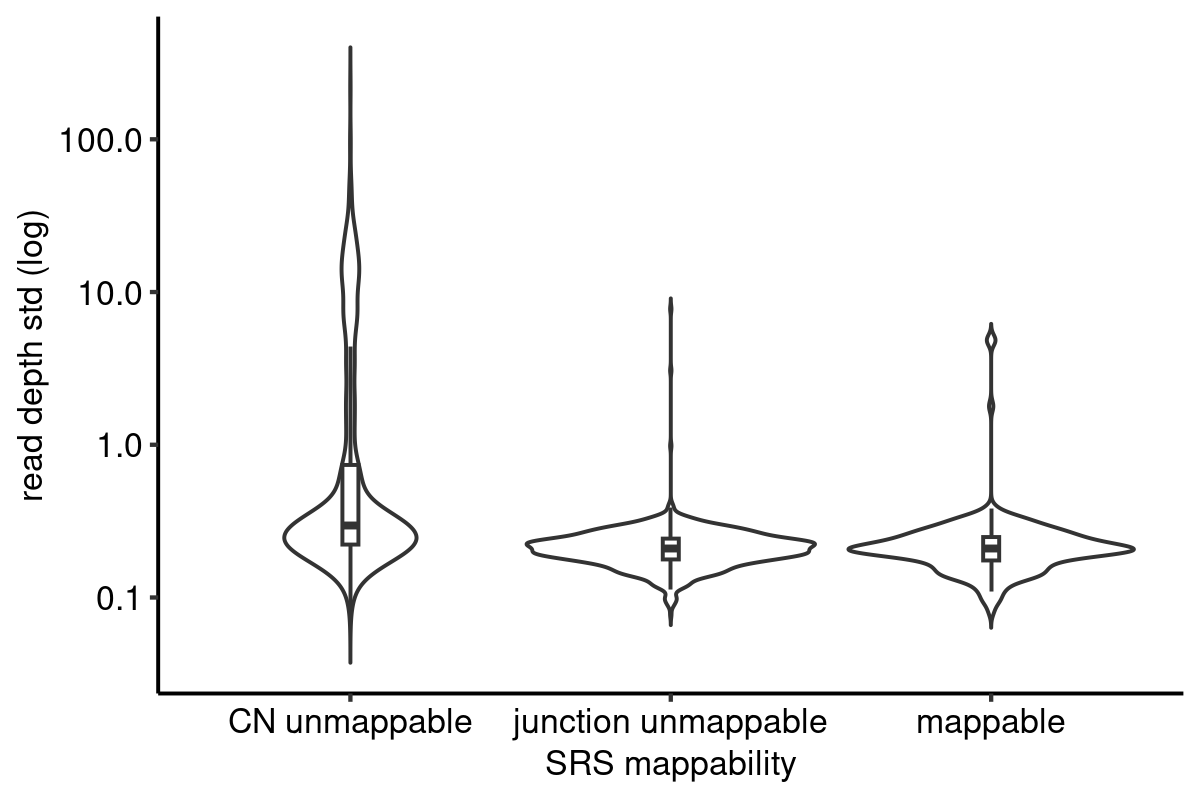

In [231]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
vp

## EDF3d
Fraction of the genome that is CN unmappable (GrCh37 vs. GrCh38) by read length (101 vs. 150 bp)

In [234]:
pt.dt = readRDS("./data/genome_info/tranches.by.build.rds")

pt = ggplot(pt.dt, aes(x = type, y = frac, fill = label.level)) +
    geom_bar(stat="identity", position = "fill") +
    labs(x = "self-alignment", y = "fraction of genome") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

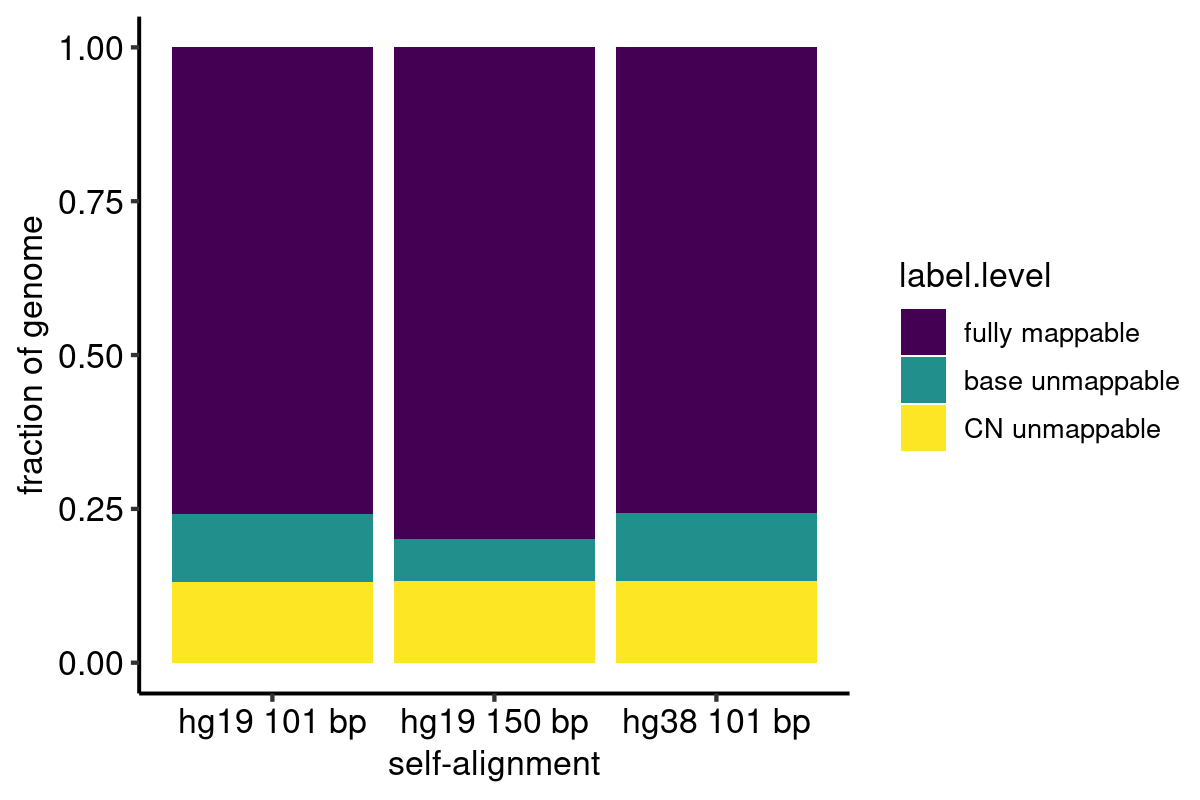

In [236]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
pt

# Extended Data Figure 4
More examples of balanced and unbalanced rearrangements

## EDF4a
In simulated data, recovery of balanced vs. unbalanced breakends.

In [240]:
sim.gs.bps.dt = readRDS("./data/genome_info/balanced.breakend.recovery.rds")

pt.dt = sim.gs.bps.dt[(!mask), .(frac = .SD[(called), .N] / .SD[, .N]), 
                      by = .(sample, purity.category, balanced.levels)]

pt = ggplot(pt.dt, aes(x = purity.category, y = frac, fill = purity.category)) +
    geom_boxplot(width = 0.3) +
    facet_grid(cols = vars(balanced.levels)) +
    labs(y = "fraction of breakends", x = "purity") +
    ggpubr::theme_pubr()

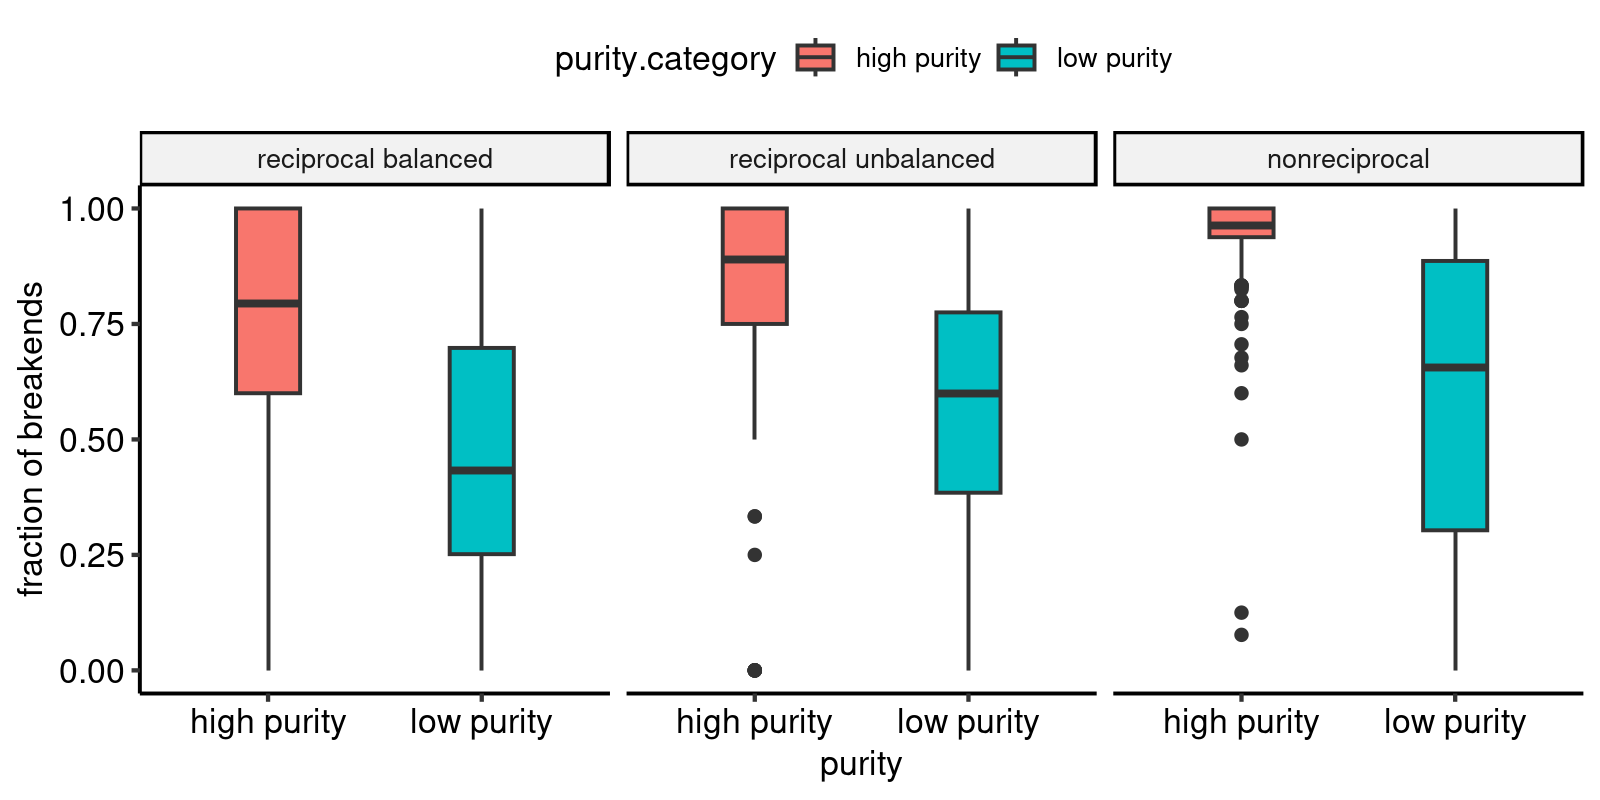

In [241]:
options(repr.plot.height = 4, repr.plot.width = 8, repr.plot.res = 200)
pt

# Extended Data Figure 5
Sequence context of loose ends

## EDF5a
LINE element enrichment at loose ends (relative to random sites)

In [245]:
base.unmappable.tiles = readRDS("./data/sequence_context/base.unmappable.tiles.rds")
all.points.dt = readRDS("./data/sequence_context/loose.ends.and.random.sites.rds")

base.unmappable.alift.gr = gUtils::anchorlift(query = base.unmappable.tiles,
                                              subject = gr.stripstrand(dt2gr(unique(all.points.dt))),
                                              include.values = TRUE,
                                              window = 1e5)

base.unmappable.alift.dt = as.data.table(base.unmappable.alift.gr)
base.unmappable.alift.dt[, bin := easy.cut((start + end) / 2, start = -1e5, end = 1e5, step = 1e3)]
base.unmappable.alift.dt[, bin := as.numeric(as.character(bin))]
base.unmappable.alift.dt[, line := ifelse(repmasker %like% "LINE", "LINE", "other")]

pt.dt = base.unmappable.alift.dt[, .(count = .N), by = .(bin, type, line)]
pt.dt[, norm.factor := .SD[(bin < -5e3 & bin > -4e4), mean(count, na.rm = TRUE)], by = .(type, line)]
pt.dt[, norm.n := count / norm.factor]
pt.dt = pt.dt[abs(bin) < 25e3]
pt.dt[, x := - bin / 1e3]

pt = ggplot(pt.dt[type == "loose" | type == "random"], aes(x = bin / 1e3, y = norm.n, color = type)) +
    geom_line(position = "identity", stat = "identity", size = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "LINE") +
    theme_bw() +
    ggpubr::theme_pubr() +
    facet_grid(rows = vars(line)) +
    ylim(0, 10) + xlim(-25, 25)

Computing overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 228 out-of-bound ranges located on sequences
  11, 12, 14, 17, 18, 19, 1, 22, 2, 5, 7, 8, X, 1_gl000192_random,
  19_gl000209_random, 20, 6, 4, Un_gl000221, 13, Un_gl000228,
  Un_gl000213, 16, 9_gl000198_random, 10, Un_gl000223, Un_gl000249,
  1_gl000191_random, 4_gl000193_random, Y, Un_gl000240, Un_gl000216,
  7_gl000195_random, 9_gl000199_random, Un_gl000220, Un_gl000219, 3,
  Un_gl000222, 21, Un_gl000227, 4_gl000194_random, Un_gl000218,
  17_gl000205_random, 8_gl000197_random, Un_gl000214, Un_gl000247, 15,
  Un_gl000236, Un_gl000244, 9_gl000200_random, Un_gl000215, Un_gl000225,
  Un_gl000217, 17_gl000203_random, 11_gl000202_random, Un_gl000237,
  17_gl000204_random, Un_gl000235, Un_gl000211, and 9. Note that ranges
  located on a sequence whose length is unknown (NA) or on a circular
  sequence are not considered out-of-bound (use seqlengths() and
  isCircular() to ge

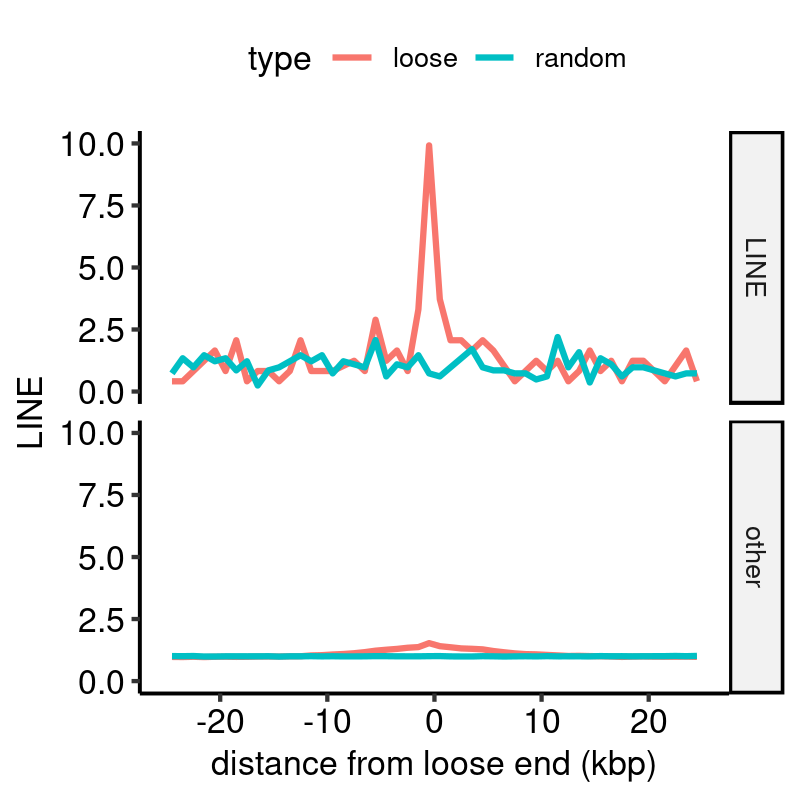

In [247]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## EDF5b

Viral and satellite loose reads

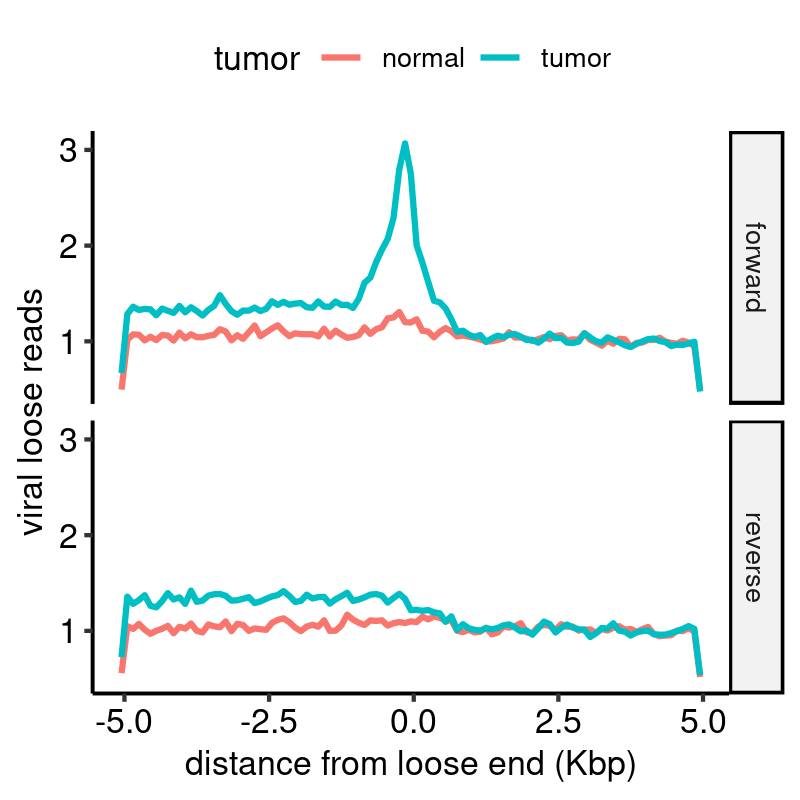

In [251]:
viral.pt.dt = readRDS("./data/sequence_context/viral.loose.reads.rds")

pt = ggplot(viral.pt.dt[somatic == "somatic"], aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(read.strand)) +
    labs(x = "distance from loose end (Kbp)", y = "viral loose reads") +
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

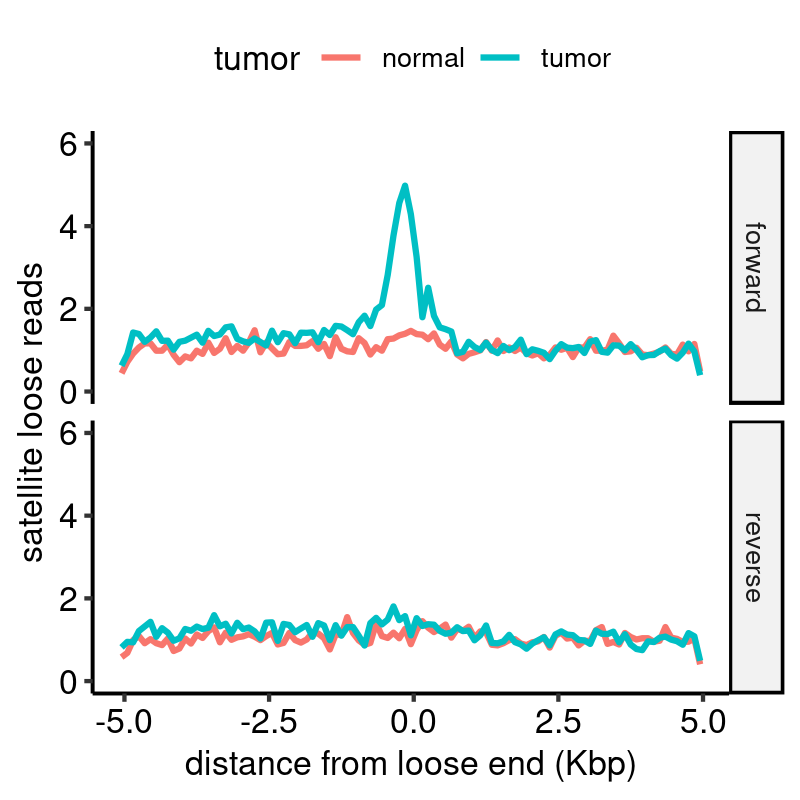

In [252]:
sat.pt.dt = readRDS("./data/sequence_context/satellite.loose.reads.rds")

pt = ggplot(sat.pt.dt[somatic == "somatic"], aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(read.strand)) +
    labs(x = "distance from loose end (Kbp)", y = "satellite loose reads") +
    ggpubr::theme_pubr() +
    ylim(0, 6)

options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 5c
Anchorlift boundaries of large CN-unmappable regions to partially mapped loose ends.

In [256]:
mask.gr = readRDS("./data/sequence_context/maskA_re.rds")
calls.dt = readRDS("./data/sequence_context/new.calls.dt.rds")

wmax = 1e6
query.gr = grbind(gr.start(mask.gr %Q% (width(mask.gr) > wmax)), gr.end(mask.gr %Q% (width(mask.gr) > wmax)))

alift.dt = gUtils::anchorlift(query = query.gr, subject = calls.dt[(keep), parse.gr(loose.end)], window = 1e6) %>% as.data.table

alift.dt[, new.annotation := calls.dt[(keep)][subject.id, new.annotation]]
alift.dt[, unmappable.loose := new.annotation != "junction"]

alift.dt[, bin := easy.cut(start, start = -1e6, step = 500)]
alift.dt[, bin := as.numeric(as.character(bin))]
pt.dt = alift.dt[!is.na(bin), .(n = .N), by = .(bin, unmappable.loose)]
pt.dt[, norm.factor := .SD[(bin > 0 & bin < 1e6), mean(n, na.rm = TRUE)], by = unmappable.loose]
pt.dt[, norm.n := n / norm.factor]

pt = ggplot(pt.dt, aes(x = bin, y = norm.n, color = unmappable.loose)) +
    geom_line(size = 1, alpha = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "normalized count", title = "CN unmappable boundary") +
    ggpubr::theme_pubr() +
    ## ylim(0, 100) +
    xlim(-2.5e4, 2.5e4) +
    theme(legend.position = "bottom")

Computing overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 2027 out-of-bound ranges located on sequences
  10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 2, 3, 4, 5, 6,
  7, 8, 9, and X. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Lifting ranges

Flipping ranges relative to subject peak

Creating final output



Warning message:
“Removed 2664 rows containing missing values (`geom_line()`).”


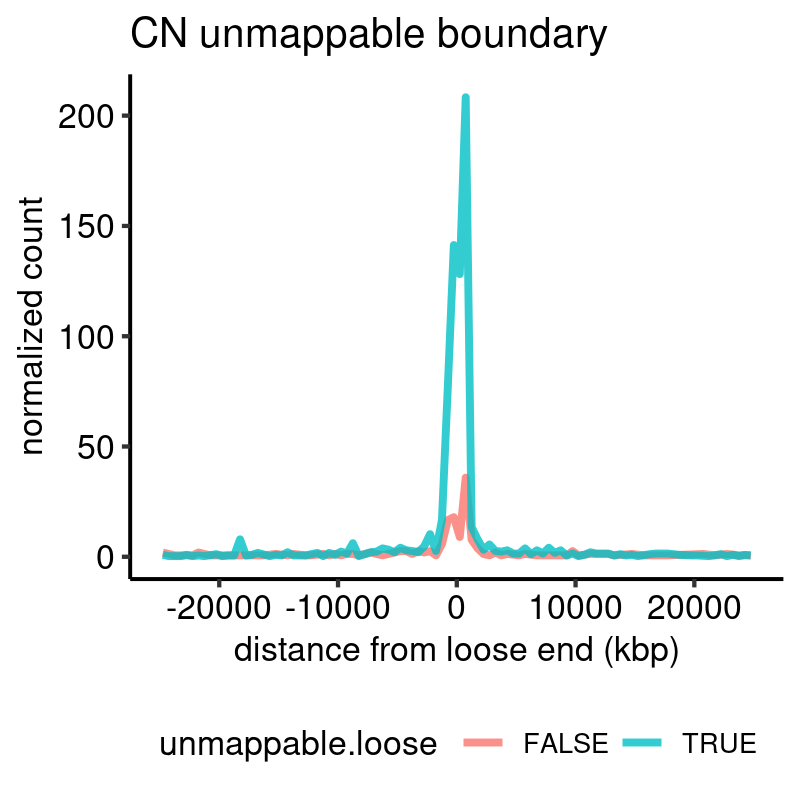

In [257]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 5e
What fraction of breakends are incompletely mapped? Cancer type boxplot.

In [14]:
calls.dt = readRDS("./data/sequence_context/new.calls.dt.rds")
gg.pairs = readRDS("~/projects/gGnome/db/lambda.pairs.rds")

pt.dt = calls.dt[(keep) & (gg.pairs[sample, tn_cohort]), 
                 .(count = as.numeric(.N), 
                   unmappable = .SD[new.annotation == "breakend" | new.annotation == "no contigs", .N]), 
                 keyby = sample]

pt.dt = pt.dt[gg.pairs[(tn_cohort), pair]] %>% setkey("sample")

pt.dt[, unmappable.frac := unmappable / (count + gg.pairs[sample, final_njuncs * 2])]
pt.dt[, njuncs := gg.pairs[sample, final_njuncs * 2]]
pt.dt[is.na(unmappable.frac), unmappable.frac := 0]
pt.dt[, tumor_type_final := gg.pairs[sample, tumor_type_final]]

## reorder
pt.dt[, tumor_type_level := ordered(tumor_type_final, levels = pt.dt[, .(V1 = median(unmappable.frac, na.rm = TRUE)), 
                                                                     by = tumor_type_final][order(V1), tumor_type_final])]

pt = ggplot(pt.dt[!is.na(tumor_type_final)], 
            aes(y = unmappable.frac, x = tumor_type_level)) + 
    geom_boxplot(width = 0.5, outlier.shape = NA) + 
    labs(x = "tumor type", y = "fraction of breakends unmappable") +
    ggpubr::theme_pubr() +
    coord_flip()

In [15]:
gg.pairs[(tn_cohort) & !is.na(tumor_type_final), .N]

[1] 1311

In [16]:
gg.pairs[(tn_cohort), length(unique(pair)), by = tumor_type_final][order(V1, decreasing = TRUE)]

tumor_type_final V1 
1  ESAD             186
2  MELA             170
3  BRCA             127
4  MALY              86
5  PRAD              70
6  BE                68
7  OV                48
8  AML               48
9  COAD              47
10 LUAD              46
11 GBM               43
12 LGG               41
13 KICH              40
14 SARC              37
15 LUSC              34
16 UCEC              34
17 HNSC              30
18 LIHC              28
19 STAD              25
20 KIRC              24
21 BLCA              20
22 KIRP              19
23 NA                19
24 CESC              15
25 THCA              12
26 ESSC               8
27 PACA               5

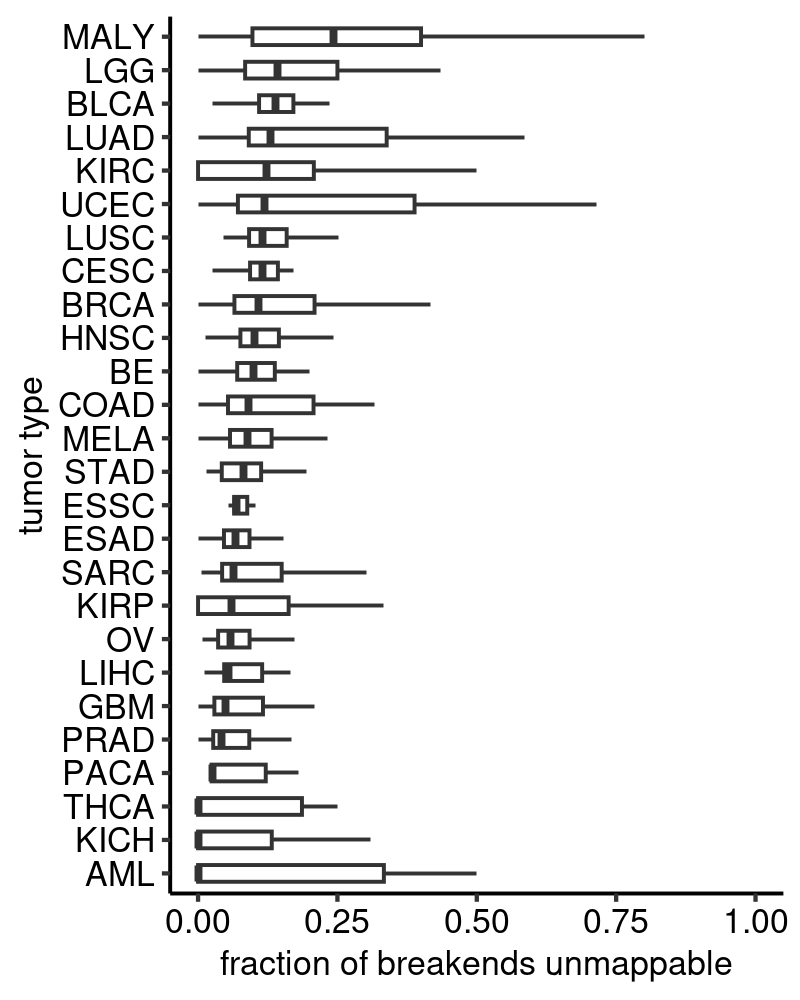

In [17]:
options(repr.plot.height = 5, repr.plot.width = 4, repr.plot.res = 200)
print(pt)

In [19]:
## skitools::ppdf(print(pt), height = 5, width = 4)

## EDF5e
Oncogene/TSG unmappable breakend violin plot

In [307]:
drivers.ov.dt = readRDS("~/projects/gGnome/files/zc_stash/driver.overlap.loose.and.junctions.dt.rds")

drivers.pt.dt = dcast.data.table(drivers.ov.dt[, .N, by = .(mappable.ra, gene_name)], gene_name ~ mappable.ra, value.var = "N", fill = 0)
drivers.pt.dt[, n.total := mappable + unmappable]
drivers.pt.dt[, frac.unmappable := unmappable / n.total]

drivers.pt.dt[, nice.label := ifelse(frac.unmappable >= 0.2 & n.total > 3, paste(gene_name, paste0("(", n.total, ")")), "")]

pt = ggplot(drivers.pt.dt[n.total >= 5], aes(x = 1, y = frac.unmappable)) +
    geom_violin(draw_quantiles = TRUE, bw = 0.02, fill = "cornflowerblue") +
    ggforce::geom_sina(shape=16, alpha = 0.8, size = 1) + 
    ggrepel::geom_label_repel(aes(label = nice.label), box.padding = 0.15, point.padding = 0.1, segment.color = 'grey50', max.overlaps = 10) +
    labs(x = "", y = "fraction unmappable breakends") +
    ggpubr::theme_pubr() +
    theme(legend.position = "none") +
    ylim(0, 0.5)


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


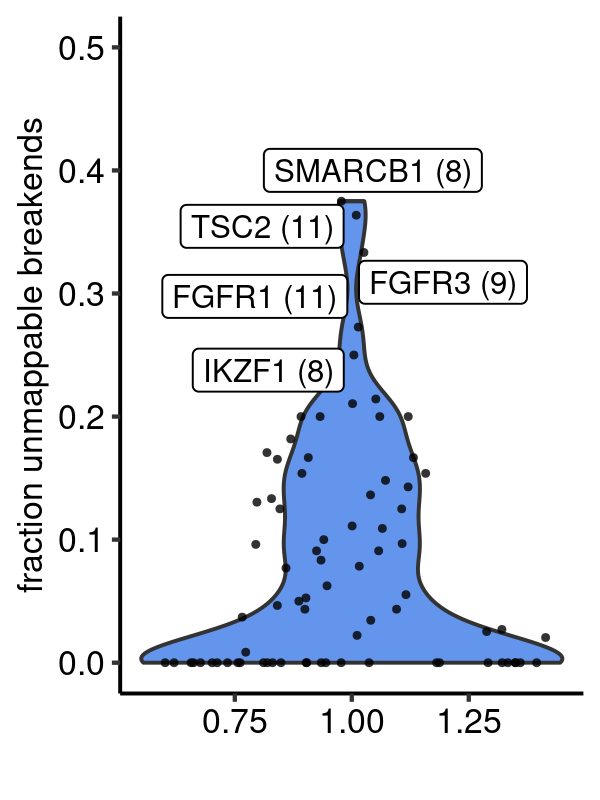

In [308]:
options(repr.plot.height = 4, repr.plot.width = 3, repr.plot.res = 200)
pt

# Extended Data Figure 6
Some validation figures for ONT comparison

## EDF6a
Coverage comparison for ONT and SRS

In [311]:
pt.dt = readRDS("./data/ont/ont.srs.setdiff.coverage.anchorlift.pt.dt.rds")

pt = ggplot(pt.dt, aes(x = start, y = norm.cn, fill = fused, color = fused)) +
    geom_point(alpha = 0.1, size = 0.3) +
    facet_grid(rows = vars(category.factor), cols = vars(reciprocal.factor)) +
    ylim(-1, 3) +
    ggpubr::theme_pubr() +
    theme(legend.position = "none") +
    labs(y = "normalized CN", x = "distance from breakend")

Warning message:
“Removed 9049 rows containing missing values (`geom_point()`).”


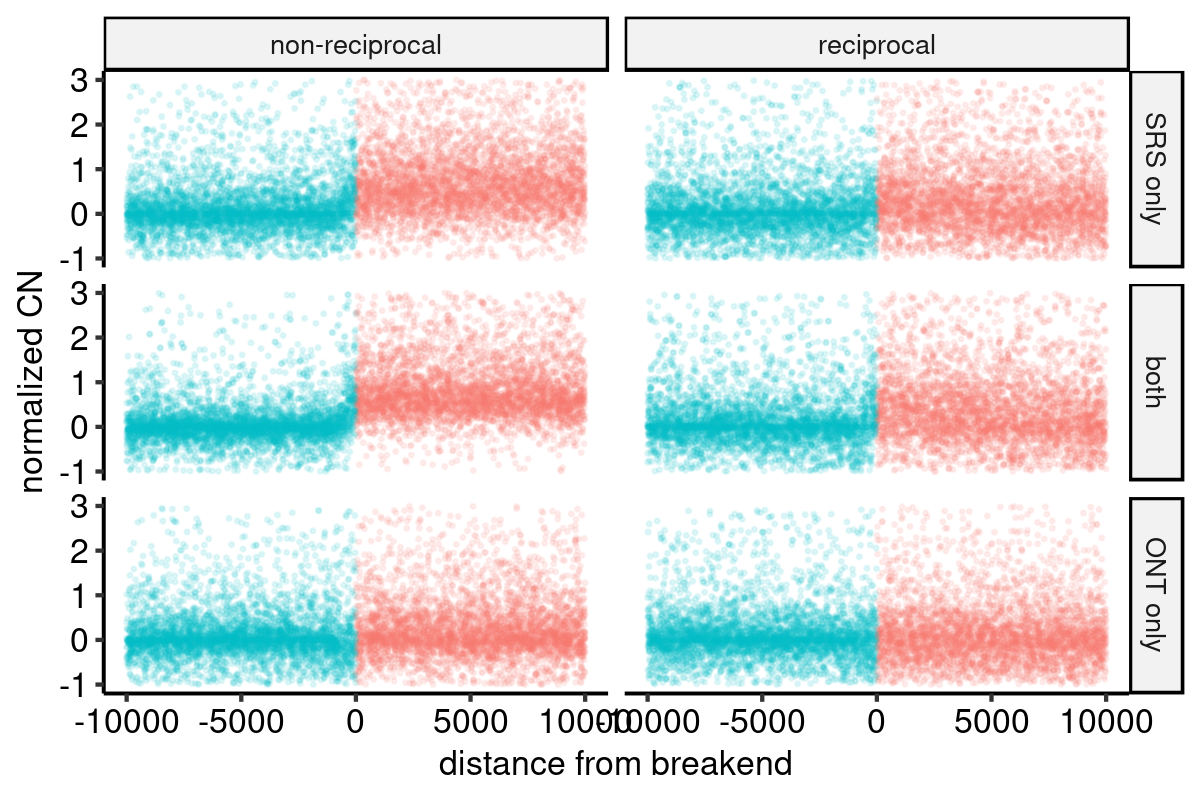

In [312]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
pt

# Extended Data Figure 7
Comparison of SRS and linked reads (AKA simulated long read sequencing, sLRS)

## EDF7a
Alluvial plot, linked reads

In [327]:
h.alluv.dt = readRDS("./data/linked_reads/fig2.h.alluv.dt.rds")
setdiff.bnds.dt = readRDS("./data/linked_reads/fig2.h.setdiff.bnds.dt.rds")

alluv.pt = ggplot(h.alluv.dt, aes(axis1 = intersection.level, axis2 = reciprocal.label, y = N)) +
    ggalluvial::geom_alluvium(aes(fill = intersection.label), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.1, reverse = FALSE, alpha = 1, color = "white", fill = "blue") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . / (h.alluv.dt[, sum(N)]), name = "frac")) +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "count") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")
    

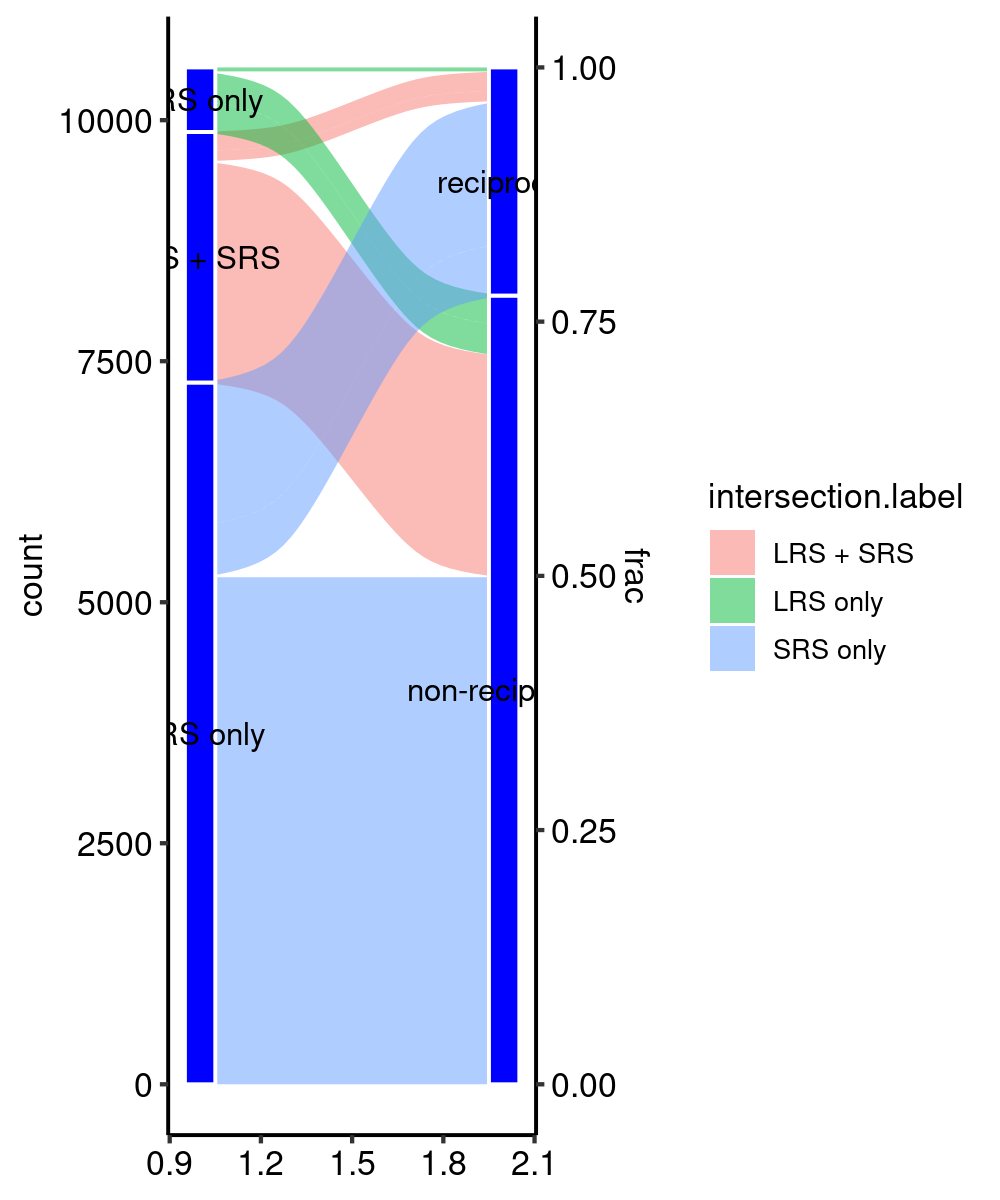

In [329]:
options(repr.plot.height = 6, repr.plot.width = 5, repr.plot.res = 200)
alluv.pt

## EDF7b
Coverage anchorlift for (high-confidence, > 2 callers) linked read breakends, separated by whether they are reciprocated

In [313]:
pt.dt = readRDS("./data/linked_reads/lrs.srs.setdiff.coverage.anchorlift.pt.dt.rds")

pt = ggplot(pt.dt, aes(x = start, y = norm.cn, fill = fused, color = fused)) +
    geom_point(alpha = 0.2, size = 0.3) +
    facet_grid(rows = vars(category.factor), cols = vars(reciprocal.factor)) +
    ylim(-1, 3) +
    ggpubr::theme_pubr() +
    theme(legend.position = "none") +
    labs(y = "normalized CN", x = "distance from breakend")

Warning message:
“Removed 6096 rows containing missing values (`geom_point()`).”


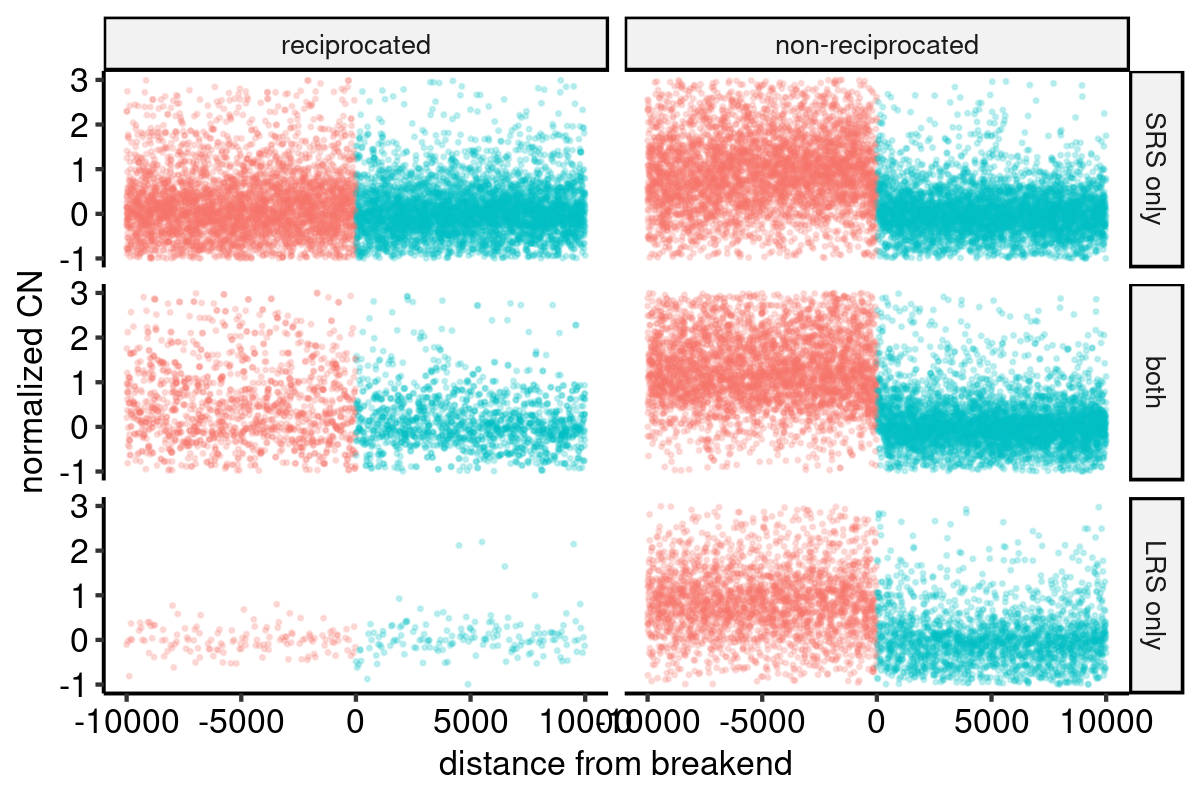

In [314]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
pt

## EDF7c
Complex event calls, linked reads

In [330]:
frac.event.dt = readRDS("./data/linked_reads/lrs.rescue.per.event.dt.v2.rds")

bp = ggplot(frac.event.dt, aes(x = label.levels, fill = new.label)) +
    geom_bar(stat = "count", position = "fill") +
    labs(x = "event type (n events)", y = "count") +
    ggpubr::theme_pubr() +
    coord_flip() +
    theme(legend.position = "right")

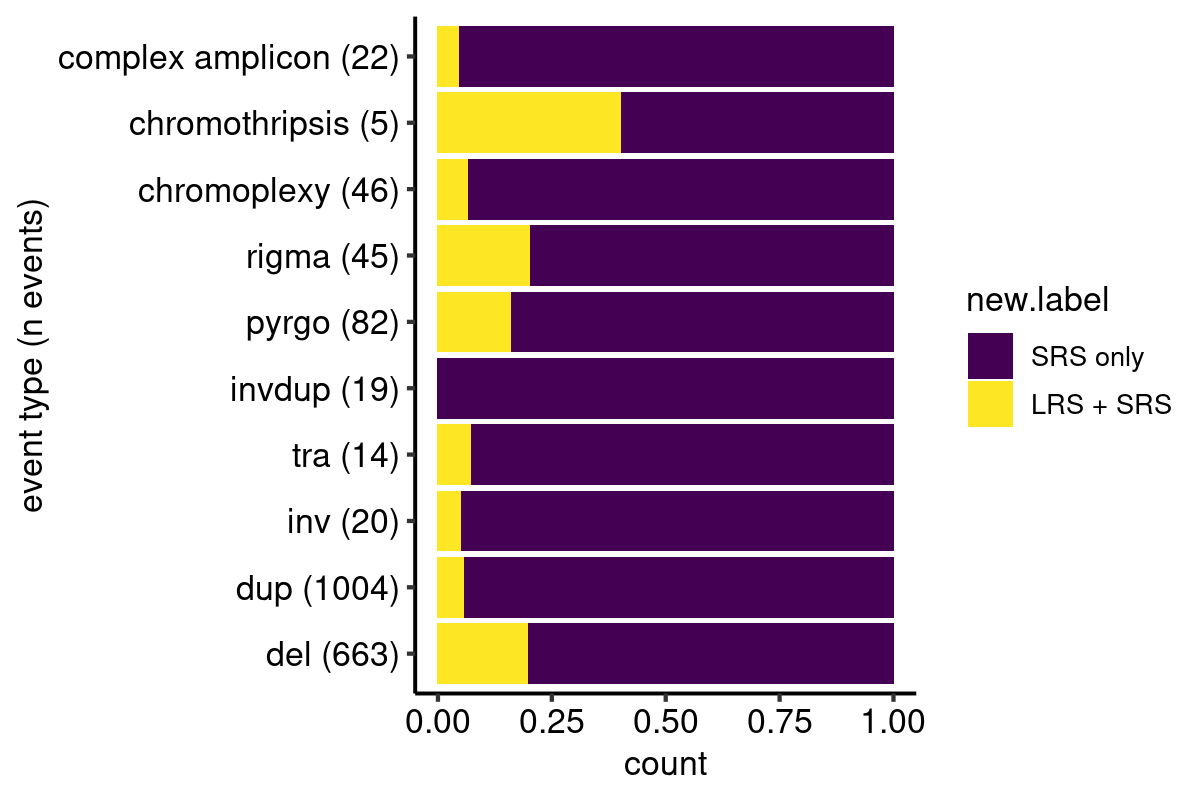

In [332]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
bp

# Extended Data Figure 9
Viral loose ends

## EDF9b
Fraction of samples with a viral fusion by tumor type.

In [10]:
viral.cn.dt = readRDS("./data/viral/viral.cn.dt.rds")

viral.tt.dt = viral.cn.dt[(!is.na(tumor_type_final)), .(n.tot = length(unique(sample)), n.viral = sum(viral.le & !(jstring %like% 'phage'))), by = tumor_type_final]
viral.tt.dt[, frac := n.viral / n.tot]
viral.tt.dt[, tumor.level := ordered(tumor_type_final, levels = viral.tt.dt[order(frac), tumor_type_final])]

viral.tt.dt[, ci.lower := mapply(function(x, y) {dflm(prop.test(x, y))$ci.lower}, n.viral, n.tot) %>% unlist]
viral.tt.dt[, ci.upper := mapply(function(x, y) {dflm(prop.test(x, y))$ci.upper}, n.viral, n.tot) %>% unlist]

pt = ggplot(viral.tt.dt[n.tot >= 10], aes(x = tumor.level, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin=ci.lower, ymax=ci.upper), width=.2,position=position_dodge(.9)) +
    labs(y = "fraction of samples", x = "tumor type") +
    ggpubr::theme_pubr() +
    ylim(0, 1) +
    coord_flip()

Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test(x, y):
“Chi-squared approximation may be incorrect”
Warning message in prop.test

In [20]:
viral.tt.dt[(n.tot >= 10), .(n.tot, n.viral, tumor_type_final)][order(n.viral / n.tot)]

n.tot n.viral tumor_type_final
1  157    0      BRCA            
2  187    0      ESAD            
3   48    0      LUSC            
4   69    0      OV              
5  185    0      MELA            
6   45    0      SCLC            
7   45    0      SARC            
8   42    0      UCEC            
9   68    0      COAD            
10  70    0      LUAD            
11  53    0      PRAD            
12  90    0      MALY            
13  13    0      ESSC            
14  46    0      STAD            
15  26    0      KIRC            
16  65    0      BE              
17  44    0      LGG             
18  26    0      BLCA            
19  45    0      GBM             
20  13    0      PACA            
21  23    0      AML             
22  19    0      KICH            
23  12    0      KIRP            
24  59    9      HNSC            
25  65   17      LIHC            
26  18    8      CESC

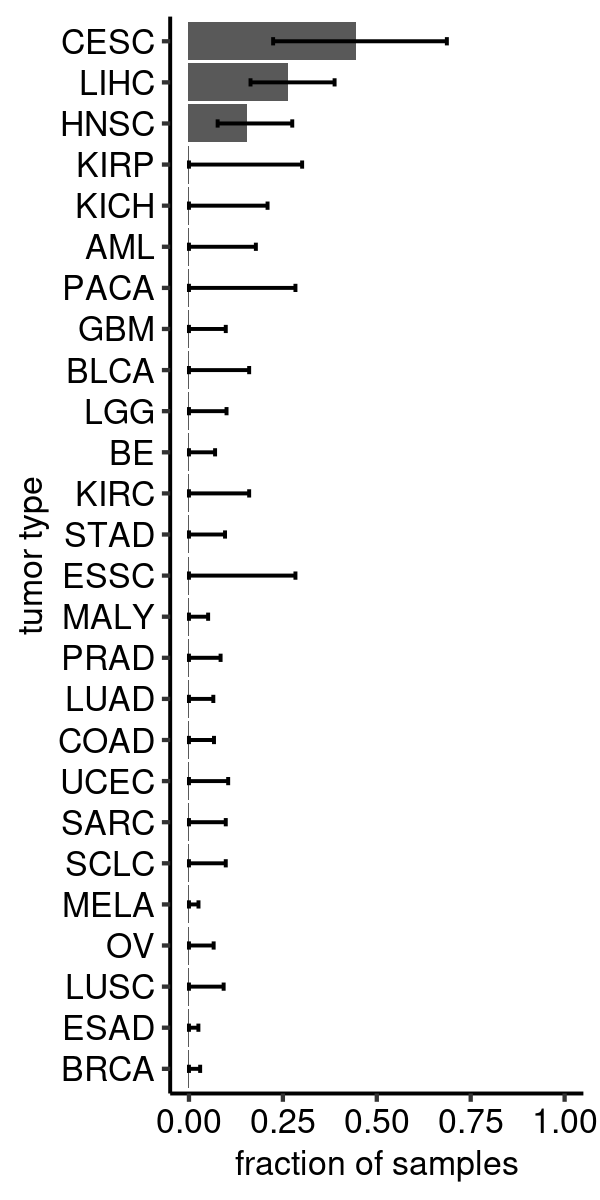

In [335]:
options(repr.plot.height = 6, repr.plot.width = 3, repr.plot.res = 200)
pt

## EDF9c
Viral loose ends and high copy amplicons

### Viral loose ends and CN>7

In [21]:
starcode = function(x) 
{return( ifelse(x < 1e-4, "****",
                ifelse(x < 1e-3, "***", 
                       ifelse(x < 1e-2, "**",ifelse(x < 5e-2, "*", ifelse(x < 1e-1, ".", "")))))) 
                        
}

In [22]:
viral.fisher.dt = data.table(group1 = TRUE, 
                             group2 = FALSE, 
                             p = viral.cn.dt[, fisher.test(highcn, viral.le)$p.value], 
                             y = TRUE, y.position = 0.8)
viral.fisher.dt[, p.pretty := format(p, digits = 3)]
viral.fisher.dt[, stars := starcode(p)]

viral.p.dt = viral.cn.dt[, .(n.highcn = .SD[(highcn), .N], n = .N), 
                         by = viral.le]
viral.p.dt[, ci.lower := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.lower}, n.highcn, n))]
viral.p.dt[, ci.upper := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.upper}, n.highcn, n))]

## viral amplification barplot (not separated by strain)
pt = ggplot(viral.p.dt, aes(x = viral.le, y = n.highcn / n)) + 
geom_bar(stat = "identity") +
ggpubr::stat_pvalue_manual(data = viral.fisher.dt, y.position = 0.55, label = "stars") + 
labs(x = "viral loose end", y = "fraction with CN > 7") + 
ggpubr::theme_pubr() + 
geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9))

In [24]:
viral.fisher.dt

group1 group2 p            y    y.position p.pretty stars
1 TRUE   FALSE  2.405587e-08 TRUE 0.8        2.41e-08 ****

In [25]:
viral.p.dt

viral.le n.highcn n     ci.lower  ci.upper  
1 FALSE    2497     67354 0.0356648 0.03853384
2  TRUE      11        34 0.1797549 0.50628753

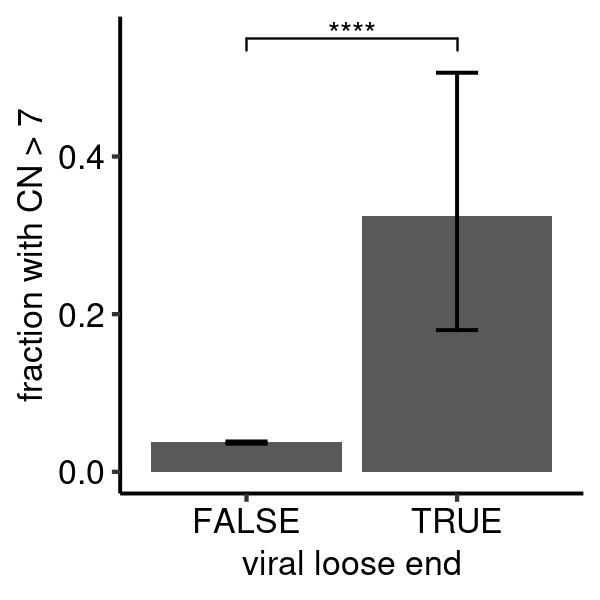

In [340]:
options(repr.plot.height = 3, repr.plot.width = 3, repr.plot.res = 200)
pt

### Viral loose end amplicons vs. strain

In [26]:
viral.cn.dt[(viral.le), virus.type := ifelse(jstring %like% "NC_001357.1", "HPV18", 
                                             ifelse(jstring %like% "NC_001526.2", "HPV16",
                                                    ifelse(jstring %like% "Hepatitis_B", "HBV", 
                                                           ifelse(jstring %like% "Hepatitis_C", "HCV", "other"))))]

pt = ggplot(viral.cn.dt[, boxplot.type := ifelse(is.na(virus.type), "other", virus.type)][!boxplot.type == "other"],
            aes(x = boxplot.type, y = cn)) +
    geom_boxplot(width = 0.6, outlier.shape = NA) +
    geom_jitter(shape=16, position=position_jitter(0.08), alpha = 0.8, size = 0.8) +
    ggpubr::stat_compare_means(comparisons = list(c("HBV", "HPV16"),
                                                  c("HBV", "HPV18"),
                                                  c("HPV16", "HPV18")),
                               symnum.args = list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 1), symbols = c("****", "***", "**", "*", "ns"))) + 
    ylim(0, 1000) +
    scale_y_continuous(trans = "log", breaks = c(1, 10, 100)) +
    labs(x = "Viral loose end", y = "CN") +
    ggpubr::theme_pubr()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [27]:
viral.cn.dt[(viral.le), table(virus.type)]

virus.type
  HBV HPV16 HPV18 other 
   17    11     4     2 

In [28]:
wilcox.test(viral.cn.dt[(virus.type == "HPV16"), cn], viral.cn.dt[(virus.type == "HPV18"), cn])

Warning message in wilcox.test.default(viral.cn.dt[(virus.type == "HPV16"), cn], :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  viral.cn.dt[(virus.type == "HPV16"), cn] and viral.cn.dt[(virus.type == "HPV18"), cn]
W = 42.5, p-value = 0.008242
alternative hypothesis: true location shift is not equal to 0


In [29]:
wilcox.test(viral.cn.dt[(virus.type == "HBV"), cn], viral.cn.dt[(virus.type == "HPV16"), cn])

Warning message in wilcox.test.default(viral.cn.dt[(virus.type == "HBV"), cn], viral.cn.dt[(virus.type == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  viral.cn.dt[(virus.type == "HBV"), cn] and viral.cn.dt[(virus.type == "HPV16"), cn]
W = 5.5, p-value = 2.154e-05
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(c(0, 0.693147180559945, 0, 0, 0.693147180559945, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0.693147180559945, 0, 0, 0.693147180559945, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.693147180559945, 2.07944154167984, 3.43398720448515, :
“cannot compute exact p-value with ties”


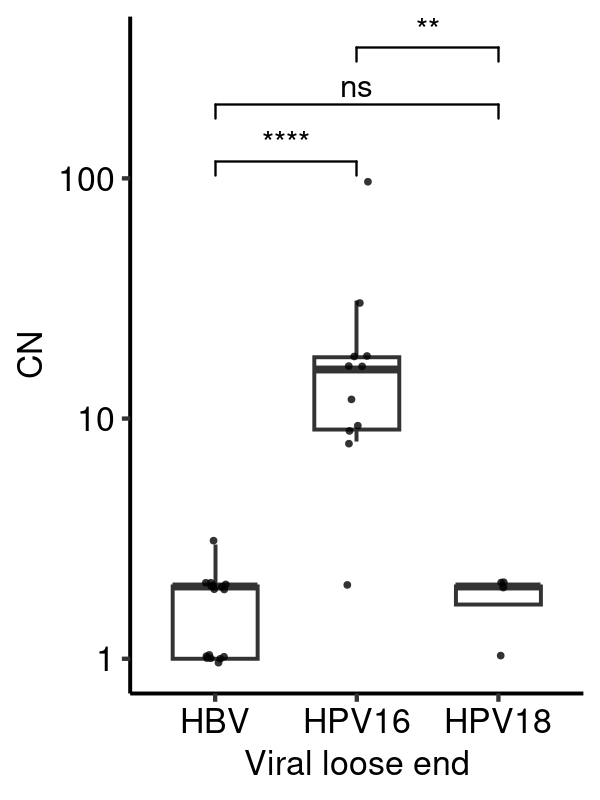

In [345]:
options(repr.plot.height = 4, repr.plot.width = 3, repr.plot.res = 200)
pt

# Extended Data Figure 10
CNLOH benchmarking and quantification

## EDF10a
Confusion matrix for cnLOH (mitotic recombination) versus "progressive UPD"

In [348]:
long.confusion.cnloh.dt = readRDS("./data/benchmarking/long.confusion.cnloh.dt.rds")
confusion.cnloh.dt = readRDS("./data/benchmarking/confusion.cnloh.dt.rds")

pt = ggplot(confusion.cnloh.dt, aes(x = gs.level, y = query.level, fill = fraction.query)) +
    geom_raster() +
    scale_fill_gradientn(colors = c("white", "pink"), values = c(0, 1)) +
    geom_text(aes(label = gbp.pretty)) +
    facet_grid(cols = vars(method.level)) +
    labs(x = "ground truth", y = "call", legend = "fraction of calls", title = "confusion matrix - Gbp per call") +
    ggpubr::theme_pubclean() +
    theme(legend.position = "bottom") +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

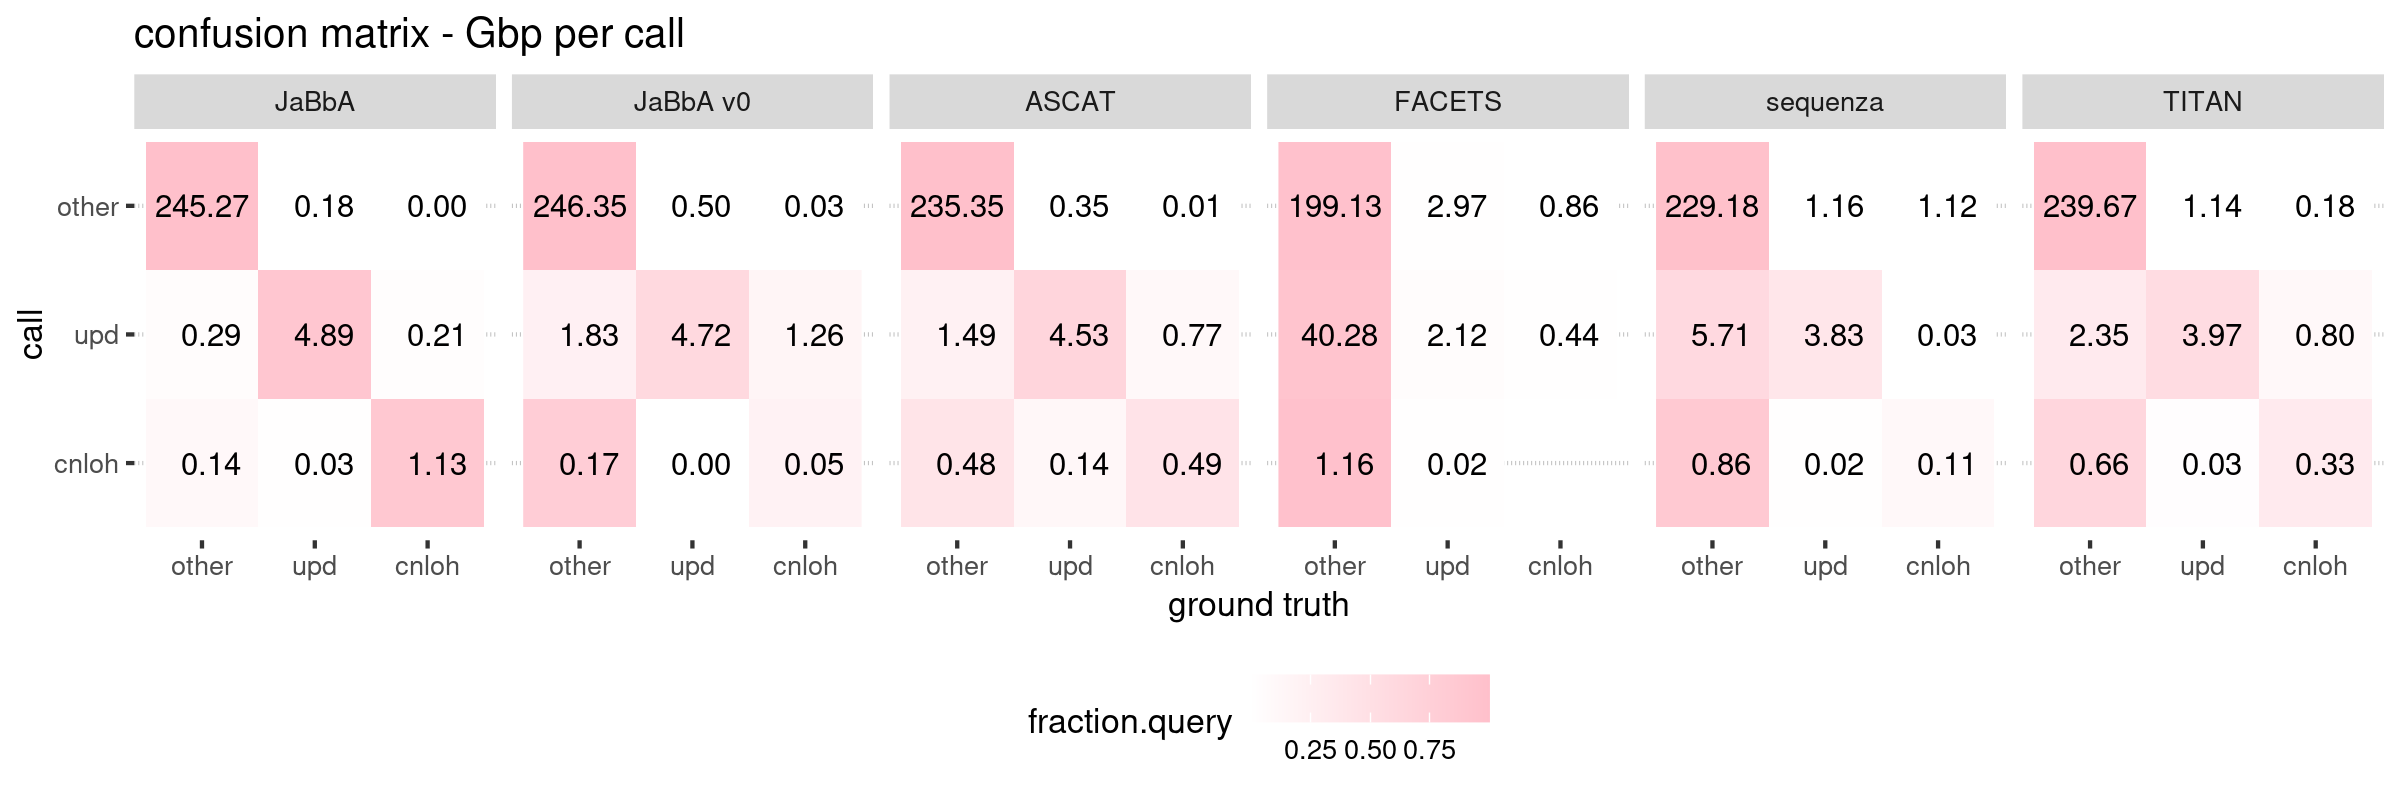

In [349]:
options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
pt

## EDF10b
Precision and recall for CNLOH detection

In [352]:
pt.dt = readRDS("~/projects/gGnome/files/zc_stash/cnloh.precision.recall.bp.dt.rds")

pt = ggplot(pt.dt, aes(x = method.factor, y = value, fill = method.color)) +
    geom_bar(stat = "identity") +
    labs(x = "method", y = "score", title = "cnLOH detection") +
    facet_grid(rows = vars(variable)) +
    ylim(0, 1) +
    ggpubr::theme_pubr() +
    theme(legend.position = "none") +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    coord_flip()

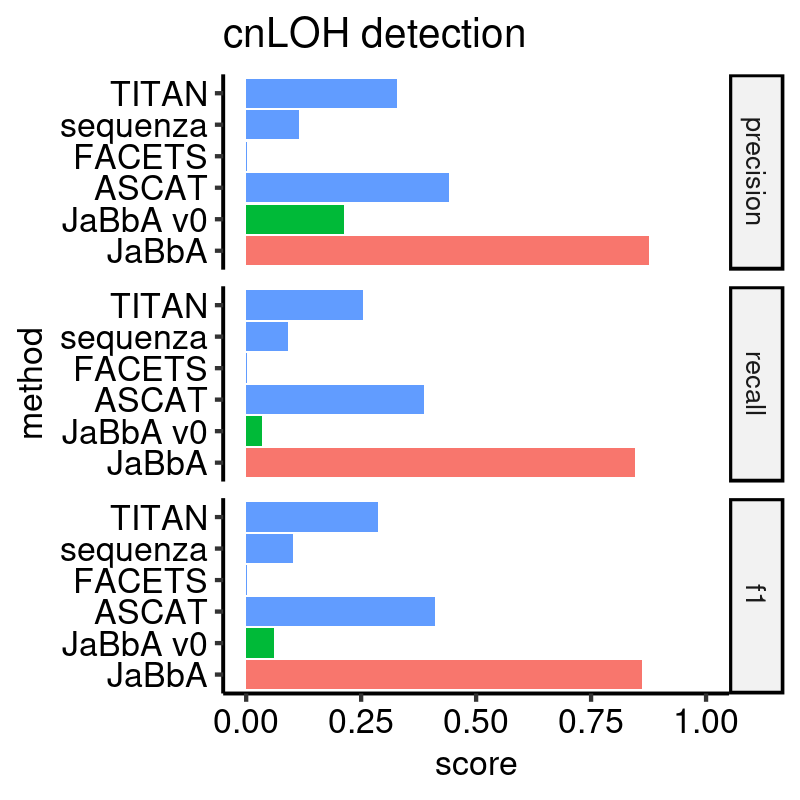

In [353]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## EDF10c
Fraction of samples with at least one instance of cnLOH by tumor type

In [39]:
nahr.ddr.dt = readRDS("./data/cnloh/genotype_cnloh_onehot.rds")
gg.pairs = readRDS("./data/sample.table.rds")
nahr.ddr.sub.dt = nahr.ddr.dt[!(gg.pairs[sample, dataset] %in% c("CCLE", "ALT"))][!(tumor_type_final == "BE")]
##nahr.ddr.sub.dt = nahr.ddr.dt[!(gg.pairs[sample, (tn_cohort)])][!(tumor_type_final == "BE")]

## only plot tumor types with >= 15 examples
pt.dt = nahr.ddr.sub.dt[, .(frac = .SD[(cnloh), .N]/.N, 
                            count = .N, n.cnloh = .SD[(cnloh), .N]), 
                        by = tumor_type_final][count >= 15,]
pt.dt[, tumor_type_final := ordered(tumor_type_final, tumor_type_final[order(frac, decreasing = FALSE)])]
pt.dt[, ci.lower := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.lower}, n.cnloh, count))]
pt.dt[, ci.upper := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.upper}, n.cnloh, count))]

pt = ggplot(pt.dt[count >= 10], aes(x = tumor_type_final, y = frac)) +
    geom_bar(stat = "identity", position = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    labs(x = "tumor type", y = "fraction of cases") +
    ggpubr::theme_pubr() +
    ylim(0, 1) +
    coord_flip()

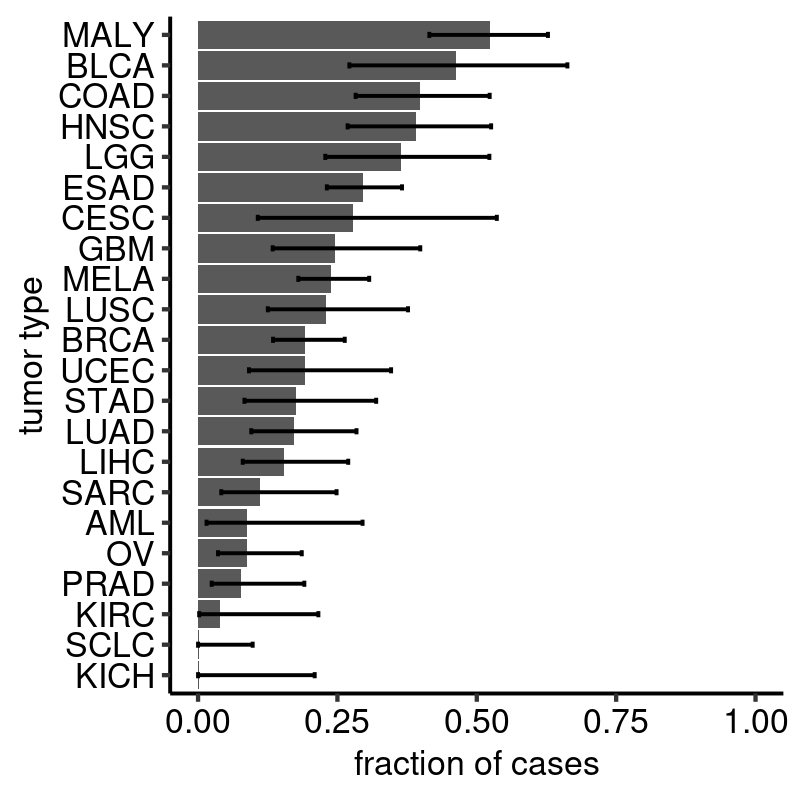

In [40]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

In [41]:
pt.dt

tumor_type_final frac       count n.cnloh ci.lower    ci.upper  
1  GBM              0.24444444  45   11      0.133850480 0.39860743
2  ESAD             0.29411765 187   55      0.231032592 0.36582637
3  OV               0.08695652  69    6      0.035845528 0.18601652
4  LUSC             0.22916667  48   11      0.125144475 0.37666040
5  LUAD             0.17142857  70   12      0.095451258 0.28423439
6  COAD             0.39705882  68   27      0.282678048 0.52312487
7  AML              0.08695652  23    2      0.015206201 0.29508764
8  KIRC             0.03846154  26    1      0.002010977 0.21582357
9  HNSC             0.38983051  59   23      0.268298715 0.52571898
10 MALY             0.52222222  90   47      0.414875550 0.62765361
11 STAD             0.17391304  46    8      0.083221926 0.31953319
12 LIHC             0.15384615  65   10      0.080146417 0.26938960
13 LGG              0.36363636  44   16      0.228258584 0.52258702
14 PRAD             0.07547170  53    4      0.024454760 0.19066224
15 KICH             0.00000000  19    0      0.000000000 0.20920574
16 BRCA             0.19108280 157   30      0.134524506 0.26314666
17 UCEC             0.19047619  42    8      0.091412818 0.34627086
18 BLCA             0.46153846  26   12      0.271383795 0.66252321
19 CESC             0.27777778  18    5      0.107125758 0.53594197
20 MELA             0.23783784 185   44      0.179798183 0.30700671
21 SARC             0.11111111  45    5      0.041636279 0.24847989
22 SCLC             0.00000000  45    0      0.000000000 0.09796491

# Extended Data Figure 11
sLRS validation of NAHR calls, plus some assorted NAHR-rate plots for T2T extrapolation

## EDF11b
NAHR in linked read (sLRS) profiles

In [50]:
setdiff.nahr.dt = readRDS("./data/linked_reads/lrs.srs.full.setdiff.nahr.dt.rds")
setdiff.nahr.pt.dt =  readRDS("./data/linked_reads/lrs.srs.full.setdiff.nahr.pt.dt.rds")

pt = ggplot(setdiff.nahr.pt.dt, aes(x = germline.or.somatic, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    facet_grid(cols = vars(breakend.type)) +
    labs(x = "breakend type", y = "frac putative NAHR") +
    ylim(0, 1) +
    ggpubr::theme_pubr()

In [51]:
setdiff.nahr.pt.dt

breakend.type germline.or.somatic tot  n.pos frac        ci.lower   
1 SRS loose     somatic             2397   8   0.003337505 0.001552685
2 SRS loose     germline             282  42   0.148936170 0.110562741
3 SRS junction  germline            4740 184   0.038818565 0.033584355
4 SRS junction  somatic             5694  14   0.002458728 0.001399805
5 LRS junction  somatic             3352  34   0.010143198 0.007143124
6 LRS junction  germline            1978 934   0.472194135 0.450017140
  ci.upper   
1 0.006847398
2 0.197142915
3 0.044813974
4 0.004232837
5 0.014313387
6 0.494480162

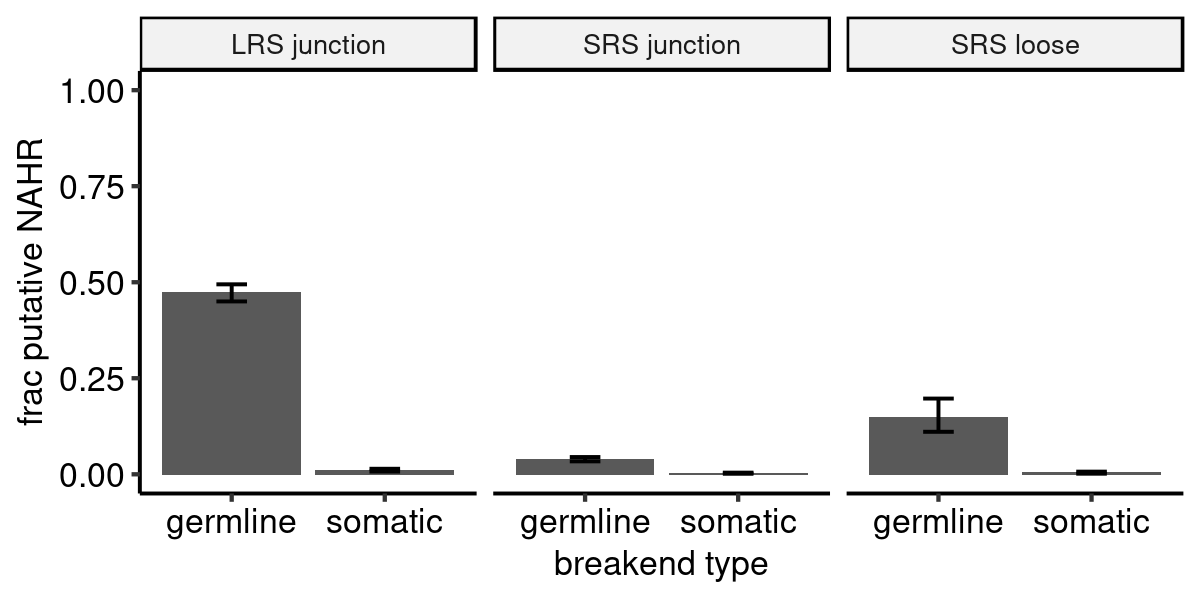

In [365]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

## EDF11f

In [366]:
tiles = readRDS("./data/nahr/breakend.density.tiles.rds")

pt.dt = as.data.table(tiles)[(seqnames %in% c(as.character(1:22))), 
                             .(mean.per.chr = weighted.mean(breakend.density, 1 - mask.fraction)),
                             by = seqnames]

pt = ggplot(pt.dt, aes(x = 1, y = mean.per.chr)) +
    geom_violin(scale = "width") +
    geom_boxplot(width = 0.2, outlier.shape = NA) +
    ylim(0, 0.2) +
    geom_jitter(position = position_jitter(seed = 1)) +
    geom_text(position = position_jitter(seed = 1),
              aes(label = seqnames), hjust = 0, vjust = 0) +
    ggpubr::theme_pubr() +
    labs(x = "chromosome", y = "mean breakend density (per Mbp)")


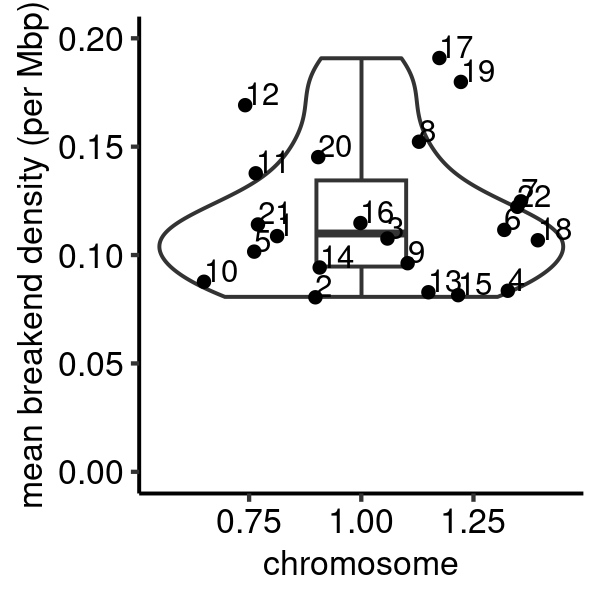

In [367]:
options(repr.plot.height = 3, repr.plot.width = 3, repr.plot.res = 200)
pt

## EDF11g

Correlation between somatic NAHR (putative...) and number of eligible sites per chromosome

In [369]:
somatic.nahr.dt = readRDS("./data/nahr/somatic.nahr.dt.rds")
## eligible sites per chr
elg.dt = readRDS("./data/nahr/elg.dt.rds")

somatic.nahr.sn.dt = somatic.nahr.dt[, .(n = .SD[(!overlaps_germline) & (!recurrent), .N]), keyby = seqnames]
somatic.nahr.sn.dt[, elg := elg.dt[somatic.nahr.sn.dt, V1]]

pt = ggplot(somatic.nahr.sn.dt, aes(x = elg / 2e3, y = n)) +
    geom_point() +
    geom_smooth(method = "lm") +
    ggpubr::theme_pubr() +
    geom_text(aes(label = seqnames), hjust = 0, vjust = 0) +
    labs(x = "eligible sites (Kbp)", y = "somatic NAHR breakend count")

`geom_smooth()` using formula = 'y ~ x'


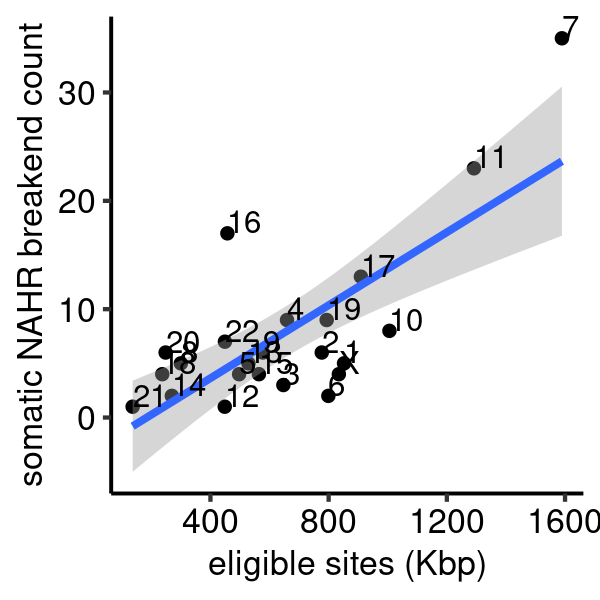

In [370]:
options(repr.plot.height = 3, repr.plot.width = 3, repr.plot.res = 200)
pt